In [2]:
%load_ext autoreload
%autoreload 2
from importlib import reload

from collections import defaultdict, Counter

import numpy

import random
from matplotlib import pyplot as plt
from random import shuffle, choice, randint

import math
import keras
import tensorflow

import pickle

from sklearn.metrics import f1_score

def logistic(x, b,off):
    z = b*(x-off)
    return numpy.exp(z)/(1+numpy.exp(z))

def pr_to_spread(p, comps=1, as_A_and_D=True):
    per_comp_p = p**(1/(comps))
#     print("p         ", p)
#     print("per comp p", per_comp_p)
#     spread = -numpy.log((1.0/per_comp_p)-1.0)
    inv_sigmoid = lambda pr : ( -numpy.log((1/pr) -1) )
    spread = inv_sigmoid(per_comp_p)
#     print("spread    ", spread)
    if as_A_and_D:
        a = spread/2.0
        d = -spread/2.0
        return a,d
    else:
        return spread

print("started")


# from google.colab import drive
# drive.mount('/content/gdrive')
import sys
# sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
from NN_utils import BigTable, WeightClip

def calc_probs_from_embs(students,questions):
    students2 = numpy.repeat(students, len(questions), axis=0)
    questions2 = numpy.tile(questions, (len(students),1))
    zmask = numpy.isclose(questions2,-10).astype(int)
    diffs = students2-questions2
    prs = numpy.exp(diffs)/(1.0+ numpy.exp(diffs))
    prs = numpy.maximum(zmask,prs)
    probs2 = numpy.prod(prs, axis=1).reshape(len(students), len(questions))
    return probs2

def calc_probs(s,q):
    zmask = numpy.isclose(q,-10).astype(int)
    diff = s-q
    prs = 1.0/(1.0+ numpy.exp(-diff))
    prs = numpy.maximum(zmask,prs)
    # print(prs)
    if len(q.shape)>1 and len(q.shape[0]) > 1:
      raise Exception("tensor is wrong shape, duh")
      # pr = pr.reshape(len(q))
    pr = numpy.prod(prs)
    return pr, zmask

# home = "/content/gdrive/My Drive/Colab Notebooks"
home="."

import pandas
mapping = pandas.read_csv(home+"/real_data/qn_act_map.csv")
mapping.index = mapping.qn_id
# mapping.drop("qn_id", axis=1, inplace=True)
print(mapping[0:100])

started
                                     qn_id     activity_name  \
qn_id                                                          
Dialogue 1~1.0              Dialogue 1~1.0        Dialogue 1   
Dialogue 1~2.0              Dialogue 1~2.0        Dialogue 1   
Dialogue 1~3.0              Dialogue 1~3.0        Dialogue 1   
Dialogue 1~4.0              Dialogue 1~4.0        Dialogue 1   
Dialogue 1~5.0              Dialogue 1~5.0        Dialogue 1   
Minimal pairs 1~1.0    Minimal pairs 1~1.0   Minimal pairs 1   
Minimal pairs 1~2.0    Minimal pairs 1~2.0   Minimal pairs 1   
Minimal pairs 1~3.0    Minimal pairs 1~3.0   Minimal pairs 1   
Minimal pairs 1~4.0    Minimal pairs 1~4.0   Minimal pairs 1   
Minimal pairs 1~5.0    Minimal pairs 1~5.0   Minimal pairs 1   
Minimal pairs 1~6.0    Minimal pairs 1~6.0   Minimal pairs 1   
Minimal pairs 1~7.0    Minimal pairs 1~7.0   Minimal pairs 1   
Minimal pairs 1~8.0    Minimal pairs 1~8.0   Minimal pairs 1   
Minimal pairs 1~9.0    Minimal p

In [3]:
def progress_one_step(q,s, s_gammas):
  pr, zmask = calc_probs(s,q)
  active_in_q = 1-zmask
  # print(active_in_q)
  # print("pr is", pr)
  passed = 0
  if (numpy.random.random() <= pr):
    passed = 1
  s= s + s_gammas*active_in_q # learning rates from a successful attempt
  # else:
  #   s= s + s_rhos*active_in_q # learning rates from an unsauccessful attempt
  return passed, pr, s

In [4]:
def run_data(students, questions, gammas, model_to_train=None):
  from collections import defaultdict, Counter
  sixs = []
  qixs = []
  hits = []
  outps = []
  
  r = -1
  scores = defaultdict(int)
  hit_counter = {}
  
  s_indices = range(len(students))
  # bo_selecta = None
  for six in s_indices:
    print("running student, ", six)
    s = students[six]
    R = 0  # reset reward for new student
    ball_bag = list(range(len(questions)))
    while ball_bag:
      # print("WSH",s.shape)
      # print(numpy.mean(s), numpy.min(s), numpy.max(s))
      # for sval in s:
      #   print(sval)
      # raise Exception("WANK")
      # if bo_selecta is None:
      bo_selecta = random.choice(ball_bag)
      q = questions[bo_selecta]
      passed, pr, s_ = progress_one_step(q,s, gammas[six])
      students[six] = s_ # Crucially, update the student to make progress...
      # print(six, bo_selecta, numpy.mean(students[six]), pr)
      if passed:
        # print("***PASSED***", six, bo_selecta, pr)
        ball_bag.remove(bo_selecta)

      # hit_counter[(six, bo_selecta)] += 1
      # hit_counter
    
      if six not in hit_counter:
        print("INIT'G zeros FOR", six)
        hit_counter[six] = [int(0)]*n_questions #numpy.zeros(n_questions, dtype="uint8")

      sixs.append( [int(six)])
      qixs.append([int(bo_selecta)])
      hits.append( tuple(hit_counter[six]) )
      outps.append( [int(passed)] )

      # neue = hit_counter[six]
      # neue[bo_selecta] += 1
      hit_counter[six][bo_selecta] += 1

      R += r
      # bo_selecta = None
    print(R)
    scores[six] = R

  # if model_to_train:
  #   phat = model_to_train.predict([[six], [bo_selecta], [hit_counter[(six,bo_selecta)]] ])
  #   mae = abs(pr - phat)
  #   print(pr, phat, mae)
  #   model_to_train.train_on_batch( [ [six], [bo_selecta], [hit_counter[(six,bo_selecta)]] ], [passed] )
 
  # print("Die Arrays werden in Numpy Datentypen verwandelt.")
  # sixs = numpy.array(sixs, dtype="uint8")
  # qixs = numpy.array(qixs, dtype="uint8")
  # hits = numpy.array(hits, dtype="uint8")
  # outps = numpy.array(outps, dtype="uint8")

  # print(hits.shape)
  # print(outps.shape)

  # if model_to_train:
    # phat = model_to_train.predict([[six], [bo_selecta], [hit_counter[(six,bo_selecta)]] ])
    # mae = abs(pr - phat)
    # print(pr, phat, mae)
    # model_to_train.fit( inps, outps )
  # for (k,v) in scores.items():
  #   print(k,v)
  print("Der Lauf is beendet.")
  vals = list(scores.values())
  return numpy.mean(vals), sixs, qixs, hits, outps


In [5]:
# from keras.regularizers import l1
# from keras.layers import Reshape, Dense, Dropout, add, multiply, subtract, GaussianNoise, GaussianDropout, Input, Lambda, Embedding, concatenate, Flatten, Maximum, Multiply, dot, Layer
# from keras import backend as K, Model
# from keras.initializers import RandomUniform, RandomNormal

# def hard_sigmoid(x):
#     return np.maximum(0, np.minimum(1, (x + 2) / 4))

# def binary_regulariser(x):
#     return K.sum( 1.0-(4.0*K.pow((0.5 - x),2)) )
#     # return K.sum(K.log(2*x) +K.log(2*(1-x)))
#     # return K.log(2*x) +K.log(2*(1-x))

    
# # # @keras_export('keras.layers.Dropout')
# # class Flipout(Layer):
# #   def __init__(self, rate, seed=None, **kwargs):
# #     super(Flipout, self).__init__(**kwargs)
# #     self.rate = rate
# # #     self.noise_shape = noise_shape
# #     self.seed = seed
# #     self.supports_masking = True

# # #   def _get_noise_shape(self, inputs):
# # #     # Subclasses of `Dropout` may implement `_get_noise_shape(self, inputs)`,
# # #     # which will override `self.noise_shape`, and allows for custom noise
# # #     # shapes with dynamically sized inputs.
# # #     if self.noise_shape is None:
# # #       return None

# # #     concrete_inputs_shape = array_ops.shape(inputs)
# # #     noise_shape = []
# # #     for i, value in enumerate(self.noise_shape):
# # #       noise_shape.append(concrete_inputs_shape[i] if value is None else value)
# # #     return ops.convert_to_tensor_v2(noise_shape)

# #   def call(self, inputs, training=None):
# #     if training is None:
# #       training = K.learning_phase()

# #     def dropped_inputs():
# #       return nn.dropout(
# #           inputs,
# # #           noise_shape=self._get_noise_shape(inputs),
# #           seed=self.seed,
# #           rate=self.rate)

# #     output = control_flow_util.smart_cond(training, dropped_inputs,
# #                                           lambda: array_ops.identity(inputs))
# #     return output

# #   def compute_output_shape(self, input_shape):
# #     return input_shape

# #   def get_config(self):
# #     config = {
# #         'rate': self.rate,
# # #         'noise_shape': self.noise_shape,
# #         'seed': self.seed
# #     }
# #     base_config = super(Flipout, self).get_config()
# #     return dict(list(base_config.items()) + list(config.items()))
    
    
# from keras import backend as K
# def recall_m(y_true, y_pred):
# #     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) + K.epsilon()
#     true_positives = K.sum(y_true * y_pred) + K.epsilon()
#     possible_positives = K.sum(y_true) + K.epsilon()
#     recall = true_positives / possible_positives
#     return recall

# def precision_m(y_true, y_pred):
# #     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) + K.epsilon()
#     true_positives = K.sum(y_true * y_pred) + K.epsilon()
#     predicted_positives = K.sum(y_pred) + K.epsilon()
#     precision = true_positives / predicted_positives
#     return precision

# def f1_metric(y_true, y_pred, average="macro"):
#     precision_1 = precision_m(y_true, y_pred)
#     recall_1 = recall_m(y_true, y_pred)
# #     print("p/r 1", K.eval(precision_1), K.eval(recall_1))
#     f1_1 = 2.0*precision_1*recall_1 / (precision_1+recall_1)
# #     print("f1_1", K.eval(f1_1))
#     if average=="macro":
#         precision_0 = precision_m((1-y_true), (1-y_pred))
#         recall_0 = recall_m((1-y_true), (1-y_pred))
# #         print("p/r 0", K.eval(precision_0), K.eval(recall_0))
#         f1_0 = 2.0*precision_0*recall_0 / (precision_0+recall_0)
# #         print("f1_0", K.eval(f1_0))
#         f1 = (f1_1+f1_0)/2.0
# #         print("f1  ", K.eval(f1))
#         return f1
#     else:
#         return f1_1

# def f1_loss(y_true, y_pred, average="macro"):
#     return (1.0 - f1_metric(y_true, y_pred, average=average))
    
# # def binaryRound(x):
# #     import tensorflow as tf
# #     """
# #     Rounds a tensor whose values are in [0,1] to a tensor with values in {0, 1},
# #     using the straight through estimator for the gradient.
# #     """
# #     g = tf.get_default_graph()

# #     with ops.name_scope("BinaryRound") as name:
# #         with g.gradient_override_map({"Round": "Identity"}):
# #             return tf.round(x, name=name)

# #         # For Tensorflow v0.11 and below use:
# #         #with g.gradient_override_map({"Floor": "Identity"}):
# #         #    return tf.round(x, name=name)

# # def f1_m(y_true, y_pred):
# #     import tensorflow as tf
# #     y_pred = K.round(y_pred)
# #     tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
# #     tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
# #     fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
# #     fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

# #     p = tp / (tp + fp + K.epsilon())
# #     r = tp / (tp + fn + K.epsilon())

# #     f1 = 2*p*r / (p+r+K.epsilon())
# #     f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
# #     return K.mean(f1)

# # def f1_m(y_true, y_pred):
# #     return 1 - f1_loss(y_true, y_pred)

# # def f1_loss(y_true,y_pred):
# #     return f1_loss_macro(y_true, y_pred)

# # def f1_loss(y_true, y_pred):
# #     y_trueF = (1.0-y_true)
# #     y_predF = (1.0-y_pred)

# #     f1_F = f1_inner(y_trueF, y_predF)
# #     f1_T = f1_inner(y_true, y_pred)
# #     macro = (f1_F + f1_T)/ 2.0
# #     return (1.0 - macro)

# # def f1_inner(y_true, y_pred):
# #     import tensorflow as tf
# #     y_pred = K.sigmoid(200.0*(y_pred - 0.5)) # remap y_pred to be closer to 0,1    
# #     tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)+ K.epsilon()
# #     #tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
# #     fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
# #     fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    
# #     pred_p = (tp + fp) + K.epsilon()
# #     poss_p = (tp + fn) + K.epsilon()
    
# #     p = tp / pred_p
# #     r = tp / poss_p
# #     f1 = 2.0*p*r / (p+r)
# #     return f1
# #     f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
# #     return K.mean(f1)

# # def f1_loss_micro(y_true, y_pred):
# #     micro = f1_inner_micro(y_true, y_pred)
# #     return (1.0 - micro)


# # def f1_inner_micro(y_true, y_pred, macro=False):
# #     y_true0 = (1.0 - y_true)
# #     tp0 = K.sum(K.cast(y_true0*y_pred, 'float'), axis=0)
# #     fp0 = K.sum(K.cast((1-y_true0)*y_pred, 'float'), axis=0)
# #     tp1 = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
# #     fp1 = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
# #     f1 = (tp0+tp1)/(fp0+tp0 + fp1+fp1)
# # #     f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
# #     return f1 #K.mean(f1)





# # from sklearn.metrics import f1_score
# # #(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')[source]
# # def f1_m(y_true, y_pred):
# #     if y_true==None or y_pred==None:
# #         return 0.0
# #     return f1_score(y_true, y_pred, pos_label=0, average="weighted")


# def obsolete_generate_MLTM_model(n_questions, n_students, row_w, ptqs=None, 
#                         loss="binary_crossentropy", non_neg=True, 
#                         w_init=True, q_weight=None, pow_mask=False,
#                         metrics=None):
#     print("ROW W is ", row_w)
#     # def generate_qs_model(qn_table, psi_table, optimiser, _mode="MXFN", loss="MSE"):  
#     from keras.initializers import RandomNormal, RandomUniform, Constant
#     psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
#     qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
#     hit_counter = Input(shape=(n_questions, ), name="hit_counter", dtype="float32")

#     sp = pr_to_spread(.5, row_w, as_A_and_D=False)

#     # if not ptqs:
#     if non_neg:
#         qn_emb = Embedding(n_questions , row_w, name="qn_embedding", 
#                             embeddings_constraint=WeightClip(0, math.inf),
#                             embeddings_initializer=(RandomUniform(0,1) if w_init else "uniform"),
#     #                         embeddings_regularizer=keras.regularizers.l1_l2(l1=0, l2=0.00001),
#                           )
#     else:
#         qn_emb = Embedding(n_questions , row_w, name="qn_embedding")
#         if w_init:
#             print("Using w_init==True with non_neg==False does nothing...")

#     # qn_emb = Embedding(n_questions , row_w, input_length=1, name="qn_embedding", embeddings_constraint=WeightClip(0, math.inf), embeddings_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0), embeddings_initializer=RandomUniform(0.1,0.9))
#     # qn_emb = Embedding(n_questions, row_w, input_length=1, name="qn_embedding", embeddings_initializer=RandomNormal(mean=0))
#     # else:
#     #   qn_emb = Embedding(n_questions, row_w, input_length=1, weights=[ptqs], trainable=False, name="qn_embedding")
#     # qn_emb.trainable = True
#     qn_row = qn_emb(qn_sel)


#     alpha_row = Embedding(n_students, row_w, embeddings_initializer=RandomNormal(mean=1+sp), name="alphas")(psi_sel)
#     gamma_row = Embedding(n_students, row_w, name="gammas")(psi_sel)

#     qn_row = Flatten()(qn_row)
#     alpha_row = Flatten()(alpha_row)
#     gamma_row = Flatten()(gamma_row)

#     kc_practice = Dense(row_w, name="qk_loadings")(hit_counter)
#     print("shape kc-practice", kc_practice.shape)
    
#     psi_row = add( [alpha_row, multiply([kc_practice, gamma_row])])

#     difs = subtract([psi_row, qn_row], name="difs")
#     Prs = Lambda(lambda z: K.sigmoid(z))(difs)

#     if (non_neg==True) and (q_weight is not None):
#         k_con = q_weight
#         zmask = Lambda(lambda q: K.clip(k_con*q, 0,1), name="zmask")(qn_row)
#         # Prs = Lambda(lambda x: K.maximum((1-x[0]),x[1]))([zmask, Prs])
#         if pow_mask:
#             Prs = Lambda(lambda x: x[1]**x[0] )([zmask, Prs])
#         else:
#             Prs = Lambda(lambda x: x[0]*x[1] + (1-x[0]) )([zmask, Prs])
#     #     print("Prs shape", Prs.shape)
#     score = Lambda(lambda ps: K.prod(ps, axis=-1, keepdims=True))(Prs)
    
#     # p_LFA = σ(a_s + Σ k ∊ skills(q): 𝜸_k*n_sk - d_k)

#     model = Model(inputs=[qn_sel, psi_sel, hit_counter], outputs=score)
#     model.compile(optimizer="adam", loss=loss, metrics=metrics)
#     print(model.summary())

#     return model


# def generate_MLTM_raw_model(n_questions, n_students, row_w, ptqs=None, 
#                         loss="binary_crossentropy",
#                         metrics=None, init50=True):
#     print("MLTM RAW:\nROW W is ", row_w)

#     from keras.initializers import RandomNormal, RandomUniform, Constant
#     psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
#     qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
#     hit_counter = Input(shape=(n_questions, ), name="hit_counter", dtype="float32")

#     sp = pr_to_spread(.5, row_w, as_A_and_D=False)

#     q_init = RandomNormal(mean=0) if init50 else "uniform"
#     qn_emb = Embedding(n_questions, row_w, embeddings_initializer=q_init, name="qn_embedding")
#     qn_row = Flatten()(qn_emb(qn_sel))

#     #embeddings_initializer=RandomNormal(mean=1+sp)
#     s_init = RandomNormal(mean=sp) if init50 else "uniform"
#     alpha_row = Flatten()(Embedding(n_students, row_w, embeddings_initializer=s_init, name="alphas")(psi_sel))
#     gamma_row = Flatten()(Embedding(n_students, row_w, name="gammas")(psi_sel))

#     kc_practice = Dense(row_w, name="qk_loadings", use_bias=False)(hit_counter)
#     print("shape kc-practice", kc_practice.shape)
    
#     psi_row = add( [alpha_row, multiply([kc_practice, gamma_row])])

#     difs = subtract([psi_row, qn_row], name="difs")
#     Prs = Lambda(lambda z: K.sigmoid(z))(difs)
#     score = Lambda(lambda ps: K.prod(ps, axis=-1, keepdims=True))(Prs)
    
#     model = Model(inputs=[qn_sel, psi_sel, hit_counter], outputs=score)
#     model.compile(optimizer="adam", loss=loss, metrics=metrics)
#     print(model.summary())

#     return model


In [6]:
# def generate_MLTMb_model(n_questions, n_students, row_w, 
#                         loss="binary_crossentropy",
#                         metrics=None):
#     print("ROW W is ", row_w)
#     # def generate_qs_model(qn_table, psi_table, optimiser, _mode="MXFN", loss="MSE"):  
#     from keras.initializers import RandomNormal, RandomUniform, Constant
#     psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
#     qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
#     hit_counter = Input(shape=(n_questions, ), name="hit_counter", dtype="float32")

#     sp = pr_to_spread(.5, row_w, as_A_and_D=False)

#     zer0 = Lambda(lambda x: K.cast(K.clip(x,0,0), dtype="int32"))
    
#     etas = Embedding(1, row_w, input_length=1, embeddings_initializer=RandomNormal(mean=0),  name="skill_diffs")
#     effs = Embedding(n_questions, row_w, embeddings_constraint=WeightClip(0, 1), embeddings_initializer=RandomUniform(0.45,0.55), name="qn_embedding")
# #     effs = Embedding(n_questions, row_w, name="qn_embedding")

#     qn_row = multiply( [etas(zer0(qn_sel)),  effs(qn_sel)] )
#     qn_row = Flatten()(qn_row)
    
# # Q MAsking STilL reQuired
#     k=100
#     qmask = Lambda(lambda x: K.clip(x*k,0,1)) (Flatten()(effs(qn_sel)))
    
#     alpha_row = Embedding(n_students, row_w, embeddings_initializer=RandomNormal(mean=sp), name="alphas")(psi_sel)
#     gamma_row = Embedding(n_students, row_w, name="gammas")(psi_sel)
#     alpha_row = Flatten()(alpha_row)
#     gamma_row = Flatten()(gamma_row)

#     kc_practice = Dense(row_w, name="qk_loadings", use_bias=False)(hit_counter)
#     psi_row = add( [alpha_row, multiply([kc_practice, gamma_row])])

#     difs = subtract([psi_row, qn_row], name="difs")
#     Prs = Lambda(lambda z: K.sigmoid(z))(difs)
#     Prs = Lambda(lambda x: K.pow(x[0],x[1]) )([Prs, qmask])

#     score = Lambda(lambda ps: K.prod(ps, axis=-1, keepdims=True))(Prs)
    
#     # p_LFA = σ(a_s + Σ k ∊ skills(q): 𝜸_k*n_sk - d_k)

#     model = Model(inputs=[qn_sel, psi_sel, hit_counter], outputs=score)
#     model.compile(optimizer="adam", loss=loss, metrics=metrics)
#     print(model.summary())

#     return model

In [7]:
# def generate_MLTMa_model(n_questions, n_students, row_w, 
#                         loss="binary_crossentropy",
#                         metrics=None):
#     print("ROW W is ", row_w)
#     # def generate_qs_model(qn_table, psi_table, optimiser, _mode="MXFN", loss="MSE"):  
#     from keras.initializers import RandomNormal, RandomUniform, Constant
#     psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
#     qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
#     hit_counter = Input(shape=(n_questions, ), name="hit_counter", dtype="float32")

#     sp = pr_to_spread(.5, row_w, as_A_and_D=False)

#     zer0 = Lambda(lambda x: K.cast(K.clip(x,0,0), dtype="int32"))
    
#     etas = Embedding(1, row_w, input_length=1, embeddings_initializer=RandomNormal(mean=5), 
#                      embeddings_constraint=WeightClip(0, math.inf),  name="skill_diffs")
# #                      embeddings_constraint=None,  name="skill_diffs")
#     effs = Embedding(n_questions, row_w, embeddings_constraint=WeightClip(0, math.inf), embeddings_initializer=RandomUniform(0.95,1.05), name="qn_embedding")
# #     effs = Embedding(n_questions, row_w, name="qn_embedding")
# #     qmask = Flatten()(effs(qn_sel))


#     qn_row = Flatten()(multiply( [etas(zer0(qn_sel)),  effs(qn_sel)] ))
# #     qn_row = Flatten()(etas(zer0(qn_sel)))

# # Q MAsking STilL reQuired
#     k=100
#     qmask = Lambda(lambda x: K.clip(x*k,0,1)) (Flatten()(effs(qn_sel)))
    
#     alpha_row = Embedding(n_students, row_w, embeddings_initializer=RandomNormal(mean=5+sp), 
#                           embeddings_constraint=WeightClip(0, math.inf), name="alphas")(psi_sel)
# #                           embeddings_constraint=None, name="alphas")(psi_sel)

#     gamma_row = Embedding(n_students, row_w, name="gammas")(psi_sel)
#     alpha_row = Flatten()(alpha_row)
#     gamma_row = Flatten()(gamma_row)

# #     kc_practice = Dense(row_w, name="qk_loadings", use_bias=True, bias_initializer=RandomNormal(mean=5+sp))(hit_counter)
#     kc_practice = Dense(row_w, name="qk_loadings", use_bias=False)(hit_counter)
#     psi_row = add( [alpha_row, multiply([kc_practice, gamma_row])])
# #     psi_row = multiply([kc_practice, gamma_row])

#     difs = subtract([psi_row, qn_row], name="difs")
#     Prs = Lambda(lambda z: K.sigmoid(z))(difs)
#     Prs = Lambda(lambda x: K.pow(x[0],x[1]) )([Prs, qmask])
# #     Prs = Lambda(lambda x: x[0]*x[1] + (1-x[1]) )([Prs, qmask])

#     score = Lambda(lambda ps: K.prod(ps, axis=-1, keepdims=True))(Prs)
    
#     # p_LFA = σ(a_s + Σ k ∊ skills(q): 𝜸_k*n_sk - d_k)

#     model = Model(inputs=[qn_sel, psi_sel, hit_counter], outputs=score)
#     model.compile(optimizer="adam", loss=loss, metrics=metrics)
#     print(model.summary())

#     return model

In [8]:
# from sklearn.metrics import f1_score
# import numpy as np

# # Y  = numpy.array([0, 0, 0, 1, 1, 1]).reshape(-1,1)
# # yh = numpy.array([1, 0, 0, 1, 1, 0]).reshape(-1,1)

# # # ground truth
# # Y = np.zeros((5,2))
# # # first label is assigned to 20 % of observations
# # Y[0,0] = 1
# # # second label is assigned to 80 % of observations
# # Y[0:4,1] = 1

# N = 4
# Y = []
# # Y = np.zeros((1,N))
# # Y[0,0:(N//2)] = 1
# for n in range(2**N):
#     strrep = np.binary_repr(n, width=N)
# #     print(strrep)
#     intrep = [int(i) for i in strrep]
# #     print(intrep)
#     Y.append(intrep)    
# Y = numpy.array(Y)
# print(Y)
# print(Y.shape)

# # Y = Y[0].reshape(1,-1)
# # print(Y)
# # Y = [ [0]*(N-1) + [1] ]



# Y_hat = []
# for y in Y:
#     for n in range(2**N):
#         strrep = np.binary_repr(n, width=N)
#     #     print(strrep)
#         intrep = [int(i) for i in strrep]
#     #     print(intrep)
#         Y_hat.append(intrep)    
# print(Y_hat)
# Y_hat = numpy.array(Y_hat)
# print(Y_hat.shape)
    
# # first = {}
# # for TP in range(2): # TP can be 0..1
# #     for FP in reversed(range(5)): # FP can be 0..4
# #         idx = TP*5+(4-FP)
# #         name = 'TP' + str(TP) + 'FP' + str(FP)
# #         Yhat1 = np.zeros(5)
# #         Yhat1[0:TP] = 1
# #         Yhat1[5-FP:] = 1
# #         first.update({name: Yhat1})

# # second = {}
# # for TP in range(5): # TP can be 0..4
# #     for FP in reversed(range(2)): # FP can be 0..1
# #         idx = TP*5+(4-FP)
# #         name = 'TP' + str(TP) + 'FP' + str(FP)
# #         Yhat2 = np.zeros(5)
# #         Yhat2[0:TP] = 1
# #         Yhat2[5-FP:] = 1
# #         second.update({name: Yhat2})
# # print(first)
# # print(second)
# # raise Exception("toss")
        
# from keras.metrics import binary_crossentropy, mean_absolute_error, mean_squared_error, accuracy
# from sklearn.preprocessing import MinMaxScaler
# mm = MinMaxScaler()
# for func in [f1_loss]:
#     pltX, pltY = [],[]
#     for Y_row in Y:
#         for Y_hat_row in Y_hat:
#     #             data = np.stack((data1, data2), axis=1)
# #             loss = np.mean(K.eval(func(K.variable(Y_row), K.variable(Y_hat_row))))
#             loss = K.eval(func(K.variable(Y_row), K.variable(Y_hat_row)))
#     #             loss = np.mean(K.eval(binary_crossentropy(K.variable(Y), K.variable(data))))
#             true_f1 = 1-f1_score(Y_row, Y_hat_row, average='macro')
#             print(Y_hat_row, Y_row, loss, true_f1)
#             pltX.append(loss)
#             pltY.append(true_f1)
# #         row.append('{:2f}\n{:2f}'.format(loss, f1))

#     plt.scatter(mm.fit_transform(numpy.reshape(pltX, (-1,1))), pltY, label=func.__name__)
# plt.ylabel('Macro F1-score')
# plt.xlabel('Differentiable Loss')
# plt.legend()
# plt.show()


In [9]:
numpy.iinfo("uint16")

iinfo(min=0, max=65535, dtype=uint16)

In [10]:
#   o_sixs, o_qixs, o_chits, o_out = 
def convert_to_indices_and_ohe(o_sixs, o_qixs, o_chits, o_out, sid_six_lookup, qid_qix_lookup):
    o_sixs = [sid_six_lookup[sid] for sid in o_sixs]
    o_qixs = [qid_qix_lookup[qid] for qid in o_qixs]
#     o_ixs = [sid_six_lookup[sid] for sid in o_sixs]
    chits_onehot = []
    for h in o_chits:
        onehot_hist = [0]*len(qid_qix_lookup)
        for q in h:
            if q is not None:
                qix = qid_qix_lookup[q]
                onehot_hist[qix]+=1
        chits_onehot.append(onehot_hist)
    o_out = o_out
    o_sixs = numpy.array(o_sixs)
    o_qixs = numpy.array(o_qixs)
    chits_onehot = numpy.array(chits_onehot)
    o_out = numpy.array(o_out)
    return o_sixs, o_qixs, chits_onehot, o_out


In [11]:
import sys
from types import ModuleType, FunctionType
from gc import get_referents

# Custom objects know their class.
# Function objects seem to know way too much, including modules.
# Exclude modules as well.
BLACKLIST = type, ModuleType, FunctionType


def getsize(obj):
    """sum size of object & members."""
    if isinstance(obj, BLACKLIST):
        raise TypeError('getsize() does not take argument of type: '+ str(type(obj)))
    seen_ids = set()
    size = 0
    objects = [obj]
    while objects:
        need_referents = []
        for obj in objects:
            if not isinstance(obj, BLACKLIST) and id(obj) not in seen_ids:
                seen_ids.add(id(obj))
                size += sys.getsizeof(obj)
                need_referents.append(obj)
        objects = get_referents(*need_referents)
    return size

In [12]:
def split_next_step(sixs, qixs, hout, max_students=None, alternate=True, balance_training=True, min_hist=0, max_hist=None):

    def convert_to_np(s,q,o):
        s = numpy.array(s, dtype="uint16")
        q = numpy.array(q, dtype="uint16")
        o = numpy.array(o, dtype='uint8')
        return s,q,o

    sid_six_lookup = {}
    qid_qix_lookup = {}

    print("splitting in progress")
    o_sixs, o_qixs, o_chits, o_out = [],[],[],[]
    v_sixs, v_qixs, v_chits, v_out = [],[],[],[]
    t_sixs, t_qixs, t_chits, t_out = [],[],[],[]
    for_validate = True

#     qixs = [q.split("~")[0] for q in qixs]
    qids = numpy.array(qixs)

    # to_iterate = unique_sixs if (max_students is None) else unique_sixs[0:max_students] 
    unique_sixs = numpy.unique(sixs)
    print(len(unique_sixs))
    cnt = 0
    
    sixs = numpy.array(sixs)
    
    six_pointer = 0
    qix_pointer = 0
    print("iterating...")

    for six in unique_sixs:
        if six not in sid_six_lookup:
            sid_six_lookup[six]=six_pointer
            six_pointer+=1
        # sindices = sixs[sixs==six]
        sindices = numpy.where(sixs==six)[0]
        if len(sindices) < (1+min_hist):
            continue
        if max_hist is not None:
            sindices = sindices[0:max_hist+1]
#         sindices = [i for i in range(len(sixs)) if sixs[i]==six]
#         print(qids)
#         print(sindices)
#         print(len(sindices), len(qids))
        
        these_qids = qids[sindices]
        sub_history = []
        for qid in these_qids:
            sub_history.append(sub_history[-1]+[qid] if sub_history else [None])
            if qid not in qid_qix_lookup:
                qid_qix_lookup[qid] = qix_pointer
                qix_pointer+=1

#         print("For", six, "there are n_atts:", len(sindices))
        last_sindex = int(sindices[-1]) # isolate the last attempt for testing
        last_qix = qids[last_sindex]
    
    # print("last qix is", last_qix)
    # print(last_qix in qixs)
    # matches = [1 if q==last_qix else 0 for q in qixs]
#         n_attempts_on_q = numpy.sum(qids==last_qix)
        # n_attempts_on_q = sum(matches)
#         if len(sindices) > 0:
#             print("For",six,":", len(sindices),"~ with n on last_sindex (", last_sindex, ")=", n_attempts_on_q)
#             cnt+=1
        last_history = sub_history[-1]
        other_indices = sindices[0:-1]
        other_histories = sub_history[0:-1]
        if alternate and for_validate:
            v_sixs.append(sixs[last_sindex])
            v_qixs.append(qids[last_sindex])
            v_chits.append(last_history)
            v_out.append(hout[last_sindex])
            for_validate = False
        else:
            t_sixs.append(sixs[last_sindex])
            t_qixs.append(qids[last_sindex])
            t_chits.append(last_history)
            t_out.append(hout[last_sindex])
            for_validate = True
#         else:
#             continue
#             other_indices = sindices # keep them all in training
#             other_histories = sub_history

        # cnt += (len(other_indices) + 1)
        o_sixs.extend([sixs[int(i)] for i in other_indices])
        o_qixs.extend([qids[int(i)] for i in other_indices])
    #     o_chits.extend([chits[int(i)] for i in other_indices])
        o_chits.extend(other_histories)
        o_out.extend([hout[int(i)] for i in other_indices])
        cnt+= len(other_indices)
        
#         print(cnt)
        if max_students and cnt > max_students:
            break
        
#         if balance_training:
#             z_ixs = numpy.where(numpy.array(o_out)==0)[0]
#             one_ixs = numpy.nonzero(o_out)[0]
#             numpy.random.shuffle(one_ixs)
#             balanced_ixs = numpy.concatenate([z_ixs, one_ixs[0:len(z_ixs)]])
#             o_sixs = [o_sixs[i] for i in balanced_ixs]
#             o_qixs = [o_qixs[i] for i in balanced_ixs]
#             #     o_chits = [o_chits[i] for i in balanced_ixs]
#             o_out = [o_out[i] for i in balanced_ixs]

#         if not alternate:
#             from sklearn.model_selection import train_test_split
#             other_indices, v_indices = train_test_split(list(range(len(o_out))), test_size=0.01, random_state=666, stratify=o_out)
#             v_sixs = [o_sixs[int(i)] for i in v_indices]
#             v_qixs = [o_qixs[int(i)] for i in v_indices]
#             #     v_chits = [o_chits[int(i)] for i in v_indices]
#             v_out = [o_out[int(i)] for i in v_indices]
#             o_sixs = [o_sixs[int(i)] for i in other_indices]
#             o_qixs = [o_qixs[int(i)] for i in other_indices]
#             #     o_chits = [o_chits[int(i)] for i in other_indices]
#             o_out = [o_out[int(i)] for i in other_indices]
    
    print("sid six lookup", getsize(sid_six_lookup))
    print("qid qix lookup", getsize(qid_qix_lookup))
    print("o_chits", getsize(o_chits))
    
    o_sixs, o_qixs, o_chits, o_out = convert_to_indices_and_ohe(o_sixs, o_qixs, o_chits, o_out, sid_six_lookup, qid_qix_lookup)
    v_sixs, v_qixs, v_chits, v_out = convert_to_indices_and_ohe(v_sixs, v_qixs, v_chits, v_out, sid_six_lookup, qid_qix_lookup)
    t_sixs, t_qixs, t_chits, t_out = convert_to_indices_and_ohe(t_sixs, t_qixs, t_chits, t_out, sid_six_lookup, qid_qix_lookup)

    print("type of ochits")
    print(type(o_chits))
        
    print("splut -", len(o_out), len(v_out), len(t_out))
    print("max indices are:")
    print(max(o_sixs),max(v_sixs),max(t_sixs))
    print(max(o_qixs),max(v_qixs),max(t_qixs))

    # for ts,tq in zip(t_sixs, t_qixs):
    c = Counter()
    for tq in numpy.unique(t_qixs):
        for os,oq in zip(o_sixs, o_qixs):
            if oq==tq:
                c[tq] += 1
    commoners = c.most_common()
    for q,_c in commoners:
        print(q, _c)

#   return ((o_sixs, o_qixs, o_chits, o_out), (v_sixs, v_qixs, v_chits, v_out), (t_sixs, t_qixs, t_chits, t_out), c)
    return ((o_sixs, o_qixs, o_chits, o_out), (v_sixs, v_qixs, v_chits, v_out), (t_sixs, t_qixs, t_chits, t_out), sid_six_lookup, qid_qix_lookup)

In [13]:
test_sixs = ["s1","s1","s1", "s2","s2","s2", "s3","s3","s3","s3"]
# test_qixs = [0,1,2,0,1,2,0,1,2]
test_qixs = ["a","b","c", "a","b","c", "a","b","c","a"]
test_hout = [0,1,0, 1,0,1, 0,1,0,1]
res = split_next_step(test_sixs, test_qixs, test_hout, max_students=None, alternate=True, balance_training=False, min_hist=0, max_hist=None)
((o_sixs, o_qixs, o_chits, o_out), (v_sixs, v_qixs, v_chits, v_out), (t_sixs, t_qixs, t_chits, t_out), sid_six_lookup, qid_qix_lookup) = res

for tup in ((o_sixs, o_qixs, o_chits, o_out), (v_sixs, v_qixs, v_chits, v_out), (t_sixs, t_qixs, t_chits, t_out)):
    s,q,h,o = tup
    print("----")
    print("Students")
    print(s)
    print("Items")
    print(q)
    print("Blipz n' Hitz")
    print(h)
    print("Outputs")
    print(o)

print("lookups")
print(sid_six_lookup)
print(qid_qix_lookup)
    

splitting in progress
3
iterating...
sid six lookup 569
qid qix lookup 566
o_chits 1032
type of ochits
<class 'numpy.ndarray'>
splut - 7 2 1
max indices are:
2 2 1
2 2 2
2 1
----
Students
[0 0 1 1 2 2 2]
Items
[0 1 0 1 0 1 2]
Blipz n' Hitz
[[0 0 0]
 [0 1 0]
 [0 0 0]
 [0 1 0]
 [0 0 0]
 [0 1 0]
 [0 1 1]]
Outputs
[0 1 1 0 0 1 0]
----
Students
[0 2]
Items
[2 0]
Blipz n' Hitz
[[0 1 1]
 [1 1 1]]
Outputs
[0 1]
----
Students
[1]
Items
[2]
Blipz n' Hitz
[[0 1 1]]
Outputs
[1]
lookups
{'s1': 0, 's2': 1, 's3': 2}
{'a': 0, 'b': 1, 'c': 2}


In [14]:
a = [0, 2, 0, 0, 2]
a = numpy.array(a)
print(numpy.where(a==2))

(array([1, 4]),)


In [15]:
# emb_w = 2
# import gc, zlib

# from collections import Counter
# from keras.models import load_model
# from keras.callbacks import EarlyStopping, LambdaCallback
# data_to_run = [5,]
# c= Counter()
# for a in data_to_run:
#     (tw,a0,a1, students_temp, qz_temp) = pickle.load(open(home+"/synth_data/MLTM_10000_1000_(100_1_5)_{}.p".format(a), "rb"))
#     print("loaded dataset",a,":", a0,a1,tw)             
    
#     n_students = 1000 # len(students2)
#     n_questions = 1000 #len(questions)
#     spars = 0.1

#     # from keras.models import load_model
#     fname = "MLTM_1000_1000_(100_1_5)_sp100_5_0"
#     #   m = load_model(home+"/models/" + fname, custom_objects={'WeightClip': WeightClip})
#     c[a] += 1

#     n_students = 500 # len(students2)
#     n_questions = 500 #len(questions)
#     students2 = students_temp[0:n_students]
#     questions = qz_temp[0:n_questions]

#     curr_min = numpy.min(students2)
#     start = curr_min - .1

#     #   pre_trained_qns = m.get_weights()[1]
#     #   print(pre_trained_qns.shape)
#     m = None

#     print(0.01**(1/3))
#     # p = 1/(1+e-z)
#     print(pr_to_spread(0.215, as_A_and_D=False))#  -1.295
#     # print(a0)

#     longitude = 12 # number of steps we assume students have been in play
#     # for s in students2:
#     #   print((s-start)/longitude)

#     students_start = numpy.zeros_like(students2) + start
#     # gammas = (students2 - start)/longitude
#     gammas = numpy.random.uniform(low=0.01, high=2.4, size=(n_students, emb_w))
#     print("Gammas:", numpy.min(gammas), numpy.max(gammas), numpy.mean(gammas), numpy.median(gammas))

#     fname = "Longitudinal_{}_{}_(100_1_5)_run={}".format(n_students, n_questions, a)
#     # try:

#     # try:
#     #   o_hits
#     # except NameError:
#     # if not o_hits:
#     # (sixs, qixs, hits, hout) = pickle.load(open(home+"/synth_data/" + fname + ".p", "rb"))
#     (sixs, qixs, hout) = pickle.load(open(home+"/real_data/XL1041.p", "rb"))
#     # render_student_histories(sixs, qixs, hits, hout)
#     questions = None
#     students2 = None
#     students_temp = None
#     qz_temp = None

#     # pre_trained_qns = None
#     gc.collect()
#     o_hits=[]
#     t_hits=[]

#     odata, vdata, tdata, sid_six_lookup, qid_qix_lookup = split_next_step(sixs, qixs, hout, 
#                                                                           max_students = 100000,
#                                                                           min_hist = 40,
#                                                                           max_hist = None)#, alternate=True, balance_training=False)
#     (o_sixs, o_qixs, o_hits, o_out), (v_sixs, v_qixs, v_hits, v_out), (t_sixs, t_qixs, t_hits, t_out) = (odata, vdata, tdata)
#     print("len o_sixes", len(o_sixs))

#     n_questions = len(set(qixs))
#     n_students = len(set(sixs))

#     # raise Exception("DELIBERATE EXCEPTION CALLED")

# #     def uncomp(chits):
# #         for hix, chrow in enumerate(chits):
# #             chits[hix] = pickle.loads(zlib.decompress(chrow))
# #         chits = numpy.array(chits, dtype="uint8")
# #         return chits

# #     print("uncomping")
# #     o_hits = uncomp(o_chits)
# #     v_hits = uncomp(v_chits)
# #     t_hits = uncomp(t_chits)
# #     print("straight outta comp-ton")

#   # o_chits, v_chits, t_chits = None, None, None

#   # except:
#   # # if True:
#   #   av_sc, sixs, qixs, hits, hout = run_data(students_start, questions, gammas, model_to_train=None)
#   #   #   if s > 100:
#   #   #     break
#   #     # print(h)
#   #     # print(r)
#   #     # print("***")

#   #   gc.collect()
#   #   sixs = numpy.array(sixs, dtype="uint16")
#   #   qixs = numpy.array(qixs, dtype="uint16")
#   #   hits = numpy.array(hits, dtype="uint8")
#   #   for hix, hrow in enumerate(hits):
#   #     compd = zlib.compress(pickle.dumps(hrow))
#   #     chits[hix] = compd
#   #   hout = numpy.array(hout, dtype="uint8")
#   #   pickle.dump((sixs, qixs, chits, hout), open(home+"/synth_data/" + fname + ".p", "wb"))
#   #   chits = None

#   # for h in hits[0:10]:
#   #     print(h)

#   # raise Exception("GAR")

#   # for s,q,h,r in zip(sixs, qixs, hits, hout):
#   #   print(s,q, r)
#   # print(hout)
#   # print(int(sum(hout)))
#   # print(len(hout))
#   # raise Exception("DELIBERATE EXCEPTION CALLED")

#   # qlayer = m.get_layer("qn_embedding")
#   # print(qlayer.shape)
#   # m.get_layer("qn_embedding").set_weights(pre_trained_qns)
#   # m.get_layer("qn_embedding").trainable=False


#   # hin2 = hin #numpy.array(hin).reshape(-1,(1,1,n_questions))
#   # hout2 = numpy.array(hout).reshape(-1,1)

#     n_to_keep = 10000

#   # qixs = qixs[0:n_to_keep]
#   # sixs = sixs[0:n_to_keep]  
#   # hits = hits[0:n_to_keep]
#   # hout = hout[0:n_to_keep]

#   # n_questions = len(numpy.unique(o_qixs))
#   # n_students  = len(numpy.unique(o_sixs))



#   # n_questions = max(max(o_qixs),max(v_qixs),max(t_qixs))+1
#   # n_students = max(max(o_sixs),max(v_sixs),max(t_sixs))+1



#   # m = generate_longitudinal_model(n_questions, n_students, emb_w, None) #pre_trained_qns[0:n_questions])

#     n_to_test = 1000 #len(hout)//10
#     test_choices = numpy.random.choice(range(len(hout)), size=n_to_test)
#   # t_in = hin2[test_choices, :]

#   # t_hits = hits[test_choices]
#   # o_hits = numpy.delete(hits, test_choices, axis=0)

#   # qs_in_trimmed_data =  numpy.unique(qixs)
#   # t_hits = numpy.array([hits[ix] for ix in test_choices])
#   # o_hits = numpy.delete(hits, test_choices, axis=0)
#   # hits=None
#   # t_hits = t_hits[:, qs_in_trimmed_data]
#   # t_hits = t_hits.reshape(-1, len(qs_in_trimmed_data))
#   # o_hits = o_hits[:, qs_in_trimmed_data]
#   # o_hits = o_hits.reshape(-1, len(qs_in_trimmed_data))

#     gc.collect()

#   # t_out = hout[test_choices, :]
#   # t_out = numpy.array([hout[ix] for ix in test_choices]).reshape(-1,1)
#   # o_out = numpy.delete(hout, test_choices, axis=0).reshape(-1,1)
#   # hout=None


#   # t_sixs = numpy.array([sixs[ix] for ix in test_choices]).reshape(-1,1)
#   # # t_sixs = sixs[test_choices, :]
#   # o_sixs = numpy.delete(sixs, test_choices, axis=0).reshape(-1,1)
#   # sixs=None

#   # t_qixs = numpy.array([qixs[ix] for ix in test_choices]).reshape(-1,1)
#   # # t_qixs = qixs[test_choices, :]
#   # o_qixs = numpy.delete(qixs, test_choices, axis=0).reshape(-1,1)

#     print("MM", numpy.min(o_qixs), numpy.max(o_qixs))
#     qixs=None
  
#   # o_in  = numpy.delete(hin2, test_choices, axis=0)
  
#   # hazard_model = Model(inputs=m.input,
#   #                         outputs=m.get_layer("alphas").output)
# #         intermediate_output = intermediate_layer_model.predict([qz,sz])
       
    
    
# #         print_prs = LambdaCallback(on_epoch_end=lambda batch, logs: 
# # #                                        print(numpy.min(intermediate_layer_model.predict([qz,sz])),
# # #                                              numpy.max(intermediate_layer_model.predict([qz,sz]))))
# #                                        print(prs_model.predict([qz[0:10],sz[0:10]])))

#   # ixs = o_out > 0.5
#     ixs = [True if o_out[n]>=0.5 else False for n in range(len(o_out))]
#   # print(ixs)
#   # print(o_out[ixs])
#   # print(o_qixs[ixs])
#   # print(o_sixs[ixs])
#   # print(o_hits[ixs])
#     print_hazard = LambdaCallback(on_epoch_end=lambda batch, logs:
#                                   # print(hazard_model.predict([o_qixs[ixs], o_sixs[ixs], o_hits[ixs]])))
#                                   print(m.predict([o_qixs[ixs], o_sixs[ixs], o_hits[ixs]]), o_out[ixs]))

#         # print_zmask = LambdaCallback(on_epoch_end=lambda batch, logs: 
#         #                                print(z_model.predict([qz[0:10],sz[0:10]])))

#   # n_ones  = int(numpy.sum(o_out, axis=0))
#   # n_zeros = len(o_out) - n_ones

#   # n_ones =  sum([1 if o_out[n]>=0.5 else 0 for n in range(len(o_out))])
#   # n_zeros = sum([1 if o_out[n]<0.5 else 0 for n in range(len(o_out))])

# #   geschichte = m.fit([o_qixs, o_sixs, o_hits], o_out, epochs=10000, validation_split=0.01, callbacks=[es], shuffle=True, class_weight=class_weightz)

# print(type(o_sixs))
# print("finished")

In [16]:
# from keras.metrics import binary_accuracy
# def gen_and_train(odata, vdata, emb_w=10, cog_model="MLP", q_weight=None, monitor=None, balance_classes=True, 
#                   loss=None, metrics=None):
#     from keras.callbacks import EarlyStopping, LambdaCallback

#     (o_sixs, o_qixs, o_hits, o_out), (v_sixs, v_qixs, v_hits, v_out) = (odata, vdata)
    
# #     emb_w = 4
#     m = None
    
#     config_dict = {}    
#     config_dict["cog_model"] = cog_model
#     config_dict["emb_w"]     = emb_w
    
# #     n_ones = int(sum(numpy.ravel(numpy.round(o_out))))
# #     n_zeros = len(o_out) - n_ones
# #     print(len(o_out))
# #     print("1s:", n_ones)
# #     print("0s:", n_zeros)

# # #     # minority_w = .75
# #     if n_zeros > n_ones:
# #         zero_w = 1.0
# #         one_w = n_zeros/n_ones
# #     else:
# #         zero_w = n_ones/n_zeros
# #         one_w = 1.0

# #     class_weightz0 = {
# #         0: zero_w,
# #         1: one_w,
# #     }
    
# #     print("cw0")
# #     print(class_weightz0)

#     from sklearn.utils.class_weight import compute_class_weight
#     class_weightz = compute_class_weight("balanced", [0,1], o_out)
#     class_weightz = class_weightz / min(class_weightz)
#     print("class weights:", class_weightz)
#     cw0 = {}
#     for cwix,cw in enumerate(class_weightz):
#         cw0[cwix] = cw
#     class_weightz = cw0
#     print("class weights (dict):", class_weightz)
    
#     # o_out = o_out.reshape(-1,1)
#     o_out = o_out.astype(float)

# #     n_questions = max(max(o_qixs),max(v_qixs),max(t_qixs))+1
#     n_questions = o_hits.shape[1]
#     n_students = max(o_sixs)+1

    
    
#     if metrics is None:
#         metrics = [binary_crossentropy, binary_accuracy, mean_absolute_error, mean_squared_error, f1_loss]
# #     lozz = "binary_crossentropy"
#     if loss=="f1_loss":
#         loss = f1_loss 
# #     elif loss =="f1_loss_micro":
# #         loss = f1_loss_micro

#     if cog_model[0:3]=="CFM":
#         sfoc = False
#         m = create_CFM_model(n_questions, n_students, emb_w, loss=loss, sfocus=sfoc, metrics=metrics) #pre_trained_qns[0:n_questions])
#     elif cog_model[0:3]=="AFM":
#         sfoc = True if (len(cog_model)==4 and cog_model[3]=="S") else False
#         m = create_AFM_model(n_questions, n_students, emb_w, loss=loss, sfocus=sfoc, metrics=metrics) #pre_trained_qns[0:n_questions])
#     elif cog_model == "DEEP":
#         if cog_model[-1]=="+":
#             non_neg=True
#         else:
#             non_neg=False
#         m = generate_MLP_model(n_questions, n_students, emb_w, ptqs=None, loss=loss, non_neg=non_neg, metrics=metrics, deep=True)    
#     elif cog_model == "CONC":
#         if cog_model[-1]=="+":
#             non_neg=True
#         else:
#             non_neg=False
#         m = generate_MLP_model(n_questions, n_students, emb_w, ptqs=None, loss=loss, non_neg=non_neg, metrics=metrics, deep=True, concat=True)    
#     elif cog_model[0:5]=="MLTMa":
#         m = generate_MLTMa_model(n_questions, n_students, emb_w, loss=loss, metrics=metrics)
#     elif cog_model[0:5]=="MLTMb":
#         m = generate_MLTMb_model(n_questions, n_students, emb_w, loss=loss, metrics=metrics)
#     elif cog_model[0:4]=="MLTM":
#         if cog_model == "MLTM_no_init":
#             w_init   = False
#             m = generate_MLTM_raw_model(n_questions, n_students, emb_w, ptqs=None, loss=loss, metrics=metrics, init50=False)
# #         elif cog_model[-1] == "+":
# #             w_init   = True
# #             non_neg  = True
# #             pow_mask = True if cog_model[4:] == "+Pow" else False
# #             m = generate_MLTM_model(n_questions, n_students, emb_w, ptqs=None, loss=loss, non_neg=non_neg, w_init=w_init, q_weight=q_weight, pow_mask=pow_mask, metrics=metrics)
# #         elif cog_model[4:] == "+Pow":
# #             w_init   = True
# #             non_neg  = True
# #             pow_mask = True
# #             m = generate_MLTM_model(n_questions, n_students, emb_w, ptqs=None, loss=loss, non_neg=non_neg, w_init=w_init, q_weight=q_weight, pow_mask=pow_mask, metrics=metrics)
#         else: #MLTM without masking
#             m = generate_MLTM_raw_model(n_questions, n_students, emb_w, ptqs=None, loss=loss, metrics=metrics)
#     elif cog_model[0:3]=="MLP":
#         if cog_model[-1]=="+":
#             non_neg=True
#         else:
#             non_neg=False
#         m = generate_MLP_model(n_questions, n_students, emb_w, ptqs=None, loss=loss, non_neg=non_neg, metrics=metrics, deep=False)
#     else:
#         raise Exception("Unknown cognitive model {}".format(cog_model))

#     # t_hits = t_hits[:, 0:n_questions]

#     print("TRAINING:")
#     print("Unique students:", n_students)
#     print("Unique questions:", n_questions)
#     print("Total activity:", len(o_out), "(",numpy.sum(o_out),")")

#     print("ov shape", o_hits.shape, v_hits.shape)

#     mon_mode="min"
#     bl = math.inf
#     if monitor=="val_accuracy":
#         mon_mode = "max"
#         bl = -math.inf
#     elif monitor =="val_f1_metric":
#         mon_mode = "max"
#         bl = -math.inf
#     elif monitor[-5:] == "error":
#         mon_mode = "min"
#         bl = math.inf
#     elif monitor[-4:] =="loss":
#         mon_mode = "min"
#         bl = math.inf
#     elif monitor == "binary_crossentropy":
#         mon_mode = "min"
#         bl = math.inf
        
#     print("monitoring info", monitor, mon_mode)
# #     es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, baseline=math.inf)
#     es = EarlyStopping(monitor=monitor, patience=10, restore_best_weights=True, mode=mon_mode, baseline=bl)
# #     es = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True, baseline=-math.inf)
# #     es = EarlyStopping(monitor="val_f1_m", patience=10, restore_best_weights=True, mode="max")

#     assert not numpy.any(numpy.isnan(o_qixs))
#     assert not numpy.any(numpy.isnan(o_sixs))
#     assert not numpy.any(numpy.isnan(o_hits))
#     assert not numpy.any(numpy.isnan(o_out))

#     bs = len(o_out)
#     geschichte = m.fit([o_qixs, o_sixs, o_hits], o_out, 
#                        verbose=0,
#                        batch_size=bs//50, epochs=10000, 
#                        validation_data=[[v_qixs, v_sixs, v_hits],v_out], 
#                        callbacks=[es], 
#                        shuffle=True,
#                        class_weight=(class_weightz if balance_classes else None))
#     print("fertig")
#     return m, geschichte, config_dict

In [17]:
from keras.utils.layer_utils import count_params
from sklearn.metrics import log_loss
def AIC(y, y_hat, n_params, n_obs=1):
#     y_hat = model.predict(X)
#     resid = y - y_hat
#     sse = numpy.sum(numpy.power(resid,2)) / n_obs
# y_true = np.array([0, 1, 1])
# y_pred = np.array([0.1, 0.2, 0.9])

#     print(y)
#     print(y_hat)

    ll = -log_loss(y, y_hat)
    # 0.60671964791658428
#     print("LL", ll)
    k   = n_params
    aic = 2*k - 2* math.log(ll)
    return aic

def run_acc_mae_test(m, o_data, t_data, config_dict, print_clfn_report=False):
    from sklearn.metrics import accuracy_score, mean_absolute_error, f1_score
    print(config_dict["cog_model"], "£MB_W", config_dict["emb_w"])
    t_sixs, t_qixs, t_hits, _ = t_data
    o_sixs, o_qixs, o_hits, _ = o_data
    p_hats = numpy.round( m.predict( [t_qixs, t_sixs, t_hits] ) )
    p_trues = numpy.round(t_out)
    
#     for p,pt in zip(p_hats[0:100], p_trues[0:100]):
#         print(p,pt)
    
    t_f1 = f1_score(p_trues, p_hats, average="macro")
    f1_micro = f1_score(p_trues, p_hats, average="micro")
    t_acc = accuracy_score(p_trues, p_hats)
    t_mae = mean_absolute_error(p_trues, p_hats)
    n_params = count_params(m.trainable_weights)
    m = None
    aic = 0 #AIC(p_trues, p_hats, n_params)
    print("macro", t_f1  )
    print("micro", f1_micro)
    print( t_acc )
    print( t_mae )
    if print_clfn_report:
        from sklearn.metrics import classification_report
        print(classification_report(p_trues, p_hats))
    return t_f1, t_acc, t_mae, aic

In [18]:
import scipy
from scipy.stats import spearmanr

# def distance(a,b_list, cosine=False):
# #     return numpy.sqrt(numpy.sum(numpy.power(a-b,2)))
#     a = numpy.array(a).reshape(1,-1)
#     if not cosine:
#         #return scipy.spatial.distance.euclidean(a,b)
#         return scipy.spatial.distance.cdist(a,b_list, metric="euclidean")
#     else:
#         dasErgebnis = scipy.spatial.distance.cdist(a,b_list, metric="cosine")
# #         for x in reswlt.flatten():
# #             if math.isnan(x):
# #                 print("Nan is cosine distance result")
# #                 print(a)
# #                 print(list(b_list))
# #                 raise Exception("NAN in cos distance")
#         if numpy.isnan(numpy.sum(dasErgebnis)):
#             dasErgebnis = numpy.nan_to_num(dasErgebnis, copy=False, nan=1.0, posinf=None, neginf=None)
#         return dasErgebnis

    
def distance(a, b_list):
    a = numpy.array(a).reshape(1,-1)
    b_list = numpy.array(b_list).reshape(-1,a.shape[1]) # len(b_list) x width(a)
    return scipy.spatial.distance.cdist(a,b_list, metric="euclidean")
    

# flax1 = [
#     [1,2,3],
#     [1,2,3],
#     [1,3,10]
# ]

# flax2 = [
#     [1,2,5],
#     [1,5,3],
#     [5,3,10],
#     [6, 7, 8]
# ]

# flax1 = numpy.array(flax1)
# flax2 = numpy.array(flax2)

# zero_pt = min(numpy.min(flax1), numpy.min(flax2))
# flax1 -= zero_pt
# flax2 -= zero_pt

# print(flax1)
# print(flax2)

# for row in flax1:
#     print(distance(row, flax2))

In [19]:
   
def build_adjacency_matrix(points_list, cosine=False):
    dim = len(points_list) # num of points is the dim of the adj_mx
    print("dim is", dim)
    flat_dmx = [] # numpy.zeros((dim,dim)) # empty mx
    
    for a_ix in range(dim-1):
        a = points_list[a_ix]
#         print(a_ix, "a\n",a)
        to_comp = points_list[a_ix+1:]
#         print("# to comp")
#         print(len(to_comp))
#         print(to_comp)
        ds = distance(a, to_comp).ravel()
#         print("# little ds", len(ds))
#         print(ds)
        flat_dmx.extend(list(ds))
#     flat_dmx = list(numpy.array(flat_dmx).ravel())
    
    
#     for ax,a in enumerate(points_list):
#         for bx,b in enumerate(points_list):
#             if ax<bx: #only fill in the top right triangle of the matrix
#                 flat_dmx.append(distance(a,b, cosine=cosine))
# #                 adj_mx[ax,bx] = distance(a,b)
    print("flat dmx length is ", len(flat_dmx))
    return flat_dmx


def find_pairwise_rbo_in_adj_mx_list(adj_mx_list):


    adj_mx_list = numpy.array(adj_mx_list)
    print("adj mx shape", adj_mx_list.shape)
    if adj_mx_list.shape[0] <2:
        return 0,0
    
    r_mx, pvals = spearmanr( adj_mx_list, axis=1) # p-values are in [1] ... do we need these at all?
#     print(r_mx.shape)
#     print(r_mx)

    if isinstance(r_mx,float):
        return r_mx, 0

    rhos = []
#     seen = set()
    for ix,_ in enumerate(r_mx):
        for jx,_ in enumerate(r_mx):
            if ix<jx:
#                 if ((ix,jx) not in seen) and ((jx,ix) not in seen):
#                     print("r1", r1)
#                     print("r2", r2)
                this_rbo = r_mx[ix,jx] #spearmanr(r1, r2)[0]
#                     this_rbo = rbo_score(r1, r2, p=0.98)
                rhos.append(this_rbo)
#                 seen.add((ix,jx))
#                 seen.add((jx,ix))

    median_rho = numpy.median(rhos)
    mad_rho = numpy.mean(numpy.abs(rhos - median_rho))
    return median_rho, mad_rho


def find_pairwise_std_in_adj_mx_list(adj_mx_list):
#     for a in adj_mx_list:
#         plt.hist(a)
    plt.show()
    
    mean_dist = numpy.mean(adj_mx_list)
    
    adj_mx_list = numpy.array(adj_mx_list)
#     mean_distances = numpy.mean(adj_mx_list, axis=1).reshape(-1,1)
#     min_distances = numpy.min(adj_mx_list, axis=1).reshape(-1,1)
    n_adj_mx_list = adj_mx_list / mean_dist
    vr = numpy.std(adj_mx_list, axis=0)
    n_vr = numpy.std(n_adj_mx_list, axis=0) 
#     plt.hist(vr)
#     plt.show()
#     plt.hist(n_vr)
#     plt.show()
#     print(vr)
#     print(n_vr)
#     print(mean_distances)
    vr   = numpy.mean(vr)
    n_vr = numpy.mean(n_vr)
    return vr, n_vr
    
flax = [
    [1,2,3],
    [1,2,3],
    [1,3,10]
]
find_pairwise_std_in_adj_mx_list(flax)


flax2 = [
    [1,2,5],
    [1,5,3],
    [5,3,10]
]
find_pairwise_std_in_adj_mx_list(flax2)


# from sklearn.neighbors import NearestNeighbors
# from random import sample
# from numpy.random import uniform
# import numpy as np
# from math import isnan
 
# def hopkins(X):
#     d = X.shape[1]
#     #d = len(vars) # columns
#     n = len(X) # rows
#     m = int(0.1 * n) # heuristic from article [1]
#     nbrs = NearestNeighbors(n_neighbors=1).fit(X)
 
#     rand_X = sample(range(0, n, 1), m)
 
#     ujd = []
#     wjd = []
#     for j in range(0, m):
#         u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
#         ujd.append(u_dist[0][1])
#         w_dist, _ = nbrs.kneighbors(X[rand_X[j]].reshape(1, -1), 2, return_distance=True)
#         wjd.append(w_dist[0][1])
 
#     H = sum(ujd) / (sum(ujd) + sum(wjd))
#     if isnan(H):
#         print (ujd, wjd)
#         H = 0
 
#     return H

(2.0255858336215744, 0.5208649286455477)

In [20]:
# from sklearn.preprocessing import MinMaxScaler
# def compare_adj_matrices(adj_mcs, handle=None):
#     aufdrucken=False
#     fuer_null_pruefen = False
# #     vr, n_vr = find_pairwise_std_in_adj_mx_list(adj_mcs)
#     vr, sd = find_pairwise_rbo_in_adj_mx_list(adj_mcs)
    
#     if fuer_null_pruefen:
#         max_val=0
#         for m in adj_mcs:
#             this_max = float(numpy.max(m))
#             if this_max>max_val:
#                 max_val = this_max
#         if max_val == 0:
#             raise Exception("Distance matrix is all zeros")
            
#     flattened_mxs = adj_mcs
# #     mean_dist = numpy.mean(adj_mcs)

#     if aufdrucken:
#         if handle:
#             print("For", handle)
#         print("number of flattened adj mxs = ", len(flattened_mxs))
#         print("number of elements per flattened mx = ", len(flattened_mxs[0]))
#         print("distances min/max/mu/med:", numpy.min(adj_mcs), numpy.max(adj_mcs), numpy.mean(adj_mcs), numpy.median(adj_mcs))
# #     print("stdev for technique", numpy.std(adj_mcs))
# #     print("stdev/mu", numpy.std(adj_mcs)/ mean_dist)
    
# #     if normalise:
    
# #     sc = MinMaxScaler()
# #     norm_flattened_mxs = sc.fit_transform(flattened_mxs)

# #     norm_flattened_mxs = []
# #     for mx in flattened_mxs:
# #         mxn = numpy.array(mx) / mean_dist
# #         norm_flattened_mxs.append(mxn)

# #     corr =0
# #     cnt  =0
# #     seen=set()
# #     for ix,src_mx in enumerate(flattened_mxs):
# #         for jx,des_mx in enumerate(flattened_mxs):
# #             print("ixjx",ix,jx)
# #             if ix!=jx and (ix,jx) not in seen and (jx,ix) not in seen:
# #                 seen.add((ix,jx))
# #                 seen.add((jx,ix))
# #                 cnt  += 1
# #                 this_corr = spearmanr(src_mx, des_mx, axis=0)[0]
# #                 print("raw corr=", this_corr)
# #                 corr += this_corr
# #             else:
# #                 print("seen", ix,jx)

# #     print("corr=",corr,"cnt=",cnt)
# #     corr = corr/cnt
    
# #     n_corr =0
# #     cnt    =0
# #     seen=set()
# #     for ix,src_mx in enumerate(norm_flattened_mxs):
# #         for jx,des_mx in enumerate(norm_flattened_mxs):
# #             print("n ixjx",ix,jx)
# #             if ix!=jx and (ix,jx) not in seen and (jx,ix) not in seen:
# #                 seen.add((ix,jx))
# #                 seen.add((jx,ix))
# #                 cnt  += 1
# #                 this_corr = spearmanr(src_mx, des_mx, axis=0)[0]
# #                 print("normed corr=", this_corr)
# #                 n_corr += this_corr
# #             else:
# #                 print("seen", ix,jx)
# #     print("n_corr=",n_corr,"ncnt=",cnt)
# #     n_corr = n_corr/cnt
    
# #     mu = numpy.mean(flattened_mxs, axis=0)
# #     s2 = numpy.var(flattened_mxs, axis=0)

# #     n_mu = numpy.mean(norm_flattened_mxs, axis=0)
# #     n_s2 = numpy.var(norm_flattened_mxs, axis=0)
    
# #     print("Correlation=", corr)
# #     print("Norm Corr/n=", n_corr)
#     print("Average var       =", vr, "({})".format(sd))
# #     print("Norm Av var       =", n_vr)
# #             print("Norm/d corr/n Med =", correltn_md)
# #             print("Norm/d corr/n Mean=", correltn_mn)
#     return vr, sd, 0, 0 #TODO deprecate these zeroes

In [21]:
mx1 = [ [2.1, 3], [4.1, 5], [1,1.2], [1,1.8] ]
mx2 = [ [2, 3], [4, 5], [1,1], [1,1] ]
mx3 = [ [2, 3], [4, 5], [1,1], [1,1] ]

# mx1 = [[4],[3],[2],[1],[0]]
# mx2 = [[0],[1],[1],[1],[4]]

ad1 = build_adjacency_matrix(mx1)
ad2 = build_adjacency_matrix(mx2)
ad3 = build_adjacency_matrix(mx3)

# ad1 = [[0],[2],[1]]
# ad2 = [[2],[1],[0]]
      
print("ad1", ad1)
print("ad2", ad2)
print("ad3", ad3)

# compare_adj_matrices( [ad1, ad2, ad3] )
vr, sd = find_pairwise_rbo_in_adj_mx_list([ad1, ad2, ad3])
print(vr,sd)

# list1 = ['a','b','c','d','e']
# list2 = ['b','a','c','d','e']
# list3 = ['a','b','c','e','d']
    
# score1 = rbo_score(list1, list2)
# print(score1)
# # assert score1 == 0.8
# score2 = rbo_score(list1, list3)
# print(score2)
# # assert score2 == 0.95



dim is 4
flat dmx length is  6
dim is 4
flat dmx length is  6
dim is 4
flat dmx length is  6
ad1 [2.82842712474619, 2.1095023109728985, 1.6278820596099708, 4.904079934095691, 4.455333881989093, 0.6000000000000001]
ad2 [2.8284271247461903, 2.23606797749979, 2.23606797749979, 5.0, 5.0, 0.0]
ad3 [2.8284271247461903, 2.23606797749979, 2.23606797749979, 5.0, 5.0, 0.0]
adj mx shape (3, 6)
0.9710083124552246 0.009663895848258441


In [22]:
numpy.random.seed(666)
n_to_comp = 100
mx_side = 2
orig  = numpy.random.randint(0,100, size=(mx_side, mx_side))
samez = [ orig ] * n_to_comp
randz = [ orig ] + [ numpy.random.randint(0,100, size=(mx_side, mx_side)) for _ in range(n_to_comp-1) ]
scalz = [ orig*(i+1) for i in range(n_to_comp) ]

scalz = numpy.array(scalz)
scalz = scalz*(numpy.random.random(size=scalz.shape) + 0.5)/10.0

print("orig")
print(orig)

# print("random")
# print(randz)

# print("scaled")
# print(scalz)

# samez_flat = [numpy.ravel(s) for s in samez]
# # print(samez_flat)
# sp_r = spearmanr( samez_flat, axis=0 )
# print("samez:\n",sp_r)
# print(sp_r[0].shape)

# randz_flat = [numpy.ravel(r) for r in randz]
# # print(randz_flat)
# sp_r = spearmanr(randz_flat, axis=0)
# print("randz:\n", sp_r)
# print(sp_r[0].shape)

scalz_flat = [numpy.ravel(c) for c in scalz]
print(scalz_flat)
sp_r = spearmanr( scalz_flat, axis=1)
print("scalz:\n",sp_r)


orig
[[ 2 45]
 [30 62]]
[array([0.2750828 , 5.18564571, 3.16777328, 8.19323964]), array([ 0.31945269, 11.94894186,  5.21918428,  6.43213902]), array([ 0.72680934,  8.70828705,  5.86555395, 11.03326315]), array([ 1.13077811, 13.92772418, 13.90370796, 19.91553555]), array([ 0.81649417, 20.05836568,  8.98406188, 18.89916018]), array([ 1.17378125, 40.1895982 , 14.62304326, 23.75231256]), array([ 0.9001613 , 41.71759895, 28.01673228, 45.29437962]), array([ 1.22022472, 47.53194721, 34.23782938, 38.38956893]), array([ 1.3308133 , 43.7097209 , 18.17075892, 72.17283551]), array([ 2.08654573, 57.50044491, 41.27287454, 72.58088399]), array([ 2.81499283, 51.2998212 , 30.0834942 , 58.78538743]), array([ 1.48422633, 28.65552029, 30.25044482, 91.40702801]), array([ 1.43678239, 55.08070187, 34.17058623, 75.25608943]), array([ 3.64758613, 89.99961049, 52.30725281, 55.94100808]), array([  2.06531854,  47.9270448 ,  36.17533753, 125.28115283]), array([ 4.62002215, 60.98556607, 53.01182399, 80.90830022]),

In [23]:
# def process_history_results(history_results, o_data, t_data):
#     import copy 
#     rankin = []
#     max_acc = -math.inf
    
#     for item in history_results:
# #     config_dict, m, h = item
#         config_dict, m, h = item
#         config_dict = copy.copy(config_dict)
#         cog_model = config_dict["cog_model"]
#         emb_w = config_dict["emb_w"]
#         try:
#             q_weight = config_dict["q_weight"]
#             config_dict["cog_model"] = config_dict["cog_model"] + " " + str(emb_w) + " " + str(q_weight)
#         except:
#             pass
# #             raise Exception("No such key: q_weight")

#         v_loss = h.history["val_loss"]
#         v_acc  = h.history["val_accuracy"]
#         v_mse   = h.history["val_mean_absolute_error"]
#         o_loss   = h.history["loss"]
#         o_acc    = h.history["accuracy"]
#         o_mse    = h.history["mean_absolute_error"]
#         plot_acc = v_acc#[0:-10]
#         plot_loss = v_loss#[0:-10]
#         plot_mse = v_mse#[0:-10]

#         t_acc, t_mae = run_acc_mae_test(m, o_data, t_data, config_dict)

#         mod_name = cog_model +" "+ str(emb_w)
#         try:
#             mod_name = mod_name + " "+ str(q_weight)
#         except:
#             pass
        
#         tup = (t_mae, t_acc, min(v_mse), max(v_acc), mod_name)
#         rankin.append( tup ) 
#         if max_acc < max(v_acc):
#             max_acc = max(v_acc)
#             max_mod = cog_model +" "+ str(emb_w)
#             min_mse = min(v_mse)
#             min_loss = min(v_loss)
#             best_m = m
        
#     print("**", max_mod, max_acc, min_loss, min_mse)
#     m = best_m
    
#     rankin = sorted(rankin)
#     for r in rankin:
#                print(r[-1],"&", numpy.round(r[1],2),"&", numpy.round(r[0],2),"\\\\")
# #         print(r[-1],"&", numpy.round(r[1],2),"({})".format(numpy.round(r[3],2)),"&", numpy.round(r[0],2), "({})".format(numpy.round(r[2],2)),"\\\\")

In [24]:
def sig_test(ordered_df, agg):
    import scipy
    ranked_names = ordered_df.index
    
    def do_anova(agg, col=0):
        scores_list = []
        for handle in ranked_names:
            print(handle)
            pears = numpy.array(agg[handle])
            print(pears.shape)
#             scores = [p[col] for p in pears] 
            scores = numpy.ravel(pears[:, col])
            scores_list.append(scores)
        stat,p = scipy.stats.f_oneway(*scores_list)
        print('stat=%.3f, p=%.3f' % (stat, p))
        if p > 0.05:
            print('Probably the same distribution')
            return False, scores_list
        else:
            print('Probably different distributions')
            return True, scores_list
    

    def do_pairwise_sig_test(ranked_names, scores_list, save_p2p=False, test="ks"):
#         seen = set()
#         h1=ranked_names[0]
        h1 = "RASCH1//(xe/px)"
        ix_to_compare = list(ranked_names).index(h1)
        print("i1 is",ix_to_compare)
        s1s = scores_list[ix_to_compare]
        output_flags = []
#         if True:
#             for jx, (h2, s2s) in enumerate(zip(ranked_names, scores_list)):
#                 if ix==jx or ((ix,jx) in seen or (jx,ix) in seen):
#                     continue
#                 seen.add((ix,jx))
#                 seen.add((jx,ix))
#                 st, p = scipy.stats.ttest_rel(s1s, s2s)
#                 if p > 0.05:
#                     print(ix,jx,"\t",h1,h2,'prob same', numpy.round(p,5))
#                 else:
#                     print(ix,jx,"\t",h1,h2,'------ probably different', numpy.round(p,5))
#                     print(numpy.mean(s1s),numpy.mean(s2s))

#         z = 0
#         output_flags.append(-1)
#         for ix in range(len(ranked_names)-1):
#             h1  = ranked_names[0]
#             s1s = scores_list[0]
#             jx = ix+1
#             h2  = ranked_names[jx]
#             s2s = scores_list[jx]
#             st, p = scipy.stats.ttest_ind(s1s, s2s)
#             if p > 0.05:
#                 output_flags.append(-1)
#             else:
#                 if p <= 0.01:
#                     output_flags.append(0.01)
#                 else:
#                     output_flags.append(0.05)
#                 print()
# #                 print(ix,jx,"\t",h1,h2,'prob same', numpy.round(p,5))
#             else:
#                 print("*****", ix,jx,"\t",h1,h2,'------ probably different', numpy.round(p,5))
#                 print(numpy.mean(s1s),numpy.mean(s2s))
            
        print("RANKED NAMES")
        print(ranked_names)
        pw_df = pandas.DataFrame(index=ranked_names, columns=ranked_names)
        
        for ix,ihandle in enumerate(ranked_names):
            for jx,jhandle in enumerate(ranked_names):# if not save_p2p else ranked_names[0]):
                s1s = scores_list[ix]
                s2s = scores_list[jx]
#                 st, p = scipy.stats.ttest_ind(s1s, s2s, equal_var=False)
                if test=="ks":
                    st, p = scipy.stats.ks_2samp(s1s, s2s)
                    sym = "*"
                elif test=="mw":
                    try:
                        sym = "+"
                        st, p = scipy.stats.mannwhitneyu(s1s, s2s, alternative="two-sided")
                    except:
                        sym = "x"
                        st, p = 0,0
                if math.isnan(p):
                    pw_df.iloc[ix, jx] = "-"
                elif p >= 0.05:
                    pw_df.iloc[ix, jx] = ""
                else:
                    if p < 0.01:
                        pw_df.iloc[ix, jx] = sym*2
                    else:
                        pw_df.iloc[ix, jx] = sym
        if save_p2p:
            pw_df.to_csv("pairwise_ttest.csv")
        
        output_flags = list(pw_df[ranked_names[ix_to_compare]])
        
        return output_flags
    
    anova_f1, scores_list_f1 = do_anova(agg, 0)
#     anova_acc, scores_list_acc = do_anova(agg, 1)
    ks_flags = ["" for _ in scores_list_f1] # start by setting all flags to false - will not be printed
    scores_list_acc = [0 for x in scores_list_f1]
    mw_flags = ["" for _ in scores_list_acc]
    if anova_f1:
        print("Going pairwise with F1 scores")
        ks_flags = do_pairwise_sig_test(ranked_names, scores_list_f1, save_p2p=False, test="ks")
#     if anova_acc:
#         print("\nGoing pairwise with accuracies")
#         acc_flags = do_pairwise_sig_test(ranked_names, scores_list_acc, save_p2p=False)
        mw_flags = do_pairwise_sig_test(ranked_names, scores_list_f1, save_p2p=False, test="mw")

    return ks_flags, mw_flags


In [25]:
# # EXPERIMENTAL AUTOENCODER FOR HEU
# def generate_heu_autoencoder(n_questions, row_w):
#     print("ROW W is ", row_w)
#     # def generate_qs_model(qn_table, psi_table, optimiser, _mode="MXFN", loss="MSE"):  
#     from keras.initializers import RandomNormal, RandomUniform, Constant
# #     from keras.layers import LSTM
    
#     hit = Input(shape=(n_questions, ), name="hit_counter", dtype="float32")
#     h = hit

#     h = Dense(row_w, name="internal_repr")(h)

#     out = Dense(n_questions)(h)


#     # p_LFA = σ(a_s + Σ k ∊ skills(q): 𝜸_k*n_sk - d_k)

#     model = Model(inputs=[hit], outputs=out)
#     model.compile(optimizer="adam", loss="mse", metrics=["mae"])
#     print(model.summary())

#     return model

In [26]:
# from keras.callbacks import EarlyStopping
# n_questions = o_hits.shape[1]
# heu = generate_heu_autoencoder(n_questions, 8)
# es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
# heu.fit(o_hits, o_hits, callbacks=[es], validation_split=0.05, epochs=10000, batch_size=len(o_sixs)//1000, shuffle=True)

In [27]:
# from sklearn.metrics import mean_absolute_error, f1_score
# o_hats = numpy.round(heu.predict(o_hits))
# # for thit, that in zip(o_hits, o_hats):
# #     list1 = "".join([str(int(abs(t))) for t in thit])
# #     list2 = "".join([str(int(abs(t))) for t in that])
# #     print(list1)
# #     print(list2)
    
# #     for t,th in zip(thit, that):
# #         print(t,th)
# #     print(thit, that)
# uniq_vals = numpy.unique(o_hits)
# print(uniq_vals)
# f1z = {}
# for val in uniq_vals:
# #     print(o_hits[o_hits==val].ravel())
#     this_f1 = mean_absolute_error(o_hits[o_hits==val].ravel(), o_hats[o_hits==val].ravel())
#     f1z[int(val)] = this_f1
# # print(mean_absolute_error(o_hits[o_hits>0].ravel(), o_hats[o_hits>0].ravel()))
# print(f1z)
# print( mean_absolute_error(o_hits.ravel(), o_hats.ravel()) )

In [28]:
# from sklearn.metrics import mean_absolute_error
# t_hats = numpy.round(heu.predict(t_hits))
# # for thit, that in zip(t_hits, t_hats):
# #     list1 = "".join([str(int(abs(t))) for t in thit])
# #     list2 = "".join([str(int(abs(t))) for t in that])
# #     print(list1)
# #     print(list2)
    
# #     for t,th in zip(thit, that):
# #         print(t,th)
# #     print(thit, that)

# # t_hats = t_hats.ravel()
# # t_hits_flat = t_hits.ravel()

# # f1 = f1_score(t_hits.ravel(), t_hats.ravel(), average="macro")
# # acc = keras.metrics.binary_accuracy(t_hits.ravel(), t_hats.ravel())
# # print(f1, acc)
# uniq_vals = numpy.unique(t_hits)
# f1z = {}
# for val in uniq_vals:
#     this_f1 = mean_absolute_error(t_hits[t_hits==val].ravel(), t_hats[t_hits==val].ravel())
#     f1z[int(val)]=this_f1
# # print(mean_absolute_error(o_hits[o_hits>0].ravel(), o_hats[o_hits>0].ravel()))
# print(f1z)
# print( mean_absolute_error(t_hits.ravel(), t_hats.ravel()) )

In [29]:
# print(o_hits.shape)
# seen = set()
# # uniq_hits = []
# for u in o_hits:
#     tu = tuple(u)
#     if tu not in seen:
#         seen.add(tu)
# #     else:
# #         print("dupe")

# print(len(seen))
seen = None

In [30]:
max_s = 100000
dataset_name = "examliftb1"+str(max_s)
fnm = home+"/models/" + dataset_name

with open(fnm, 'rb') as f:
     data_bundle = pickle.load(f)

In [31]:
(o_data, v_data, t_data, sid_six_lookup, qid_qix_lookup) = data_bundle
(o_sixs, o_qixs, o_hits, o_out), (v_sixs, v_qixs, v_hits, v_out), (t_sixs, t_qixs, t_hits, t_out) = (o_data, v_data, t_data)

print(numpy.array(o_hits).shape)
print(numpy.array(v_hits).shape)
print(numpy.array(t_hits).shape)

(100638, 1134)
(305, 1134)
(305, 1134)


In [32]:
for k in qid_qix_lookup:
#     if k in t_qixs:
        print(k, qid_qix_lookup[k])

Error finding 1~1.0 0
Error finding 1~2.0 1
Error finding 1~3.0 2
Error finding 1~4.0 3
Error finding 1~5.0 4
Error finding 1~6.0 5
Error finding 1~7.0 6
Speed reading 14~1.0 7
Speed reading 14~2.0 8
Speed reading 14~3.0 9
Dialogue 1~1.0 10
Dialogue 1~2.0 11
Dialogue 1~3.0 12
Dialogue 1~4.0 13
Dialogue 1~5.0 14
Minimal pairs 1~1.0 15
Minimal pairs 1~2.0 16
Minimal pairs 1~3.0 17
Minimal pairs 1~4.0 18
Minimal pairs 1~5.0 19
Minimal pairs 1~6.0 20
Minimal pairs 1~7.0 21
Minimal pairs 1~8.0 22
Minimal pairs 1~9.0 23
Minimal pairs 1~10.0 24
Minimal pairs 1~11.0 25
Minimal pairs 1~12.0 26
Minimal pairs 1~13.0 27
Minimal pairs 1~14.0 28
Minimal pairs 1~15.0 29
Speed reading 14~4.0 30
Speed reading 14~5.0 31
Spelling 3~1.0 32
Spelling 3~2.0 33
Spelling 3~3.0 34
Spelling 3~4.0 35
Spelling 3~5.0 36
Spelling 3~6.0 37
Spelling 3~7.0 38
Spelling 3~8.0 39
Spelling 3~9.0 40
Spelling 3~10.0 41
Spelling 3~11.0 42
Spelling 3~12.0 43
Spelling 3~13.0 44
Spelling 3~14.0 45
Spelling 3~15.0 46
Spelling 3~1

Minimal pairs 12~7.0 1103
Minimal pairs 12~8.0 1104
Minimal pairs 12~9.0 1105
Minimal pairs 12~10.0 1106
Minimal pairs 12~11.0 1107
Minimal pairs 12~12.0 1108
Minimal pairs 12~13.0 1109
Minimal pairs 12~14.0 1110
Minimal pairs 12~15.0 1111
Spelling 11~0.0 1112
Spelling 3~nan 1113
Minimal pairs 3~nan 1114
Speed reading 13~nan 1115
Error finding 6~nan 1116
Spelling 4~nan 1117
Error finding 5~nan 1118
Minimal pairs 5~nan 1119
Error Finding 10~1.0 1120
Error Finding 10~2.0 1121
Error Finding 10~3.0 1122
Error Finding 10~4.0 1123
Error Finding 10~5.0 1124
Error Finding 10~6.0 1125
Error Finding 10~7.0 1126
Text matching 3~1.0 1127
Text matching 3~2.0 1128
Text matching 3~3.0 1129
Text matching 3~4.0 1130
Text matching 3~5.0 1131
Spelling 6~0.0 1132
Spelling 3~0.0 1133


In [364]:
agg = defaultdict(list)
model_lookup = defaultdict(list)
max_acc = 0
handles = []

# gc.collect()

In [34]:
s = "RASCH1//"
print(s[0:5])
print(s[5:7])

RASCH
1/


In [276]:
todel = set()
ffilter =["MLTMz"]#,"AFM","CFM"]
for h in agg:
    for f in ffilter:
        if f in h: #h.startswith(f):
            todel.add(h)
for h in todel:
    print("del'g", h)
    del agg[h]

del'g MLTMz64//(xe/px)
del'g MLTMz128//(xe/px)


In [426]:
import os
mon_lookup = {
    "binary_crossentropy" : "xe",
    "mean_squared_error"  : "mse",
    "mean_absolute_error" : "mae",
    "f1_loss" : "f1",
    "binary_accuracy" : "acc",
    "log_likelihood" : "ll",
    "loss" : "px",
}

# cog_models = ["AFMx"]
# cog_models = ["MLTM0z", "MLTMz","MLTMbz", "MLPz", "CFM", "CFMz", "RASCH", "AFM", "AFMz", "AFMg", "AFMgz", "AFMx", "AFMxz", "MLTM", "MLTMa","MLTMb","MLTMp", "MLP", "MLPd"]
cog_models = ["MLTM","MLTMz"]
# cog_models = ["MLTM","MLTM0","MLTMp","MLTMa","MLTMb","AFMg","AFMx","AFM","CFM","MLP","MLPd"]
# cog_models = ["AFMx", "MLTMa"]
# emb_ws = [64, 256, 300, 400]
# emb_ws = [1,8,32,64,128,256, 300, 400]
emb_ws = [1, 8, 16, 32, 64, 128, 256, 300, 400, 512, 1024, 4096]
# emb_ws = [128,]
# emb_ws = [32, 300]
# q_ws = [None]
#         losses = ["binary_crossentropy","mean_squared_error","f1_loss"]#, "binary_crossentropy"]
# losses = ["binary_crossentropy"]
# losses = [("mean_squared_error", "val_mean_squared_error")]
# losses = [("f1_loss", "val_f1_loss"),  ("binary_crossentropy", "val_f1_loss"), ("mean_squared_error", "val_mean_squared_error"), ("binary_crossentropy", "val_binary_crossentropy")]
# losses = [("binary_crossentropy", "val_f1_loss"), ("binary_crossentropy", "val_loss")]
losses = [("binary_crossentropy", "val_loss")]
q_ws = [None]

#         monitor_settings = ["val_binary_crossentropy","val_binary_accuracy","val_mean_absolute_error", "val_mean_squared_error","val_f1_loss"]
# monitor_settings = ["val_binary_crossentropy"]
monitor_settings = [None]

balance_settings = [ False ]
min_reps = 0
n_reps = 50
# max_s = 100000

mon_lookup = {
    "binary_crossentropy" : "xe",
    "mean_squared_error"  : "mse",
    "mean_absolute_error" : "mae",
    "f1_loss" : "f1",
    "binary_accuracy" : "acc",
    "loss" : "px",
}


history_results = []

#LOAD UP Default Rasch model
for rep in range(min_reps, n_reps):
    cdict = {}
    cdict["cog_model"]="RASCH"
    cdict["emb_w"] = 1
    cdict["q_weight"]=None
    cdict["monitor_value"]="val_binary_crossentropy"
    cdict["balance_classes"]=False
    cdict["loss"]="binary_crossentropy"
    cdict["handle"] = "RASCH1//(xe/px)"
    cdict["rep"] = rep
    history_results.append(cdict)
                            
for cog_model in cog_models:# zip(cog_models, q_ws):
    for w in emb_ws:
        for qw in q_ws:
            for _ in monitor_settings:
                for bal in balance_settings:
                    for lozz,mon in losses:
                        for rep in range(min_reps, n_reps):
                            cdict = {}
                            qcode = "" if (qw is None) else "q"+str(qw)    
                            moncode = mon_lookup[mon[mon.index("_")+1:]]
                            losscode = mon_lookup[lozz]
                            balstr = "bal" if bal else ""
                            
                            handle = "{}{}/{}/{}({}/{})".format(cog_model, w, qcode, balstr, losscode, moncode)
                            if handle[0:5]=="RASCH" and handle[5:7]!="1/":
                                continue
                            cdict["cog_model"]=cog_model
                            cdict["emb_w"] = w
                            cdict["q_weight"]=qw
                            cdict["monitor_value"]=mon
                            cdict["balance_classes"]=bal
                            cdict["loss"]=lozz
                            cdict["handle"] = handle
                            cdict["rep"] = rep
                            history_results.append(cdict)

for item in history_results:
    config_dict = item
#     cog_model = config_dict["cog_model"]
#     emb_w = config_dict["emb_w"]
#     q_weight = config_dict["q_weight"]
#     mon = config_dict["monitor_value"]
#     bal = config_dict["balance_classes"]
#     lozz = config_dict["loss"]
    handle = config_dict["handle"]
    rep = config_dict["rep"]
    if max_s != 100000:
        handle += "#"+str(max_s)
                
    fnm = home+"/models/" + handle.replace("/","~") + "_" + str(rep)
#     print(handle, fnm)
    
    if handle in agg and len(agg[handle])>rep:
#         print(handle,rep, "in agg, continuing")
        continue
    
#     if not os.path.isfile(fnm):
#         print(fnm, "not found")
#         continue
#         raise Exception(fnm+" not found")
    try:
        m = keras.models.load_model(fnm, custom_objects={'WeightClip': WeightClip}, compile=False)
        print(fnm, "loaded")
    except Exception as e:
#         print("problem loading", fnm)
#         print(str(e))
        continue
#     print("size m=", sys.getsizeof(m), sys.getrefcount(m))
    
#     handle = "{}{}/{}/{}({}/{})".format(cog_model, emb_w, qcode, "bal" if bal else "", losscode,moncode)
#     handle = "{}:w{}/q{}/{}{}({})".format(cog_model, emb_w, q_weight, mon, "/bal" if bal else "", lozz) 
    #print(fnm, handle)
    t_f1, t_acc, t_mae, aic = run_acc_mae_test(m, o_data, t_data, config_dict, print_clfn_report=True)
    model_lookup[handle].append(fnm)
    print("Len MLU ", handle, "is", len(model_lookup[handle]))
    
    agg[handle].append((t_f1, t_acc, t_mae, aic))
    print("agg size/ref", sys.getsizeof(agg), sys.getrefcount(agg))
#     if handle not in handles:
#         handles.append(handle)
    del m
        
del history_results
import gc
gc.collect()
print("DUSTED")

DUSTED


In [ ]:
if False:
    keras.backend.clear_session()
    # def list_everything():
    import sys
    # These are the usual ipython objects, including this one you are creating
    ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

    # del agg
    # del data_bundle
    # del ordered_df
    # del qid_qix_lookup
    # del sid_six_lookup
    # del model_lookup
    gc.collect()

    # Get a sorted list of the objects and their sizes
    # sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
    x_prelist = [x for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars]
    # print(x_prelist)

    for xn in x_prelist:
        try:
            sz = getsize(globals()[xn])
            print(xn, sz)
        except:
            continue
    del x_prelist
    # list_everything()
    # sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

In [38]:
# f = open(home+"/model_lookup.pkl","wb")
# pickle.dump(model_lookup,f)
# f.close()

# import csv
# print(len(agg))
# f = open(home+"/agg.txt","w")
# f.write( str(agg) )
# f.close()

for h in list(agg):
    if len(agg[h])<=1:
        agg.pop(h)

for h in agg:
    print(h)


RASCH1//(xe/px)
MLTM128//(xe/px)


In [39]:
f1_kde={}
acc_kde={}
upto=5

# for h in ["AFMx32//(xe/xe)", "MLTMa1//(xe/xe)", "MLTMa128//(xe/xe)","MLTMb32//(xe/xe)"]:# agg:
# for h in ["MLTMa128//(xe/xe)","MLTMb32//(xe/xe)"]:# agg:
for h in list(ordered_df.index[0:10]) + ["RASCH1//(xe/xe)"]:
    print("h is ", h)
    pears = numpy.array(agg[h])
    f1s = [p[0] for p in pears]
    mu_f1 = numpy.mean(f1s)
    accs = [p[1] for p in pears]
    mu_acc = numpy.mean(accs)
    print(h, len(pears))
    print(pears)
#     print(av_f1, av_acc)
    print("\t", numpy.round(mu_f1,4), numpy.round(mu_acc,4))
    if len(f1s)<upto:
        continue
    f1_kde[h] = f1s[0:upto]
    acc_kde[h] = accs[0:upto]
    if h.startswith("RASCH"):
        break

print("Plot of resultant F1 score")
# print(f1_kde)
for row in f1_kde:
    print(row)
ax1 = pandas.DataFrame(f1_kde).plot.kde(bw_method=.75, figsize=(8,8))
ax1.set_xlabel("$F_{1}$")
ax1.set_title("Distribution of prediction $F_{1}$ across models")

# print("Plot of resultant F1 score")
# print(acc_kde)
# ax2 = pandas.DataFrame(acc_kde).plot.kde(bw_method=.5, figsize=(8,8))
# ax2.set_xlabel("Accuracy")
# ax2.set_title("Distribution of prediction accuracy across models")

plt.show()

NameError: name 'ordered_df' is not defined

In [38]:
for h in handles:
    print(h)

In [424]:
# from scipy.stats import mean_absolute_deviation
do_plot = False

def mean_absolute_deviation(a, centre=None):
    if centre is None:
        centre = numpy.median(a)
    abs_devs = numpy.absolute(a - centre)
    mad = numpy.mean(abs_devs)
    return float(mad)
    

this_m = None
del this_m

history_results = None
del history_results
# for item in history_results:
# #     config_dict, m, h = item
#     config_dic = item
#     cog_model = config_dict["cog_model"]
#     emb_w = config_dict["emb_w"]
#     q_weight = config_dict["q_weight"]
#     mon = config_dict["monitor_value"]
#     bal = config_dict["balance_classes"]
#     lozz = config_dict["loss"]
#     if do_plot:
#         v_loss = h.history["val_loss"]
#         v_acc  = h.history["val_accuracy"]
#         v_mse   = h.history["val_mean_absolute_error"]
#         o_loss   = h.history["loss"]
#         o_acc    = h.history["accuracy"]
#         o_mse    = h.history["mean_absolute_error"]
#         plot_acc = v_acc#[0:-10]
#         plot_loss = v_loss#[0:-10]
#         plot_mse = v_mse#[0:-10]
    
#     print(handle, "*" if handle in model_lookup else "")
#     t_f1, t_acc, t_mae = run_acc_mae_test(m, o_data, t_data, config_dict, print_clfn_report=True)
#     model_lookup[handle].append(m)    
#     agg[handle].append((t_f1, t_acc, t_mae))
    
rankin = []
rankin_dict = {}
import pandas
upto=100
for handle in agg:
#     handles.append(handle)
    pears = numpy.array(agg[handle])
#     f1z = pears[:,0]
#     plt.hist(f1z, alpha=0.2)
    print(handle)
    print("pairs shape", pears.shape)
    if len(pears)==0:
        continue
    avg_f1  = numpy.median(pears[:upto,0])
    avg_acc = numpy.median(pears[:upto,1])
    avg_mae = numpy.median(pears[:upto,2])
    avg_aic = 0 #numpy.median(pears[:,3])
#     plt.hist(pears[:,0], alpha=0.5, label=handle)    
    std_f1  = mean_absolute_deviation(pears[:upto,0], centre=avg_f1)
    std_acc = mean_absolute_deviation(pears[:upto,1], centre=avg_acc)
    std_mae = mean_absolute_deviation(pears[:upto,2], centre=avg_mae)
    std_aic = 0 #median_absolute_deviation(pears[:,3])
#     rankin.append( (avg_f1, std_f1, avg_acc, std_acc, avg_mae, std_mae, avg_aic, std_aic, handle) ) 
    rankin_dict[handle] = (avg_f1, std_f1, avg_acc, std_acc, avg_mae, std_mae)#, avg_aic, std_aic)
# print(agg)
# ranked_names, out_strs = sort_rank_and_print(rankin)
#     plt.title(handle)
#     plt.show()

rank_df = pandas.DataFrame.from_dict(rankin_dict, orient="index")
# print(rank_df)

ordered_df = rank_df.sort_values(by=[0,4,2], ascending=[False,False,True])
f1_flags, acc_flags =sig_test(ordered_df, agg)

print("######")
# print(ordered_df)
# raise Exception("delib")


# for rn, os in zip(ranked_names, out_strs):
#     print(rn,os)

x = ordered_df.to_string(header=False,
                  index=True,
                  float_format=lambda x: '%.3f' % x,
                  index_names=False).split('\n')
# out_strs = [' & '.join(ele.split()) for ele in x]
out_strs = ['{} & {} ({}) & {} ({}) & {} ({})'.format(*ele.split()) for ele in x]
# print(out_strs)

print("PRETTY PRINTING")
print(len(agg))
for s,ksf,mwf in zip(out_strs, f1_flags, acc_flags):
    mwf = "\\ddagger" if mwf=="++" else "\\dagger" if mwf=="+" else mwf
    ksf = "\\blacklozenge" if ksf=="**" else "\\lozenge" if ksf=="*" else ksf
    print(s+"{}{}".format(ksf,mwf)+"\\\\", len(agg[s.split(" &")[0]]))
    if s.startswith("RASCH"):
        print("---")

#     if s.startswith("MLP"):
#         continue
#     print(s+"{}{}".format("**" if f==0.01 else ("*" if f==0.05 else ""), "\ddagger" if a==0.01 else ("\dagger" if a==0.05 else ""))+"\\\\")

# for s,ksf,mwf in zip(out_strs, f1_flags, acc_flags):
#     mwf = "\\ddagger" if mwf=="++" else "\\dagger" if mwf=="+" else mwf
#     ksf = "\\blacklozenge" if ksf=="**" else "\\lozenge" if ksf=="*" else ksf
#     print(s+"{}{}".format(ksf,mwf)+"\\\\")

top_modelclass_handle = ordered_df.index[0]
# print(top_modelclass_handle)
score_tups = agg[top_modelclass_handle]
# print(score_tups)
f1_ix=0
best_modelinstance_ix = numpy.argmax([t[f1_ix] for t in score_tups])

print(top_modelclass_handle, "is best model class, now setting global model to best model {} in this class...".format(best_modelinstance_ix))
best_models = model_lookup[top_modelclass_handle]
# print("look up this foo", best_models)
best_fnm = best_models[best_modelinstance_ix]
this_m = keras.models.load_model(best_fnm, custom_objects={'WeightClip': WeightClip}, compile=False)


RASCH1//(xe/px)
pairs shape (10, 4)
MLTM8//(xe/px)
pairs shape (30, 4)
MLTM16//(xe/px)
pairs shape (30, 4)
MLTM32//(xe/px)
pairs shape (30, 4)
MLTM64//(xe/px)
pairs shape (37, 4)
MLTM128//(xe/px)
pairs shape (36, 4)
MLTM256//(xe/px)
pairs shape (30, 4)
MLTM300//(xe/px)
pairs shape (30, 4)
MLTM400//(xe/px)
pairs shape (30, 4)
MLTMz8//(xe/px)
pairs shape (4, 4)
MLTMz16//(xe/px)
pairs shape (10, 4)
MLTMz32//(xe/px)
pairs shape (10, 4)
MLTMz64//(xe/px)
pairs shape (10, 4)
MLTMz128//(xe/px)
pairs shape (10, 4)
MLTMz256//(xe/px)
pairs shape (10, 4)
MLTMz300//(xe/px)
pairs shape (3, 4)
MLTMz400//(xe/px)
pairs shape (3, 4)
MLTMz128//(xe/px)
(10, 4)
MLTMz64//(xe/px)
(10, 4)
MLTMz32//(xe/px)
(10, 4)
MLTMz256//(xe/px)
(10, 4)
MLTM64//(xe/px)
(37, 4)
MLTM300//(xe/px)
(30, 4)
MLTM128//(xe/px)
(36, 4)
MLTM400//(xe/px)
(30, 4)
MLTMz400//(xe/px)
(3, 4)
MLTM32//(xe/px)
(30, 4)
MLTM256//(xe/px)
(30, 4)
MLTMz300//(xe/px)
(3, 4)
MLTMz16//(xe/px)
(10, 4)
MLTM16//(xe/px)
(30, 4)
RASCH1//(xe/px)
(10, 4)
MLTM

In [ ]:
# np.random.seed(10)

# data_1 = np.random.normal(100, 10, 200) 
# data_2 = np.random.normal(90, 20, 200) 
# data_3 = np.random.normal(80, 30, 200) 
# data_4 = np.random.normal(70, 40, 200) 
# data = [data_1, data_2, data_3, data_4] 
# fig = plt.figure(figsize =(10, 7)) 
# # Creating axes instance 
# ax = fig.add_axes([0, 0, 1, 1]) 
# # Creating plot 
# bp = ax.boxplot(data) 
# # show plot 
# plt.show() 

plt.figure(figsize =(10, 7)) 
bal_data = []
unb_data = []
for handle in ordered_df.index:
    pears = numpy.array(agg[handle])
    f1s  = pears[:,0]
    if "bal" in handle:
        bal_data.extend(f1s)
    else:
        unb_data.extend(f1s)
data = [unb_data, bal_data]
print(numpy.median(unb_data), numpy.std(unb_data))
print(numpy.median(bal_data), numpy.std(bal_data))
plt.boxplot(data)
plt.show()

In [43]:
from sklearn.metrics import f1_score

# def _build_MLTM_pedparams(m):
#     pl = m.get_layer("qk_loadings").get_weights()[0]
#     dz = m.get_layer("qn_embedding").get_weights()[0]
#     az = m.get_layer("alphas").get_weights()[0]
#     gz = m.get_layer("gammas").get_weights()[0]
#     avg_p_loadings = numpy.mean(pl, axis=0).reshape(1,-1)
#     avg_learn_vectors = avg_p_loadings*gz
# #     avg_post_prac_student = az + avg_learn_vectors
    
#     avg_g_loadings = numpy.mean(gz, axis=0).reshape(1,-1)
#     avg_practice_vec = avg_g_loadings*pl


def _retrieve_peda_params(m, main_layer_name="qn_embeddings", aux_layers=None, avg_layer=None):
    print("getting main layer", main_layer_name)
    ws = m.get_layer(main_layer_name).get_weights()[0]
    print("main layer shape", ws.shape)
#             print(ws)
    if aux_layers:
        print("checking aux layers", aux_layers)
        try:
            auxs = [ m.get_layer(aux_layer).get_weights()[0] for aux_layer in aux_layers ]
            ws = numpy.multiply(ws, *auxs)
        except:
            print(aux_layers, "not all found")

    if avg_layer:
        print("checking avg adjust layers", avg_layer)
        try:
            al = m.get_layer(avg_layer).get_weights()[0]
            print("avg layer shape", al.shape)
            al = numpy.mean(al, axis=0).reshape(1,-1)
            print("avg shape is now ", al.shape)
            ws = numpy.multiply(al, ws)
#                     if al.shape[0]==1 and al.shape[1] > 1:
#                         print("..treating as pre-meaned")
#                         ws = numpy.multiply(al, ws)
#                     elif al.shape[0] > 1 and al.shape[1] > 1:
#                         print("..taking mean across axis 0")
#                         al = numpy.mean(al, axis=0)
#                         ws = numpy.multiply(al, ws)
#                     elif al.shape[0]==1 and al.shape[1]==1:
#                         print("1,1 .. treating as scalar")
#                         ws = ws * float(al)                    
        except:
            print(avg_layer, "not found")
    return ws

        
def in_scan_correlations(model_lookup, main_layer_name="qn_embeddings", aux_layers=None, avg_layer=None, 
                       amx_samp_size=1000, seen=None):
    inxs = None
    score_list = []
    if seen:
        var_df = seen
    else:
        var_df = {}
    best_score = -3
    best_handle = None
    best_m = None
    args_to_sort = None
    for handle in list(model_lookup.keys()): #[0:10]:
        if seen and handle in seen:
            continue
        adj_mcs = []
        mf_list = model_lookup[handle]
        
        m_list = []
        for fnm in mf_list:
            try:
                m_list.append(keras.models.load_model(fnm, custom_objects={'WeightClip': WeightClip}, compile=False))
            except:
                print("didn't find", fnm, "but no matter")
        
        print("Got", len(m_list),"models for handle",handle)
    
        for m in m_list:
#             m = keras.models.load_model(fnm, custom_objects={'WeightClip': WeightClip}, compile=False)
#             m.summary()
            ws = _retrieve_peda_params(m, main_layer_name, aux_layers, avg_layer)
            print("ws shape = ", ws.shape)
#             amx = build_adjacency_matrix(ws)

#             print("ws =", ws)#[:,0:10])

            amx = scipy.spatial.distance.pdist(ws)
#             if args_to_sort is None:
#                 args_to_sort = numpy.argsort(amx)#[0:amx_samp_size]
#             amx = amx[args_to_sort]
            
#             numpy.set_printoptions(precision=2)
#             print("amx=", numpy.round(amx[0:10],4))

#             if len(amx)>0:
#             if adj_mcs==[]:

            if inxs is None:
                inxs = numpy.random.choice(range(len(amx)), size=amx_samp_size)

#                 temp_amx = [amx[x] for x in inxs]
            
#             temp_amx = numpy.array(amx)[:,inxs]
#                 temp_amx=[1,]
            adj_mcs.append(amx)
#             else:
#                 adj_mcs = None
#             del amx
            
        adj_mcs = numpy.array(adj_mcs)
        print("adj mcs shape", adj_mcs.shape)
    
        if adj_mcs is not None and adj_mcs.shape[1]>=2:
            print("calling compare adj mxs")
            adj_mcs = adj_mcs[:, inxs]
#             sc, _, _,_ = compare_adj_matrices(adj_mcs, handle=handle)
            sc, sd = find_pairwise_rbo_in_adj_mx_list(adj_mcs)
        else:
            print("overriding sc to -2")
            sc = -2
#         del adj_mcs
#         gc.collect()

    #     cos_varz, cos_nvarz, cos_cor, cos_ncor = compare_adj_matrices(cos_adj_mcs, handle=handle)
    #     score_list.append(sc)
    #     cor_list.append(cor)

        if sc > best_score:
            print("found better variance", sc, "was:", best_score)
            best_score = sc
            best_handle = handle
            best_metric = 0
            print("Running models from m_list")
            for m_ in m_list:
#                 m_ = keras.models.load_model(fnm_, custom_objects={'WeightClip': WeightClip}, compile=False)
                p_probs = m_.predict( [t_qixs, t_sixs, t_hits] )
                p_hats = numpy.round( p_probs )
                t_f1 = f1_score(t_out, p_hats, average="macro")
                if t_f1 > best_metric:
                    print("new best", handle,"f1=",t_f1)
                    best_metric = t_f1
                    best_m = m_
                m_list.remove(m_)
                m_ = None

        #     handlez.append(handle)
        #     avg_stats.append( (nvarz, varz, ncor, cor) )
        var_df[handle] = [sc, 0]
    #     cor_df[handle] = [ncor, cor]
        #     cos_avg_stats.append( (cos_nvarz, cos_varz, cos_ncor, cos_cor) )

    # for v,c in zip(var_list, cor_list):
    # plt.scatter(x=var_list, y=cor_list)
    # plt.show()
    
    print("best var h", best_handle)
#     %reset out
    return var_df, best_handle, best_m

def scan_correlations(model_lookup, config, inxs=None, seen=None):
    print("scanning", config)
    if config == "questions":
        var_df, best_handle, best_m = in_scan_correlations(model_lookup, "qn_embedding", aux_layers=["skill_diffs"], seen=seen)
    elif config == "students":
        var_df, best_handle, best_m = in_scan_correlations(model_lookup, "alphas", seen=seen)
    elif config == "practice_loadings":
        var_df, best_handle, best_m = in_scan_correlations(model_lookup, "qk_loadings", seen=seen)
    elif config == "practice_rates":
        var_df, best_handle, best_m = in_scan_correlations(model_lookup, "qk_loadings", avg_layer="gammas", seen=seen)
    elif config == "learning_rates":
        var_df, best_handle, best_m = in_scan_correlations(model_lookup, "gammas", avg_layer="qk_loadings", seen=seen)
    return var_df, best_handle, best_m

In [172]:
keras.backend.clear_session()
# q_cor_df_dict, q_best_handle, q_best_m = scan_correlations(model_lookup, "questions")
# s_cor_df_dict, s_best_handle, s_best_m = scan_correlations(model_lookup, "students")
# ld_cor_df_dict, ld_best_handle, ld_best_m = scan_correlations(model_lookup, "practice_loadings")
# n_cor_df_dict, n_best_handle, n_best_m = scan_correlations(model_lookup, "practice_rates")
# g_cor_df_dict, g_best_handle, g_best_m = scan_correlations(model_lookup, "learning_rates")

# model_lookup_full = model_lookup
# model_lookup = {}
# model_lookup["MLP32//(xe/xe)"] = model_lookup_full["MLP32//(xe/xe)"]
# model_lookup = model_lookup_full


targets = ordered_df.index
target_lookup = {}
for target in targets:
    print(target)
    target_lookup[target] = model_lookup[target]
#     if target.startswith("RASCH"):
#         break

q_cor_df_dict = {}
s_cor_df_dict = {}
ld_cor_df_dict = {}
n_cor_df_dict = {}
g_cor_df_dict = {}

q_cor_df_dict, q_best_handle, _ = scan_correlations(target_lookup, "questions", seen=q_cor_df_dict)
s_cor_df_dict, s_best_handle, _ = scan_correlations(target_lookup, "students", seen=s_cor_df_dict)
ld_cor_df_dict, ld_best_handle, _ = scan_correlations(target_lookup, "practice_loadings", seen=ld_cor_df_dict)
n_cor_df_dict, n_best_handle, _ = scan_correlations(target_lookup, "practice_rates", seen=n_cor_df_dict)
g_cor_df_dict, g_best_handle, _ = scan_correlations(target_lookup, "learning_rates", seen=g_cor_df_dict)


getting main layer gammas
main layer shape (1234, 300)
checking avg adjust layers qk_loadings
avg layer shape (1134, 300)
avg shape is now  (1, 300)
ws shape =  (1234, 300)
getting main layer gammas
main layer shape (1234, 300)
checking avg adjust layers qk_loadings
avg layer shape (1134, 300)
avg shape is now  (1, 300)
ws shape =  (1234, 300)
getting main layer gammas
main layer shape (1234, 300)
checking avg adjust layers qk_loadings
avg layer shape (1134, 300)
avg shape is now  (1, 300)
ws shape =  (1234, 300)
getting main layer gammas
main layer shape (1234, 300)
checking avg adjust layers qk_loadings
avg layer shape (1134, 300)
avg shape is now  (1, 300)
ws shape =  (1234, 300)
getting main layer gammas
main layer shape (1234, 300)
checking avg adjust layers qk_loadings
avg layer shape (1134, 300)
avg shape is now  (1, 300)
ws shape =  (1234, 300)
adj mcs shape (11, 760761)
calling compare adj mxs
adj mx shape (11, 1000)
Got 20 models for handle MLP16//(xe/px)
getting main layer g

adj mcs shape (10, 760761)
calling compare adj mxs
adj mx shape (10, 1000)
Got 11 models for handle MLP256//(xe/px)
getting main layer gammas
main layer shape (1234, 256)
checking avg adjust layers qk_loadings
avg layer shape (1134, 256)
avg shape is now  (1, 256)
ws shape =  (1234, 256)
getting main layer gammas
main layer shape (1234, 256)
checking avg adjust layers qk_loadings
avg layer shape (1134, 256)
avg shape is now  (1, 256)
ws shape =  (1234, 256)
getting main layer gammas
main layer shape (1234, 256)
checking avg adjust layers qk_loadings
avg layer shape (1134, 256)
avg shape is now  (1, 256)
ws shape =  (1234, 256)
getting main layer gammas
main layer shape (1234, 256)
checking avg adjust layers qk_loadings
avg layer shape (1134, 256)
avg shape is now  (1, 256)
ws shape =  (1234, 256)
getting main layer gammas
main layer shape (1234, 256)
checking avg adjust layers qk_loadings
avg layer shape (1134, 256)
avg shape is now  (1, 256)
ws shape =  (1234, 256)
getting main layer 

adj mcs shape (10, 760761)
calling compare adj mxs
adj mx shape (10, 1000)
Got 11 models for handle MLP64//(xe/px)
getting main layer gammas
main layer shape (1234, 64)
checking avg adjust layers qk_loadings
avg layer shape (1134, 64)
avg shape is now  (1, 64)
ws shape =  (1234, 64)
getting main layer gammas
main layer shape (1234, 64)
checking avg adjust layers qk_loadings
avg layer shape (1134, 64)
avg shape is now  (1, 64)
ws shape =  (1234, 64)
getting main layer gammas
main layer shape (1234, 64)
checking avg adjust layers qk_loadings
avg layer shape (1134, 64)
avg shape is now  (1, 64)
ws shape =  (1234, 64)
getting main layer gammas
main layer shape (1234, 64)
checking avg adjust layers qk_loadings
avg layer shape (1134, 64)
avg shape is now  (1, 64)
ws shape =  (1234, 64)
getting main layer gammas
main layer shape (1234, 64)
checking avg adjust layers qk_loadings
avg layer shape (1134, 64)
avg shape is now  (1, 64)
ws shape =  (1234, 64)
getting main layer gammas
main layer sha

getting main layer gammas
main layer shape (1234, 256)
checking avg adjust layers qk_loadings
avg layer shape (1134, 256)
avg shape is now  (1, 256)
ws shape =  (1234, 256)
getting main layer gammas
main layer shape (1234, 256)
checking avg adjust layers qk_loadings
avg layer shape (1134, 256)
avg shape is now  (1, 256)
ws shape =  (1234, 256)
getting main layer gammas
main layer shape (1234, 256)
checking avg adjust layers qk_loadings
avg layer shape (1134, 256)
avg shape is now  (1, 256)
ws shape =  (1234, 256)
getting main layer gammas
main layer shape (1234, 256)
checking avg adjust layers qk_loadings
avg layer shape (1134, 256)
avg shape is now  (1, 256)
ws shape =  (1234, 256)
getting main layer gammas
main layer shape (1234, 256)
checking avg adjust layers qk_loadings
avg layer shape (1134, 256)
avg shape is now  (1, 256)
ws shape =  (1234, 256)
getting main layer gammas
main layer shape (1234, 256)
checking avg adjust layers qk_loadings
avg layer shape (1134, 256)
avg shape is 

Got 10 models for handle CONC400//(xe/px)
getting main layer gammas
main layer shape (1234, 400)
checking avg adjust layers qk_loadings
avg layer shape (1134, 400)
avg shape is now  (1, 400)
ws shape =  (1234, 400)
getting main layer gammas
main layer shape (1234, 400)
checking avg adjust layers qk_loadings
avg layer shape (1134, 400)
avg shape is now  (1, 400)
ws shape =  (1234, 400)
getting main layer gammas
main layer shape (1234, 400)
checking avg adjust layers qk_loadings
avg layer shape (1134, 400)
avg shape is now  (1, 400)
ws shape =  (1234, 400)
getting main layer gammas
main layer shape (1234, 400)
checking avg adjust layers qk_loadings
avg layer shape (1134, 400)
avg shape is now  (1, 400)
ws shape =  (1234, 400)
getting main layer gammas
main layer shape (1234, 400)
checking avg adjust layers qk_loadings
avg layer shape (1134, 400)
avg shape is now  (1, 400)
ws shape =  (1234, 400)
getting main layer gammas
main layer shape (1234, 400)
checking avg adjust layers qk_loadings

{'RASCH1//(xe/px)': [0.9182670902670904, 0], 'MLP400//(xe/px)': [0.8016269256269257, 0], 'MLP300//(xe/px)': [0.7761715641715643, 0], 'MLP16//(xe/px)': [0.784873870873871, 0], 'MLP8//(xe/px)': [0.801925221925222, 0], 'CONC8//(xe/px)': [0.793058509058509, 0], 'CONC16//(xe/px)': [0.8609114369114369, 0], 'MLP256//(xe/px)': [0.782896802896803, 0], 'MLP32//(xe/px)': [0.7693322533322534, 0], 'MLP128//(xe/px)': [0.7647314367314368, 0], 'MLPd8//(xe/px)': [0.7301984021984023, 0], 'CONC32//(xe/px)': [0.882918654918655, 0], 'MLP64//(xe/px)': [0.7501803901803902, 0], 'MLPd32//(xe/px)': [0.80591512991513, 0], 'MLPd128//(xe/px)': [0.849006681006681, 0], 'MLPd16//(xe/px)': [0.7999919839919841, 0], 'CONC256//(xe/px)': [0.9050930210930211, 0], 'CONC300//(xe/px)': [0.9013957213957213, 0], 'MLPd256//(xe/px)': [0.8660886140886142, 0], 'CONC64//(xe/px)': [0.8930835290835293, 0], 'CONC128//(xe/px)': [0.8911220311220311, 0], 'CONC400//(xe/px)': [0.8976311976311977, 0], 'MLPd300//(xe/px)': [0.8616586896586899,

/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


len handles to plaot 0
len handles to plaot 25


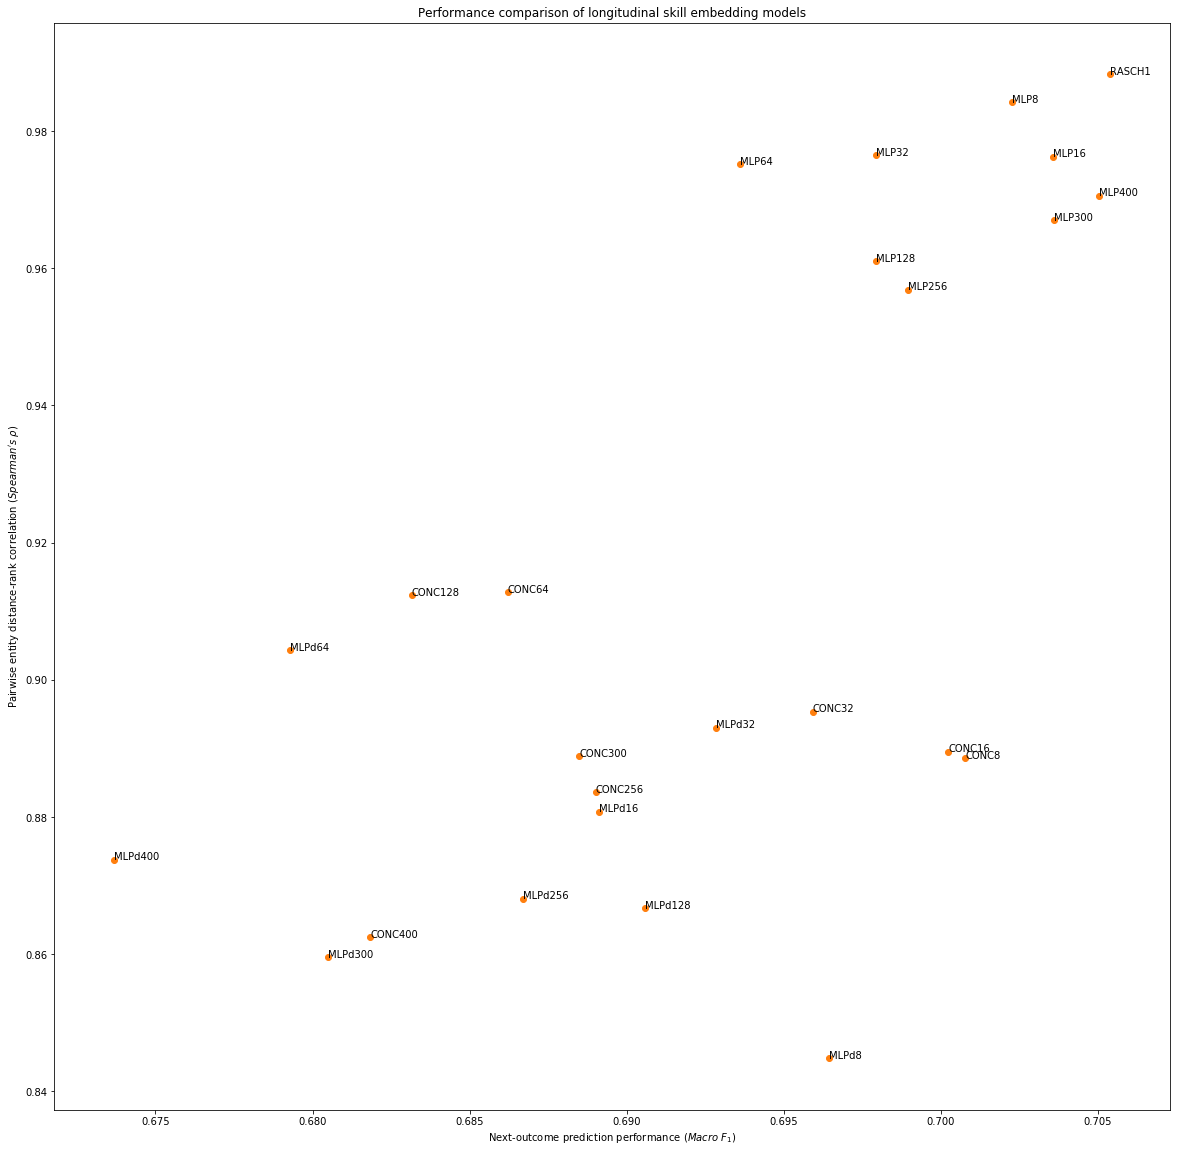

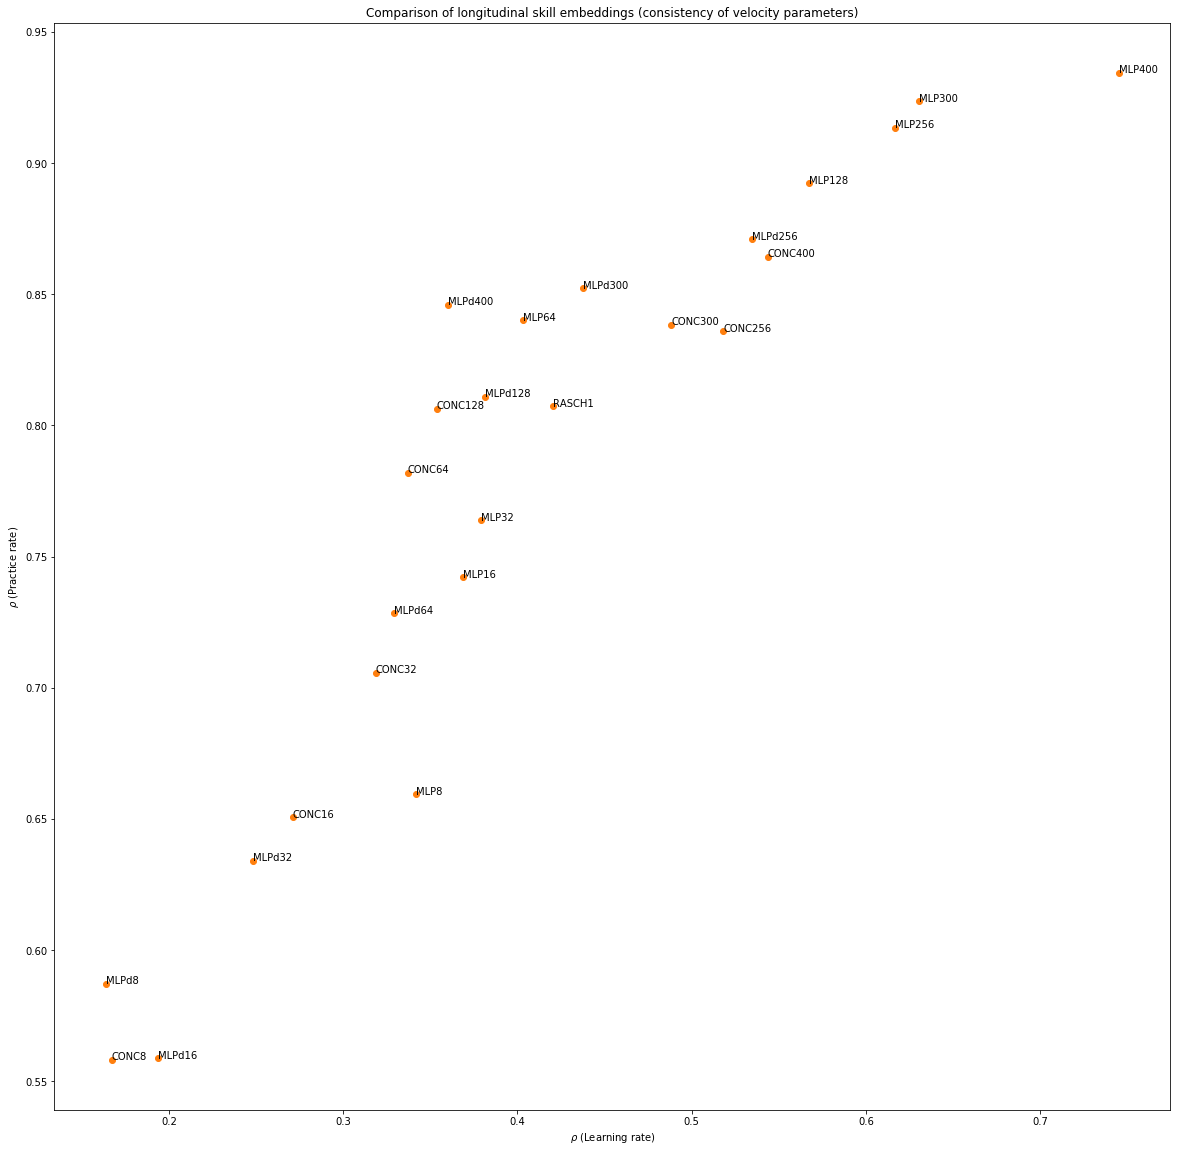

In [173]:
## print(q_cor_df_dict)
print(s_cor_df_dict)

# print(ordered_df)

def order_and_print_val_df(val_df_dict):
    print(val_df_dict)
    var_2 = pandas.DataFrame.from_dict(val_df_dict, orient="index")
    var2 = var_2.sort_values([0],axis=0,ascending=[False])
    print(var2)

    for crit,df, colix in [("By nVar + Var", var2, 0)]:#, ("By Cor", cor2, 0, True)]:
        print(crit,"\\\\")
        for rowix in range(len(var2)):
            print(df.index[rowix],"&", numpy.round(df.iloc[rowix][colix],3),"\\\\")
    #         print(var_df.iloc[rowix][1])
        print()

        
def create_model_comparison_scatter(ordered_df, q_dict, s_dict, labels=None, saveas=None):
    q_df = pandas.DataFrame.from_dict(q_dict, orient="index")
    q_df = q_df.sort_values([0],axis=0, ascending=[False])
    
#     s_df = pandas.DataFrame.from_dict(s_dict, orient="index")
#     s_df = s_df.sort_values([0],axis=0, ascending=[False])
    
    
#     s_scatter_list = []
#     handles_to_plot = list(ordered_df.index)[0:10] + list(q_df.index)[0:10]
    handles_to_plot = list(ordered_df.index) + list(q_df.index)
    handles_to_plot = list(numpy.unique(handles_to_plot))
    
    bal_hands = [ hd for hd in handles_to_plot if "bal" in hd]
    unbal_hands = [ hd for hd in handles_to_plot if "bal" not in hd]

    fig, ax = plt.subplots(figsize=(20,20))
    for handles_to_plot in [bal_hands, unbal_hands]:
        scatter_list = []
        print("len handles to plaot", len(handles_to_plot))
        for hand in handles_to_plot:
    #         if hand not in ordered_df.index:
    #             continue
            if hand not in q_df.index or hand not in ordered_df.index:
                continue
            sco = ordered_df.loc[hand][0]
            q_cor = q_df.loc[hand][0]
            if q_cor > 0 and sco > 0:
                scatter_list.append((hand,sco,q_cor))

        handles_inner = [tup[0] for tup in scatter_list]
        x = [tup[1] for tup in scatter_list]
        y = [tup[2] for tup in scatter_list]
    #     scatter_np = numpy.array(scatter_list)

    #     x = scatter_np[:,1]
    #     y = scatter_np[:,2]
        ax.scatter(x, y)#, labels = ordered_df.index)
        for i,txt in enumerate(handles_inner):
            txt_parts = txt.split("//")
            txt = txt_parts[0]
            if "bal" in txt_parts[1]:
                txt += "/bal"
            ax.annotate(txt, (x[i], y[i]))

    if labels is None:
        title = "Performance comparison of longitudinal skill embedding models"
        xlab = 'Pairwise entity distance-rank correlation ($Spearman\'s\\ \\rho$)'
        ylab = 'Next-outcome prediction performance ($Macro\\ F_1$)'
    else:
        title,xlab,ylab = labels
        
    ax.set_ylabel(xlab)
    ax.set_xlabel(ylab)
    ax.set_title(title)
    if saveas is not None:
        plt.savefig(home+"/images/"+dataset_name+saveas, format="pdf")
#     plt.show()
    return plt.gcf()

print("Q COR DF")
order_and_print_val_df(q_cor_df_dict)
print("S COR DF")
order_and_print_val_df(s_cor_df_dict)
    
    
print(q_cor_df_dict)
    
f1_v_qrho_fig = create_model_comparison_scatter(ordered_df, q_cor_df_dict, None, labels=None, saveas="_model_compare_F1vRho.pdf")
f1_v_qrho_fig.show()

rho_v_rho_fig = create_model_comparison_scatter(pandas.DataFrame.from_dict(n_cor_df_dict, orient="index"), g_cor_df_dict, None, labels=("Comparison of longitudinal skill embeddings (consistency of velocity parameters)", "$\\rho$ (Practice rate)","$\\rho$ (Learning rate)"), saveas="_corr_compare.pdf")
rho_v_rho_fig.show()


In [46]:
print(ordered_df)
# print(s_cor_df_dict)
print("----")   
print(q_cor_df_dict)

                         0         1         2         3         4         5
MLTM128//(xe/px)  0.714473  0.011315  0.737705  0.010273  0.262295  0.010273
RASCH1//(xe/px)   0.705399  0.002340  0.737705  0.001967  0.262295  0.001967
----
{'MLTM128//(xe/px)': [0.9780378299060569, 0], 'RASCH1//(xe/px)': [0.9884267083572688, 0]}


In [174]:
# cor_df = pandas.DataFrame.from_dict(q_cor_df_dict, orient="index")
# s_df = pandas.DataFrame.from_dict(s_cor_df_dict, orient="index")
# g_df = pandas.DataFrame.from_dict(g_cor_df_dict, orient="index")
# n_df = pandas.DataFrame.from_dict(n_cor_df_dict, orient="index")

unified_cor_dict={}
for k in q_cor_df_dict:
    qval = q_cor_df_dict[k][0]
    sval = s_cor_df_dict[k][0]
    gval = g_cor_df_dict[k][0]
#     gval = gval if gval >0 else "N/A"
    nval = n_cor_df_dict[k][0]
    ldval= ld_cor_df_dict[k][0]
    unified_cor_dict[k] = (qval, sval, gval, nval, ldval)

unified_df = pandas.DataFrame.from_dict(unified_cor_dict, orient="index")
# unified_df.columns = ["$\\rho(\\delta)$","$\\rho(\alpha^0)$","$\\rho(\\gamma)$","$\\rho(n)$","$\\rho(\\eta)$"]
unified_df.columns = ["d","a0","g","n","r"]
# print(unified_df)

for coln in unified_df.columns:
    col_series = pandas.to_numeric(unified_df[coln])
    print(coln, col_series.idxmax())

x = unified_df.to_string(header=False,
                  index=True,
                  float_format=lambda x: '%.3f' % x,
                  index_names=False).split('\n')
# out_strs = [' & '.join(ele.split()) for ele in x]
out_strs = ['{} & {} & {} & {} & {} & {}\\\\'.format(*ele.split()) for ele in x]
for s in out_strs:
    print(s)

d RASCH1//(xe/px)
a0 RASCH1//(xe/px)
g MLP400//(xe/px)
n MLP400//(xe/px)
r MLP400//(xe/px)
RASCH1//(xe/px) & 0.988 & 0.918 & 0.807 & 0.420 & 0.443\\
MLP400//(xe/px) & 0.971 & 0.802 & 0.934 & 0.745 & 0.842\\
MLP300//(xe/px) & 0.967 & 0.776 & 0.924 & 0.630 & 0.743\\
MLP16//(xe/px) & 0.976 & 0.785 & 0.742 & 0.369 & 0.473\\
MLP8//(xe/px) & 0.984 & 0.802 & 0.659 & 0.342 & 0.418\\
CONC8//(xe/px) & 0.889 & 0.793 & 0.558 & 0.167 & 0.214\\
CONC16//(xe/px) & 0.890 & 0.861 & 0.651 & 0.271 & 0.431\\
MLP256//(xe/px) & 0.957 & 0.783 & 0.913 & 0.617 & 0.741\\
MLP32//(xe/px) & 0.976 & 0.769 & 0.764 & 0.379 & 0.456\\
MLP128//(xe/px) & 0.961 & 0.765 & 0.892 & 0.567 & 0.709\\
MLPd8//(xe/px) & 0.845 & 0.730 & 0.587 & 0.164 & 0.246\\
CONC32//(xe/px) & 0.895 & 0.883 & 0.706 & 0.319 & 0.495\\
MLP64//(xe/px) & 0.975 & 0.750 & 0.840 & 0.403 & 0.504\\
MLPd32//(xe/px) & 0.893 & 0.806 & 0.634 & 0.248 & 0.347\\
MLPd128//(xe/px) & 0.867 & 0.849 & 0.811 & 0.381 & 0.542\\
MLPd16//(xe/px) & 0.881 & 0.800 & 0.559 & 0.1

In [48]:
done_comps = set()
stress_list = []

In [210]:
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import distance_matrix
# amx = build_adjacency_matrix(qs)

# this_handle = "MLTMb8//(xe/f1)"
this_handle = "MLTM128//(xe/px)"
# this_handle = "MLTMa400//(xe/f1)"
m_list = model_lookup[this_handle]

this_m = None
# best_score = sc
# best_handle = handle
best_metric = 0
print("Running models from m_list")
for fnm_ in m_list:
#     print(fnm_)
    m_ = keras.models.load_model(fnm_, custom_objects={'WeightClip': WeightClip}, compile=False)
    p_probs = m_.predict( [t_qixs, t_sixs, t_hits] )
    p_hats = numpy.round( p_probs )
    t_f1 = f1_score(t_out, p_hats, average="macro")
    if t_f1 > best_metric:
        print("new best", this_handle,"f1=",t_f1)
        best_metric = t_f1
        this_m = m_


# qs_fake = numpy.random.randint(0,5, size=(10,5))
# amx = euclidean_distances(qs, Y=None, Y_norm_squared=None, squared=False, X_norm_squared=None)
# amx = distance_matrix(qs_fake, qs_fake)
qs = this_m.get_layer("qn_embedding").get_weights()[0]
# qs_temp = qs
# amx = distance_matrix(qs_temp, qs_temp)
# print(amx.shape)
# for row in amx[0:10]:
#     print(row)

qs = _retrieve_peda_params(this_m, "qn_embedding")
# ds = _retrieve_peda_params(this_m, "qn_embedding", aux_layers=["skill_diffs"])
#     elif config == "students":
a0s = _retrieve_peda_params(this_m, "alphas")
#     elif config == "practice_loadings":
rs = _retrieve_peda_params(this_m, "qk_loadings")
#     elif config == "practice_rates":
# delta_as = _retrieve_peda_params(this_m, "qk_loadings", avg_layer="gammas")
#     elif config == "learning_rates":
gs = _retrieve_peda_params(this_m, "gammas")#, avg_layer="qk_loadings")


print(qs)
print(rs)



Running models from m_list
new best MLTM128//(xe/px) f1= 0.7328647143370464
new best MLTM128//(xe/px) f1= 0.7359129192951681
getting main layer qn_embedding
main layer shape (1134, 128)
getting main layer alphas
main layer shape (1234, 128)
getting main layer qk_loadings
main layer shape (1134, 128)
getting main layer gammas
main layer shape (1234, 128)
[[5.2815146 4.5020623 5.042121  ... 3.970045  6.052665  5.847426 ]
 [4.780136  3.8170254 4.794538  ... 4.3099093 5.0409684 5.1431603]
 [5.4259415 5.406825  5.264112  ... 4.960782  5.786099  6.0385137]
 ...
 [4.997946  4.1999235 5.302014  ... 5.0982547 5.242781  5.321708 ]
 [5.3212357 5.30505   5.448271  ... 5.595817  5.1526146 5.3044314]
 [5.2968884 5.5399613 5.367236  ... 5.546044  5.3219457 5.4235854]]
[[ 0.18920216 -0.12600933 -0.36710235 ...  0.10765259 -0.16690907
  -0.09813281]
 [ 0.41369268 -0.18037634 -0.3563627  ...  0.21101363  0.44183508
   0.42627102]
 [ 0.41120684 -0.28230006 -0.35158166 ...  0.15827763  0.42405587
   0.508

In [213]:
# cand_comps = [n for n in list(range(1,10)) +[12,15,17,23,27,35]]#+ list(range(40, 128, 10))]
#cand_comps = [n for n in [1,2,4,8,12,16,24,32,40,48,56,64,96,128,192,256]]# list(range(50, 310, 10))]
# cand_comps = []
cand_comps =[1] + list(range(10,128,10))
print(cand_comps)

# raise Exception("e")

# weights_list = [qs, a0s, rs, gs]
# keys_list = ["q-matrix","a0s","prac load.r", "gammas"]

keys_list = ["student_weights","question_weights","learning","practice"]
# weights_list = [ numpy.concatenate([a0s,gs], axis=1), numpy.concatenate([qs,rs], axis=1) ]
weights_list = [ a0s,gs, qs,rs ]

stress_list_list = []
plt.figure(figsize=(10,10))
for wk,ws in zip(keys_list, weights_list):
    print(wk, ws.shape)
    stress_list = []
    
    for ix,x in enumerate(cand_comps):
#         if x in done_comps:
#             print(x,"is seen")
#             continue
#         done_comps.add(x)
#         pca = PCA(n_components=x)
#         pws = pca.fit_transform(ws)
        mds = MDS(n_components=x, metric=True, dissimilarity='euclidean', n_jobs=-1)
#         try:
        mds.fit(ws.astype(numpy.float64))
#         except:
#             print("fxud")
        stress = mds.stress_
        stress_list.insert(ix,stress)
    # print(xys)
    print(cand_comps)
    print(stress_list)
    # plt.scatter(x=xys[:,0], y=xys[:,1])
    # plt.scatter(x=cand_comps, y=stress_list)
#     plt.plot(cand_comps, stress_list, label=wk)

        # y256 = stress_list[cand_comps.index(256)]
        # plt.axhline(y=y256, color='r', linestyle='-')
    stress_list_list.append(stress_list)

[1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]
student_weights (1234, 128)


/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is depr

[1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]
[2149517.2103526923, 15755.879997418422, 7561.574519427348, 5117.1333395711945, 4072.5311624109027, 3404.46843867322, 2911.8140315680853, 2688.007916145966, 2438.1773826377375, 2263.7888414629274, 2107.064459326057, 2047.8310589110101, 1934.5413798899522]
question_weights (1234, 128)


/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is depr

[1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]
[595356.2696063137, 11393.877203421584, 5362.850165525954, 3588.074039537499, 2754.2540345017196, 2309.384066134376, 1995.476271378274, 1801.0710432586784, 1654.6018854254373, 1550.6928141583455, 1446.5402419776515, 1373.0974529850098, 1323.2724475165735]
learning (1134, 128)


/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is depr

[1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]
[12459776.354869679, 136558.1332517359, 59217.83564827824, 37866.092873429036, 29258.780309140006, 24818.925618738518, 21215.485647599908, 19035.34528326036, 17540.64619450792, 16437.50880290054, 15456.864011513477, 14622.079373389972, 13951.44344142958]
practice (1134, 128)


/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is depr

[1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]
[1640723.7677040424, 38653.83948014101, 13713.507895825944, 8139.183567159724, 5974.999537453226, 4852.6235979483845, 4080.6730566471165, 3645.062547105988, 3258.5838775402312, 3137.0374165000762, 2895.111281821261, 2761.667778701865, 2620.2842998090605]


[2149517.2103526923, 15755.879997418422, 7561.574519427348, 5117.1333395711945, 4072.5311624109027, 3404.46843867322, 2911.8140315680853, 2688.007916145966, 2438.1773826377375, 2263.7888414629274, 2107.064459326057, 2047.8310589110101, 1934.5413798899522]
[595356.2696063137, 11393.877203421584, 5362.850165525954, 3588.074039537499, 2754.2540345017196, 2309.384066134376, 1995.476271378274, 1801.0710432586784, 1654.6018854254373, 1550.6928141583455, 1446.5402419776515, 1373.0974529850098, 1323.2724475165735]
[12459776.354869679, 136558.1332517359, 59217.83564827824, 37866.092873429036, 29258.780309140006, 24818.925618738518, 21215.485647599908, 19035.34528326036, 17540.64619450792, 16437.50880290054, 15456.864011513477, 14622.079373389972, 13951.44344142958]
[1640723.7677040424, 38653.83948014101, 13713.507895825944, 8139.183567159724, 5974.999537453226, 4852.6235979483845, 4080.6730566471165, 3645.062547105988, 3258.5838775402312, 3137.0374165000762, 2895.111281821261, 2761.667778701865

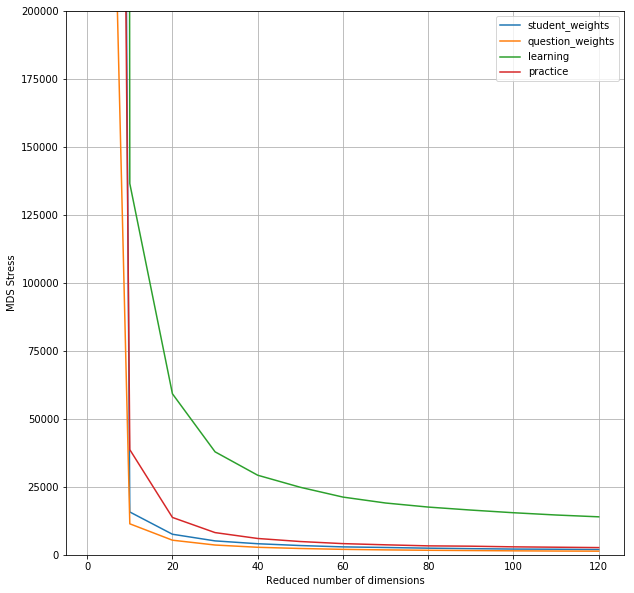

In [217]:
plt.figure(figsize=(10,10))
offset = 0
for sl,wk in zip(stress_list_list, keys_list):
    print(sl)
    plt.plot(cand_comps, numpy.array(sl)+offset, label=wk)
    offset+=10

plt.ylim(0.0,200000)
plt.grid()
plt.legend()
plt.ylabel("MDS Stress")
plt.xlabel("Reduced number of dimensions")
plt.show()
        
# xys = mds.fit_transform(amx)
# del amx

In [ ]:
#rankin.append( (avg_f1, std_f1, avg_acc, std_acc, avg_mae, std_mae, handle) ) 
xs, ys, ups, los = [],[],[],[]
handle_filter = "MLTM"
for tup in rankin:
#     handle = tup[-1]
    if not handle.startswith(handle_filter):
        continue
    if "bal" not in handle:
        continue
    print(handle)
    w = int(handle.split("/")[0][len(handle_filter):])
    y = tup[0]
    s = tup[1]
    xs.append(w)
    ys.append(y)
    ups.append(y+s)
    los.append(y-s)
xs,ys,ups,los = zip(*sorted(zip(xs, ys, ups, los)))

plt.plot(xs,ys)
plt.plot(xs,ups, linestyle="--")
plt.plot(xs,los, linestyle="--")
plt.title("ExamLift(B1) - Effect of embedding width on prediction ({})".format(handle_filter))
plt.xlabel("Embedding width")
plt.ylabel("$F_{1}$ score")
plt.show()

MLP:w32/qNone/val_f1_m/bal & 0.722 (0.01066) & 0.736 (0.01128) & 0.264 (0.01128) \\
MLP:w32/qNone/val_f1_m & 0.711 (0.00962) & 0.727 (0.00913) & 0.273 (0.00913) \\

MLP:w32/qNone/val_mean_absolute_error & 0.705 (0.00485) & 0.721 (0.00382) & 0.279 (0.00382) \\
MLP:w32/qNone/val_mean_absolute_error/bal & 0.703 (0.00599) & 0.717 (0.00525) & 0.283 (0.00525) \\
MLP:w32/qNone/val_f1_m/bal

In [ ]:
do_plot=True

plt.figure(figsize=(8,8))

for item in history_results:
    #     best_x = range(len(v_acc))[-11]
    #     plt.ylim(0,1)
    if do_plot:
        plt.plot(plot_acc, label="{} (val acc) {}".format(cog_model, emb_w))
        plt.annotate("{} (val acc) {}".format(cog_model, emb_w), (len(plot_acc), plot_acc[-1]))
    #     plt.axvline(x=best_x, ymax=max(v_acc), linestyle="--")
    #     plt.plot(plot_acc, label="{} (trn loss)".format(min_h))
    #     plt.plot(plot_loss, linestyle="--", label="{} (val loss)".format(min_h))
    #     plt.plot(plot_mse, linestyle="-", label="{}".format(cog_model))
    #     plt.plot(plot_loss, linestyle="--", label="{} (loss)".format(cog_model))
    #     plt.legend(title="Cognitive Model")
    #     plt.ylabel("Validation Mean Absolute Error (Val MAE)")
        plt.ylabel("Validation Accuracy")
        plt.xlabel("Number of epochs")
        plt.title("Training of different cognitive models (Exam Lift (B1))")

#     print("**", max_mod, max_acc, min_loss, min_mse)
#     m = best_m
plt.legend()
plt.show()

In [ ]:
# def step_through_q_weights(sixs, qixs, hout):
# #     cog_models = ["MLP", "MLP+","MLTM","LFA","SLFA"]
# #     cog_models = ["MLP", "MLP+","MLTM", "MLTM+", "MLTM_no_init", "LFA","SLFA"]
#     cog_models = ["MLTM+", "MLTM+Pow"]#, "LFA", "SLFA"]
#     q_weights = [None, 1,10,100,1000 ]# [1,2,4,6,8,10,12,14,16]
#     payload = []
#     odata, vdata, tdata, sid_six_lookup, qid_qix_lookup = split_next_step(sixs, qixs, hout, 
#                                                               max_students = 100000,
#                                                               min_hist = 40,
#                                                               max_hist = None)#, alternate=True, balance_training=False)
#     for cog_model in cog_models:
#         for qw in q_weights:
#             (o_sixs, o_qixs, o_hits, o_out), (v_sixs, v_qixs, v_hits, v_out), (t_sixs, t_qixs, t_hits, t_out) = (odata, vdata, tdata)
# #             n_students = max(o_sixs)+1
#             m, h, config_dict = gen_and_train(odata, vdata, cog_model=cog_model, q_weight=qw, emb_w=14)
#             config_dict["q_weight"] = qw
#             payload.append( (config_dict, m, h) )
#     return payload, (odata, vdata, tdata)
            

# (sixs, qixs, hout) = pickle.load(open(home+"/real_data/XL1041.p", "rb"))
# history_results, (o_data, v_data, t_data) = step_through_q_weights(sixs, qixs, hout)

# # print(o_data.shape)
# # print(v_data.shape)
# # print(t_data.shape)

# do_plot = True
# if do_plot:
#     plt.figure(figsize=(8,8))
#     for item in history_results:
#         config_dict, m, h = item
#         cog_model = config_dict["cog_model"]
#         emb_w = config_dict["emb_w"]
#         q_weight = config_dict["q_weight"]

#         v_loss = h.history["val_loss"]
#         v_acc  = h.history["val_accuracy"]
#         v_mse   = h.history["val_mean_absolute_error"]
#         o_loss   = h.history["loss"]
#         o_acc    = h.history["accuracy"]
#         o_mse    = h.history["mean_absolute_error"]
#         plot_acc = v_acc[0:-10]
#         plot_loss = v_loss[0:-10]
#         plot_mse = v_mse[0:-10]
#     #     plt.plot(plot_acc, label="{} (val acc)".format(min_h))
#     #     plt.plot(plot_acc, label="{} (trn loss)".format(min_h))
#     #     plt.ylim(0.45,1)
#         to_plot = plot_loss
#         plt.plot(to_plot, linestyle="-", label="{} (val loss)".format(q_weight))
#         plt.annotate("{} {}".format(cog_model, q_weight), (len(to_plot), to_plot[-1]))
#     #     plt.plot(plot_mse, linestyle="-", label="{}".format(min_h))
#     #     plt.legend(title="Q-gate weight")
#         plt.ylabel("Validation Mean Absolute Error (Val MAE)")
#         plt.xlabel("Number of epochs")
#         plt.title("Effect of q-gate tolerance on training (Exam Lift (B1), MLP w=10)")
        
        
        

In [ ]:
# process_history_results(history_results, o_data, t_data)



MLTM+ 14 10 & 0.73 & 0.27 \\
LFA 14 None & 0.73 & 0.27 \\
SLFA 14 1000 & 0.72 & 0.28 \\
SLFA 14 10 & 0.72 & 0.28 \\
SLFA 14 None & 0.72 & 0.28 \\
SLFA 14 100 & 0.72 & 0.28 \\
LFA 14 10 & 0.72 & 0.28 \\
MLTM+ 14 100 & 0.72 & 0.28 \\
SLFA 14 1 & 0.72 & 0.28 \\
MLTM+ 14 1000 & 0.72 & 0.28 \\
LFA 14 1 & 0.71 & 0.29 \\
LFA 14 1000 & 0.71 & 0.29 \\
LFA 14 100 & 0.71 & 0.29 \\
MLTM+ 14 1 & 0.7 & 0.3 \\
MLTM+ 14 None & 0.69 & 0.31 \\

In [ ]:
# for item in history_results:
# #     config_dict, m, h = item
#     config_dict, m, h = item
#     cog_model = config_dict["cog_model"]
#     emb_w = config_dict["emb_w"]
#     run_acc_mae_test(m, o_data, t_data, config_dict)

In [ ]:
# def step_through_history_lengths(sixs, qixs, hout):
#     min_hists = [35,40,45,50,60, ]
#     max_hists = [None,]
#     payload = []
#     for min_h in min_hists:
#         for max_h in max_hists:
#             odata, vdata, tdata, sid_six_lookup, qid_qix_lookup = split_next_step(sixs, qixs, hout, 
#                                                                           max_students = 100000,
#                                                                           min_hist = min_h,
#                                                                           max_hist = max_h)#, alternate=True, balance_training=False)
#             (o_sixs, o_qixs, o_hits, o_out), (v_sixs, v_qixs, v_hits, v_out), (t_sixs, t_qixs, t_hits, t_out) = (odata, vdata, tdata)
#             m, h, _ = gen_and_train(odata, vdata, emb_w=14)
#             payload.append( (min_h, max_h, m, h) )
#     return payload
            
# (sixs, qixs, hout) = pickle.load(open(home+"/real_data/XL1041.p", "rb"))
# history_results = step_through_history_lengths(sixs, qixs, hout)

# plt.figure(figsize=(8,8))
# for item in history_results:
#     min_h, max_h, m, h = item
#     v_loss = h.history["val_loss"]
#     v_acc  = h.history["val_accuracy"]
#     v_mse   = h.history["val_mean_absolute_error"]
#     o_loss   = h.history["loss"]
#     o_acc    = h.history["accuracy"]
#     o_mse    = h.history["mean_absolute_error"]
#     plot_acc = v_acc[0:-10]
#     plot_loss = v_loss[0:-10]
#     plot_mse = v_mse[0:-10]
# #     plt.plot(plot_acc, label="{} (val acc)".format(min_h))
# #     plt.plot(plot_acc, label="{} (trn loss)".format(min_h))
#     plt.plot(plot_loss, linestyle="--", label="{} (val loss)".format(min_h))
# #     plt.plot(plot_mse, linestyle="-", label="{}".format(min_h))
#     plt.legend(title="Min. Qns. Answered")
#     plt.ylabel("Validation Mean Absolute Error (Val MAE)")
#     plt.xlabel("Number of epochs")
#     plt.title("Effect of removing short user histories on training (Exam Lift (B1), MLP w=10)")

In [ ]:
pickle.dump(((o_sixs, o_qixs, o_chits, o_out), (v_sixs, v_qixs, v_chits, v_out), (t_sixs, t_qixs, t_chits, t_out)), open(home+"/my_shitty_dataset.p", "wb"))
# o_chits, v_chits, t_chits = None, None, None

In [ ]:
# import gc, zlib

# ((o_sixs, o_qixs, o_chits, o_out), (v_sixs, v_qixs, v_chits, v_out), (t_sixs, t_qixs, t_chits, t_out)) = pickle.load(open(home+"/my_shitty_dataset.p", "rb"))

# print(o_chits [0:10])

# # raise Exception("on purpose")
# # def uncomp(chits):
# #   for hix, chrow in enumerate(chits):
# #     chits[hix] = pickle.loads(zlib.decompress(chrow))
# #   chits = numpy.array(chits, dtype="uint8")
# #   return chits
      
# # print("uncomping")
# # o_hits = uncomp(o_chits)
# # v_hits = uncomp(v_chits)
# # t_hits = uncomp(t_chits)
# # print("straight outta comp-ton")

# o_hits = numpy.array(o_chits)
# v_hits = numpy.array(v_chits)
# t_hits = numpy.array(t_chits)

# o_chits, v_chits, t_chits = None, None, None


In [ ]:
strat = [ numpy.random.choice([0,1], size=t_out.shape, p=[1/3.47,2.47/3.47]) for _ in range(100)]
rands = [ numpy.random.choice([0,1], size=t_out.shape) for _ in range(100)]

print("Baseline F1s")
print(f1_score(numpy.ones_like(t_out), t_out, average="macro"))
print(numpy.mean( [ f1_score(ayn, t_out, average="macro") for ayn in rands ] ))
print(numpy.mean( [ f1_score(s,   t_out, average="macro") for s in strat   ] ))
print("MAEs")
print(float(mean_absolute_error(numpy.ones_like(t_out), t_out)))
print(numpy.mean( [ mean_absolute_error(ayn, t_out) for ayn in rands ] ))
print(numpy.mean( [ mean_absolute_error(s,   t_out) for s in strat   ] ))

del strat
del rands

In [ ]:
min_mae = math.inf
best_w = 0

In [ ]:
print(t_sixs)
print(len(numpy.unique(t_sixs)))
print(len(numpy.unique(t_qixs)))

In [ ]:
for ix,row in enumerate(mapping.iterrows()):
    print(ix, row[0])

In [ ]:
def draw_estimated_learning_curves(m, s_index, sixs, qixs, hits, obs=None, lookup=None):
  # plt.figure(figsize=(10,10))
  max_hist = 200 #int(numpy.max(hits))
  # for s in numpy.unique(sixs):
  bag_o_qixs = numpy.unique(qixs).reshape(-1,1)
  numpy.random.seed(666)
  numpy.random.shuffle(bag_o_qixs)

  for s in [s_index, ]:
    sel_indices = (sixs==s).ravel()
    # _qixs = qixs[sel_indices].reshape(-1,1) # (N-rows x 1-feat)  i.e. [ [q0], [q1], ...  [qN] ]
    _hits = hits[sel_indices]
    _sixs = numpy.array([s] * len(_hits)).reshape(-1,1)
    
    plt.figure(figsize=(25,10))
    ax = plt.gca()

    num_of_plots = 25
    ys_of_ys = []

    for qix in bag_o_qixs[0: num_of_plots]:
        qix = int(qix)
        _qixs = numpy.ones_like(_sixs)*qix
        results = m.predict([_qixs, _sixs, _hits])#.ravel()
        xs = list(range(len(_sixs)))
        ys = results.ravel()
        ys_of_ys.append(ys)
        ax.plot(xs[0:max_hist],ys[0:max_hist], alpha=0.5)
        last_x = min(xs[-1], max_hist)
        qn_id = lookup.iloc[qix].qn_id
        ax.annotate("{} {}".format(int(qix), qn_id), (last_x, ys[last_x]-0.005 ))
#         if not (obs is None):
#             final = int(obs[sel_indices][to_plot][-1])
#             if final:
#                 ax.axvline(_hits[to_plot, qix][-1], alpha=0.5, c="black", linestyle="--")

    ax.plot(xs,numpy.mean(ys_of_ys, axis=0), c="black", linestyle="--")


    plt.ylim((0.0, 1.0))
    plt.xlim((0.0, max_hist+2))
    plt.title("Student {}".format(s))
    plt.show()

# print(o_hits.shape)
# print(t_hits.shape)
# all_sixs = numpy.concatenate((o_sixs, t_sixs), axis=0)
# all_qixs = numpy.concatenate((o_qixs, t_qixs), axis=0)
# all_hits = numpy.concatenate((o_hits, t_hits), axis=0)
all_sixs = o_sixs
all_qixs = o_qixs
all_hits = o_hits

# numpy.set_printoptions(threshold=10000)
# print(all_hits.shape)
# for hrow, qx in zip(all_hits[0:50], all_qixs[0:50]):
#   print(qx, hrow)

print(numpy.max(numpy.sum(all_hits, axis=1)))

print(len(numpy.unique(all_qixs)))
print(len(numpy.unique(all_sixs)))

for s_index in numpy.unique(t_sixs)[0:50]:
    s_index = int(s_index)
    draw_estimated_learning_curves(m, s_index, all_sixs, all_qixs, all_hits, obs=None, lookup=mapping)

In [ ]:
# qk_loadings = m.get_weights()
# for w in qk_loadings:
#     print(w.shape)
# print(qk_loadings.shape)

Lws = m.get_weights()[1]
Lbs = m.get_weights()[2]

qk_loadings = Lws #+ Lbs
print(qk_loadings.shape)
print(qk_loadings[0:10, :])

In [ ]:
from keras import Model
qk_loadings = this_m.get_layer("qk_loadings").get_weights()[0]
print(qk_loadings)

this_m.summary()
# w = qk_loadings.shape[0]
uniq_qixs = numpy.unique(list(qid_qix_lookup.values()))
print(uniq_qixs)
zer0s = [0] * len(uniq_qixs)
for qix in uniq_qixs:
    zer0s[qix] = 1
    intermediate_layer_model = Model(inputs=this_m.input,
                          outputs=this_m.get_layer("qk_loadings").output)
    practice_output = intermediate_layer_model.predict([[0],[0], [zer0s]])
    print(practice_output)
    zer0s[qix] = 0
    

In [59]:
    col_map = {
        "reading":"red",
        "writing":"yellow",
        "listening":"green",
        "speaking":"blue"
    }

    low_col_map = {
      'error finding': '#ffff00', 
      'spelling': '#bbbb00', 

      'phrasal verbs': '#ff0000', 
      'speed reading': '#bb0000', 
      'text matching': '#770000',

      'dialogue': '#0000ff', 
      'topic associations': '#0000bb', 

      'minimal pairs': '#00bb00', 
      'topic match': '#007700', 
     }

    low_shape_map = {
      'error finding': 'o', 
      'spelling': 's', 

      'phrasal verbs': 'o', 
      'speed reading': 's', 
      'text matching': '*',

      'dialogue': 'o', 
      'topic associations': 's', 

      'minimal pairs': 'o', 
      'topic match': '^', 
     }

    low_short_map = {
      'error finding': 'WEF', 
      'spelling': 'WSP', 

      'phrasal verbs': 'RPV', 
      'speed reading': 'RSR', 
      'text matching': 'RTM',

      'dialogue': 'SDI', 
      'topic associations': 'STA', 

      'minimal pairs': 'LMP', 
      'topic match': 'LTM', 
     }
    

defaultdict(<class 'list'>, {'RASCH1//(xe/px)': ['./models/RASCH1~~(xe~px)_0', './models/RASCH1~~(xe~px)_1', './models/RASCH1~~(xe~px)_2', './models/RASCH1~~(xe~px)_3', './models/RASCH1~~(xe~px)_4', './models/RASCH1~~(xe~px)_5', './models/RASCH1~~(xe~px)_6', './models/RASCH1~~(xe~px)_7', './models/RASCH1~~(xe~px)_8', './models/RASCH1~~(xe~px)_9'], 'MLTMl64//(xe/px)': ['./models/MLTMl64~~(xe~px)_0', './models/MLTMl64~~(xe~px)_1', './models/MLTMl64~~(xe~px)_2', './models/MLTMl64~~(xe~px)_3', './models/MLTMl64~~(xe~px)_4', './models/MLTMl64~~(xe~px)_5'], 'MLTMl128//(xe/px)': ['./models/MLTMl128~~(xe~px)_0', './models/MLTMl128~~(xe~px)_1', './models/MLTMl128~~(xe~px)_2', './models/MLTMl128~~(xe~px)_3', './models/MLTMl128~~(xe~px)_4']})
Running models from m_list
new best MLTMl64//(xe/px) f1= 0.7228580301583833
new best MLTMl64//(xe/px) f1= 0.7335035460992909
Model: "model_966"
__________________________________________________________________________________________________
Layer (type)   

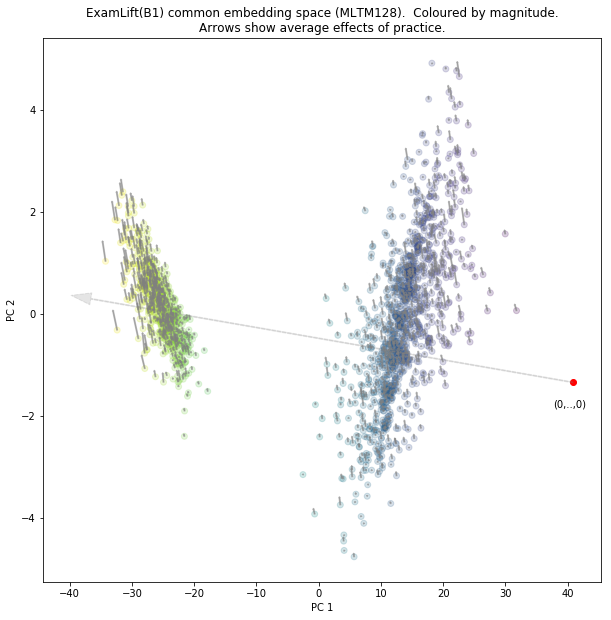

endhhape, gammas (610, 64)


In [291]:
# psychomode = config_dict["cog_model"]
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# sig = lambda z: (1 / (1+numpy.exp(-z)))

all_sixs = set()
all_sixs.update(list(o_sixs))
all_sixs.update(list(v_sixs))
all_sixs.update(list(t_sixs))
all_sixs=list(all_sixs)

print(model_lookup)

# this_handle = "MLTM256//(xe/xe)"
this_handle = "MLTMl64//(xe/px)"
# this_handle = "MLTMa400//(xe/f1)"
m_list = model_lookup[this_handle]

this_m = None
best_metric = 0
print("Running models from m_list")
for fnm_ in m_list:
    try:
        m_ = keras.models.load_model(fnm_, custom_objects={'WeightClip': WeightClip}, compile=False)
    except:
        continue
    p_probs = m_.predict( [t_qixs, t_sixs, t_hits] )
    p_hats = numpy.round( p_probs )
    t_f1 = f1_score(t_out, p_hats, average="macro")
    if t_f1 > best_metric:
        print("new best", this_handle,"f1=",t_f1)
        best_metric = t_f1
        this_m = m_

plot_arrows = True

for cluster_handle, cluster_m in [(this_handle, this_m), ]:
    this_m.summary()
    try:
        skill_diffs = cluster_m.get_layer("skill_diffs").get_weights()[0]
        skill_amp = cluster_m.get_layer("qn_embedding").get_weights()[0]
        assert skill_diffs.shape[1] == skill_amp.shape[1]
        if this_handle.startswith("MLTMb"):
            qs = skill_amp # numpy.pow(skill_diffs, skill_amp)
        else:
            qs = numpy.multiply(skill_diffs, skill_amp)
    except:
        qs = cluster_m.get_layer("qn_embedding").get_weights()[0]
        print("skill difs not found")
    
    practice_loadings = None
#     has_practice_loadings = False
    try:
        gammas = cluster_m.get_layer("gammas").get_weights()[0]
        avg_gammas = numpy.mean(gammas, axis=0)
#         print("gam shp", gammas.shape)
#         print("av gam shp", avg_gammas.shape)

        practice_loadings = cluster_m.get_layer("qk_loadings").get_weights()[0]
        avg_ld = numpy.mean(practice_loadings, axis=0)
#         print("av g", avg_gammas)
#         print("sd g", numpy.std(gammas, axis=0))
        alphas = cluster_m.get_layer("alphas").get_weights()[0]
#         min_ld = numpy.min(practice_loadings, axis=0)
        
#         print("avav ld", numpy.mean(avg_ld))
#         print("av ld", avg_ld)
#         print("sd ld", numpy.std(practice_loadings, axis=0))
#         avg_ld = (min_ld + max_ld)/2.0
#         print(avg_ld.shape)
#         print(avg_ld)
        practice_loadings = numpy.multiply(practice_loadings, avg_gammas)
    
        print("WANG")
        print(gammas)
        print(avg_ld)
        gammas = numpy.multiply(gammas, avg_ld)
        print(gammas)
        
        gammas = gammas[all_sixs,:]
        alphas = alphas[all_sixs,:]
    except:
        print("doesn't have practice loadings")
        
    print("wtf gam ", gammas.shape)
        
#     arrow_scaler = 1
    st_arrowheads = alphas+ gammas
    qn_arrowheads = qs+practice_loadings
        
    print(qs.shape)
    qidz = [q for q in range(len(qs))]

    qix_qid_lookup = {}
    for k,v in qid_qix_lookup.items():
        qix_qid_lookup[v] = k

    mapping.dropna(inplace=True)
    catz = [mapping.loc[qix_qid_lookup[qid]].activity_skill for qid in qidz]

#     post_prac = qs + practice_loadings
    xero = numpy.array([[0] * qs.shape[1]])
#     wone = numpy.array([[1] * qs.shape[1]])

    
    combo_weights = numpy.concatenate([alphas, qs]) 
    origin = numpy.min(combo_weights) 
    combo_weights = combo_weights - origin
    maxx = numpy.max(alphas) - origin
    maxx = float(maxx)
    maxx = [[maxx] * alphas.shape[1]]
    combo_weights = numpy.concatenate([xero, maxx, combo_weights])
    print("combo wgt median", numpy.median(combo_weights))
    print("combo wgt min", numpy.min(combo_weights))
    arrowheads = numpy.concatenate([st_arrowheads, qn_arrowheads]) - origin
    arrowheads = numpy.concatenate([xero, maxx, arrowheads])
    
    
#     print("combo min", numpy.min(combo_weights))
#     combo_weights = numpy.concatenate([xero, combo_weights])
    
#     scaler = StandardScaler()
#     combo_weights = scaler.fit_transform(combo_weights)
    dim_red = PCA(n_components=2)
#     dim_red = TSNE(n_components=2)
#     dim_red = MDS(n_components=2, metric=True)
    txd = dim_red.fit_transform(numpy.concatenate([combo_weights,arrowheads]))
    basis = txd[0:len(combo_weights)] #dim_red.fit_transform(combo_weights)
    arras = txd[len(combo_weights):] #dim_red.transform(arrowheads)
#     xerod = dim_red.transform(xero)

#     for b,a in zip(basis, arras):
#         print(a-b) # print the arrow vector itself (not the pos/n vector)

    assert numpy.isnan(numpy.sum(basis))==False

    norms = numpy.linalg.norm(combo_weights[2:], axis=1)
#     arrow_deltas = arrowheads-combo_weights
    arrow_norms = numpy.linalg.norm(arrowheads-combo_weights, axis=1)
#     for ix,an in enumerate(arrow_norms[2:]):
#         if ix < len(st_arrowheads):
#             print("S-> ", an)
#         else:
#             print("Q-> ", an)

#     arrow_norms = numpy.linalg.norm((arrowheads-combo_weights)[0:len(qs)], axis=1)
#     arrow_norms = numpy.linalg.norm((arrowheads-combo_weights)[len(qs):], axis=1)

    plt.figure(figsize=(10,10))
    ax = plt.gca()
    if plot_arrows:
        xs = basis[2:,0]
        ys = basis[2:,1]
        xs_end = arras[2:,0]
        ys_end = arras[2:,1]

        opt = dict(color="gray",
            ls="solid",
            width=1,
            headwidth=1.5,
            headlength=1,
            alpha=0.5,
            connectionstyle = 'arc3,rad=0')
        for x,y,endx,endy in zip(xs,ys,xs_end,ys_end):
#             print(x,y,endx,endy)
#             dx = endx-x
#             dy = endy-y
#             print("arrow", dx,dy)
#             if dy<0:
            ax.annotate('', xycoords='data', xy=(endx,endy), xytext=(x,y), arrowprops=opt)    
#     ax.annotate('(0,..,0)', xycoords='data', xytext=(basis[0,0]-0.5, basis[0,1]-0.5), arrowprops=opt)
    ax.text(basis[0,0]-0.5, basis[0,1]-0.5, '(0,..,0)', ha="center")
    plt.scatter(basis[2:,0], basis[2:,1], c=norms, alpha=0.2)
    plt.scatter(basis[0,0], basis[0,1], c="red", alpha=1)
    plt.scatter(basis[1,0], basis[1,1], c="white", alpha=1)
    opt = dict(color="gray",
        ls="dashed",
        width=1,
        headwidth=12,
        headlength=20,
        alpha=0.2,
        connectionstyle = 'arc3,rad=0')
    ax.annotate('', xycoords='data', xy=basis[1], xytext=basis[0], arrowprops=opt)    
#     plt.scatter(arras[:,0], arras[:,1], c=arrow_norms, alpha=0.5)
#     plt.scatter(xerod[0], xerod[0], c="red")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title("ExamLift(B1) common embedding space (MLTM128).  Coloured by magnitude.\nArrows show average effects of practice.".format(cluster_handle))
    plt.savefig(home+"/images/"+dataset_name+"_univ_practice_vecs.pdf", format="pdf")
    plt.show()
    
    
    print("endhhape, gammas", gammas.shape)

In [293]:
from sklearn.manifold import MDS
def plot_practice(ws, prac_vecs, sprinkles=None, plot_arrows=True, plot_qgroups=False, entity_type="item", graph_title="Embedding Space plot."):
    arrowheads = ws+prac_vecs
    
#     if sprinkles == "indices":
#         pass
#     elif sprinkles:
#         (oixs,vixs,tixs),(on,vn,tn) = sprinkles
#         oixs = numpy.unique(oixs)
#         vixs = numpy.unique(vixs)
#         tixs = numpy.unique(tixs)
# #         max_ix = len(ws)-1
#         all_poss_ixs = range(len(ws))
#         all_ixs = set()
#         all_ixs.update(list(oixs))
#         all_ixs.update(list(vixs))
#         all_ixs.update(list(tixs))
#         

#     (oixs,vixs,tixs),(on,vn,tn) = sprinkles
#     oixs = numpy.unique(oixs)
#     vixs = numpy.unique(vixs)
#     tixs = numpy.unique(tixs)
# #         max_ix = len(ws)-1
#     all_poss_ixs = range(len(ws))
#     all_ixs = set()
#     all_ixs.update(list(oixs))
#     all_ixs.update(list(vixs))
#     all_ixs.update(list(tixs))
#     print(len(all_poss_ixs) - len(all_ixs), "missing ixs")

#         oixs = numpy.random.choice(oixs, on, False)
#         vixs = numpy.random.choice(vixs, vn, False)
#         tixs = numpy.random.choice(tixs, tn, False)
    
#     ws = ws[list(all_ixs), :]
#     arrowheads = arrowheads[list(all_ixs), :]
    
    origin = numpy.min([ws, arrowheads]) 
    ws_0 = ws - origin
    ar_0 = arrowheads - origin

    print("zeroed shapes")
    print(ws_0.shape)
    print(ar_0.shape)
    
    if plot_arrows:
        dimr = PCA(n_components=2)
        txd = dimr.fit_transform(numpy.concatenate([ws_0, ar_0]).astype(numpy.float64))
#     dimr = MDS(n_components=2, dissimilarity="euclidean", metric=True)
    else:
        pc = PCA(n_components=10)
        pcad = pc.fit_transform(numpy.concatenate([ws_0, ar_0])).astype(numpy.float64)
        print("pcad")
#         pcad = numpy.concatenate([ws_0, ar_0]).astype(numpy.float64)
        dimr = TSNE(n_components=2)
#         dimr = MDS(n_components=2, dissimilarity="euclidean", metric=True, n_jobs=-1)
        txd = dimr.fit_transform(pcad)

    practice_txd = txd[len(ws):]
    txd = txd[0:len(ws)]
        
    print("TXD and Prac TXD shape")
    print(txd.shape, practice_txd.shape)
        
#     cmap = plt.cm.Pastel1

    unique_tr_set_ixs = numpy.unique(o_qixs)#[0:100] #TODO move to method sig

    scatter_groups = None
    if plot_qgroups:
        scatter_groups = defaultdict(list)
        hi_level_groups = defaultdict(list)
        low_to_hi = defaultdict(list)
        for qix in unique_tr_set_ixs: # range(len(qs)):
            qn_id = qix_qid_lookup[qix]
            c = qn_id.split("~")[0][0:-2]
            c = c.lower().strip()
            c = "minimal pairs" if c=="miminal pairs" else c
            hilev = str(mapping.loc[qn_id].activity_skill).split("~")[0]
    #         print(c, hilev)
            scatter_groups[c].append(qix)
            hi_level_groups[hilev].append(qix)
            low_to_hi[c]=hilev

        print(low_to_hi)

        plt.figure(figsize=(30,30))

        colours = plt.cm.tab10([i for i in range(len(scatter_groups))]) #(numpy.linspace(0, 1, len(scatter_groups)))
        for g,_,shp_key in zip(low_col_map.keys(), colours, low_shape_map.keys()):
            print(g)
            col = low_col_map[g]
            shp = low_shape_map[shp_key]
            q_indices = scatter_groups[g]
    #         plt.scatter(x=xs, y=ys, label=h, color=col, alpha=0.5)
#             q_indices = [q for q in q_indices if q in all_ixs]
            xs = txd[q_indices,0]
            ys = txd[q_indices,1]
            plt.scatter(x=xs, y=ys, label=g, color=col, marker=shp, alpha=0.5)
        
#             if plot_arrows:
            if True:
                xs_end = practice_txd[q_indices,0]
                ys_end = practice_txd[q_indices,1]

                opt = dict(color="gray", #col, 
                    width=1,
                    headwidth=1,
                    headlength=1,
                    alpha=0.5,
                    connectionstyle = 'arc3,rad=0')
                for ix, x,y,endx,endy in zip(q_indices, xs,ys,xs_end,ys_end):
#                     print("arrow", endx,endy)
        #             plt.arrow(x,y,dx,dy, ec=col, fc=col, shape='full', head_width=0.25, head_length=0.5)
                    if plot_arrows:
                        plt.annotate('', xycoords='data', xy=(endx,endy), xytext=(x,y), arrowprops=opt)
                    else:
                        lab = qix_qid_lookup[ix]
                        npart = lab.split()[-1]
                        lab = lab[0:-(1+len(npart))]
                        npart = npart[0:-2]
                        lab = lab.replace("Mimin","Minim")
                        code = low_short_map[lab.lower()]
                        lab = code + npart.replace("~",".")
                        plt.text(x,y,lab, fontsize='xx-small')
            #     cat_num+=1
#         if sprinkles=="indices":
#             for ix in len(ws):
#                 x = txd[ix,0]
#                 y = txd[ix,1]
#                 plt.annotate(set_ch, xycoords='data', xy=(x,y), xytext=(x,y), arrowprops=None)
#         elif sprinkles:
#             for ixs,set_ch in zip((oixs,vixs,tixs),("o","v","t")):
#                 for ix in ixs:
#                     x = txd[ix,0]
#                     y = txd[ix,1]
                    #plt.annotate(set_ch, xycoords='data', xy=(x,y), xytext=(x,y), arrowprops=None)
        
        plt.legend()
        # cluster_handle="MLP/32/bal(xe/xe)"
        plt.xlabel("PC 1")
        plt.ylabel("PC 2")
        plt.title(graph_title.format(cluster_handle))
        plt.savefig(home+"/images/"+dataset_name+"_{}_practice_vecs_by_type.pdf".format(entity_type), format="pdf")
        plt.show()

#     plt.figure(figsize=(10,10))
#     colours = plt.cm.jet([i for i in range(len(hi_level_groups))])
#     for h,col in zip(hi_level_groups, colours):
#         col = col_map[h]
#         q_indices = hi_level_groups[h]
#         xs = txd[q_indices,0]
#         ys = txd[q_indices,1]
#         xs_end = practice_txd[q_indices,0]
#         ys_end = practice_txd[q_indices,1]
#         plt.scatter(x=xs, y=ys, label=h, color=col, alpha=0.5)
#         for x,y,dx,dy in zip(xs,ys,xs_end,ys_end):
#             plt.arrow(x,y,dx,dy, ec=col)
#     plt.legend()
#     plt.title("ExamLift(B1) Qn clusters ({}).  Coloured by skill genus.".format(cluster_handle))
#     plt.show()

    # hardz = [20*numpy.mean(numpy.abs(q)) for q in qs]
    # labels = [lookup[qid] for qid in qidz]

    # import matplotlib
    # plt.scatter(x=txd[:,0], y=txd[:,1], c=catz, cmap=cmap, alpha=.5)

    cmap = plt.cm.jet
    plt.figure(figsize=(10,10))
#     print(numpy.min(ws))
#     f2 = qs - numpy.min(ws)
#     pl_normed = practice_loadings - numpy.min(practice_loadings)
#     print(numpy.min(f2))
    
    minmax_list=[]
    
    if plot_qgroups:
        plot_groups = scatter_groups
    else:
        plot_groups = [0]
        
    for sg in plot_groups:
        print("scatter group", sg)
        if plot_qgroups:
            toplot_indices = scatter_groups[sg]
        else:
            toplot_indices = range(len(ws))
#         toplot_indices = [j for j in toplot_indices if j in all_ixs]
        hardz = [numpy.sqrt(numpy.sum(numpy.square(numpy.clip(ws_0[ix,:],0,math.inf)))) for ix in toplot_indices]
        minmax_list.extend([numpy.min(hardz), numpy.max(hardz)])
        print("len hards heads")
        print("prac vec shape", prac_vecs.shape)
        headz = [numpy.sqrt(numpy.sum(numpy.square(numpy.clip(prac_vecs[qix,:],0,math.inf)))) for qix in toplot_indices]

        minmax_list.extend([numpy.min(headz), numpy.max(headz)])
#         hardz = [numpy.median(f2[qix,:]) for qix in q_indices]
#         plt.scatter(x=txd[q_indices,0], y=txd[q_indices,1], c=hardz, cmap=cmap, alpha=0.5)
        plt.scatter(x=txd[toplot_indices,0], y=txd[toplot_indices,1], c=hardz, cmap=cmap, alpha=0.5)
    
        if plot_arrows:
#         if True:
            opt = dict(color=None, 
    #             arrowstyle = 'simple,head_width=5,head_length=7.5',
    #             arrowstyle = '->',
    #             arrowstyle='simple',
                width=1,
                headwidth=1,
                headlength=1,
                alpha=.5,
                connectionstyle = 'arc3,rad=0')
            xs = txd[toplot_indices,0]
            ys = txd[toplot_indices,1]
            xs_end = practice_txd[toplot_indices,0]
            ys_end = practice_txd[toplot_indices,1]
            norm = plt.Normalize(min(headz),max(headz))
            x_max = numpy.max(xs_end)
            y_max = numpy.max(ys_end)
            for ix, x,y,endx,endy,hc in zip(toplot_indices, xs,ys,xs_end,ys_end, headz):
        #             print("arrow", dx,dy)
                opt["color"]= "gray" #cmap(norm(hc))
#             if plot_arrows:
                plt.annotate("", xycoords='data', xy=(endx,endy), xytext=(x,y), arrowprops=opt)
#             else:
#                 plt.text(x,y,str(ix))
                
#     if sprinkles=="indices":
#         for ix in range(len(ws)):
#             x = txd[ix,0]
#             y = txd[ix,1]
#             plt.annotate(str(ix), xycoords='data', xy=(x,y), xytext=(x,y), arrowprops=None)
#     if sprinkles:
#         for ixs,set_ch in zip((oixs,vixs,tixs),("o","v","t")):
#             for ix in all_ixs:
#                 x = txd[ix,0]
#                 y = txd[ix,1]
                #plt.annotate(str(ix), xycoords='data', xy=(x,y), xytext=(x,y), arrowprops=None)

#     plt.clim(numpy.min(hardz), numpy.max(hardz))
    plt.clim(numpy.min(minmax_list), numpy.max(minmax_list))
#     if plot_arrows:
#         plt.xlim(None,x_max)
#         plt.ylim(None,y_max)
#     plt.colorbar(ticks=[numpy.min(minmax_list), 0, numpy.max(minmax_list)])
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title(graph_title.format(cluster_handle))
    plt.savefig(home+"/images/"+dataset_name+"_{}_practice_vecs_by_diff.pdf".format(entity_type), format="pdf")
    plt.show()

zeroed shapes
(1134, 64)
(1134, 64)
pcad
TXD and Prac TXD shape
(1134, 2) (1134, 2)
defaultdict(<class 'list'>, {'error finding': 'writing', 'speed reading': 'reading', 'dialogue': 'speaking', 'minimal pairs': 'listening', 'spelling': 'writing', 'topic associations': 'speaking', 'phrasal verbs': 'reading', 'topic match': 'listening', 'text matching': 'reading'})
error finding
spelling
phrasal verbs
speed reading
text matching
dialogue
topic associations
minimal pairs
topic match


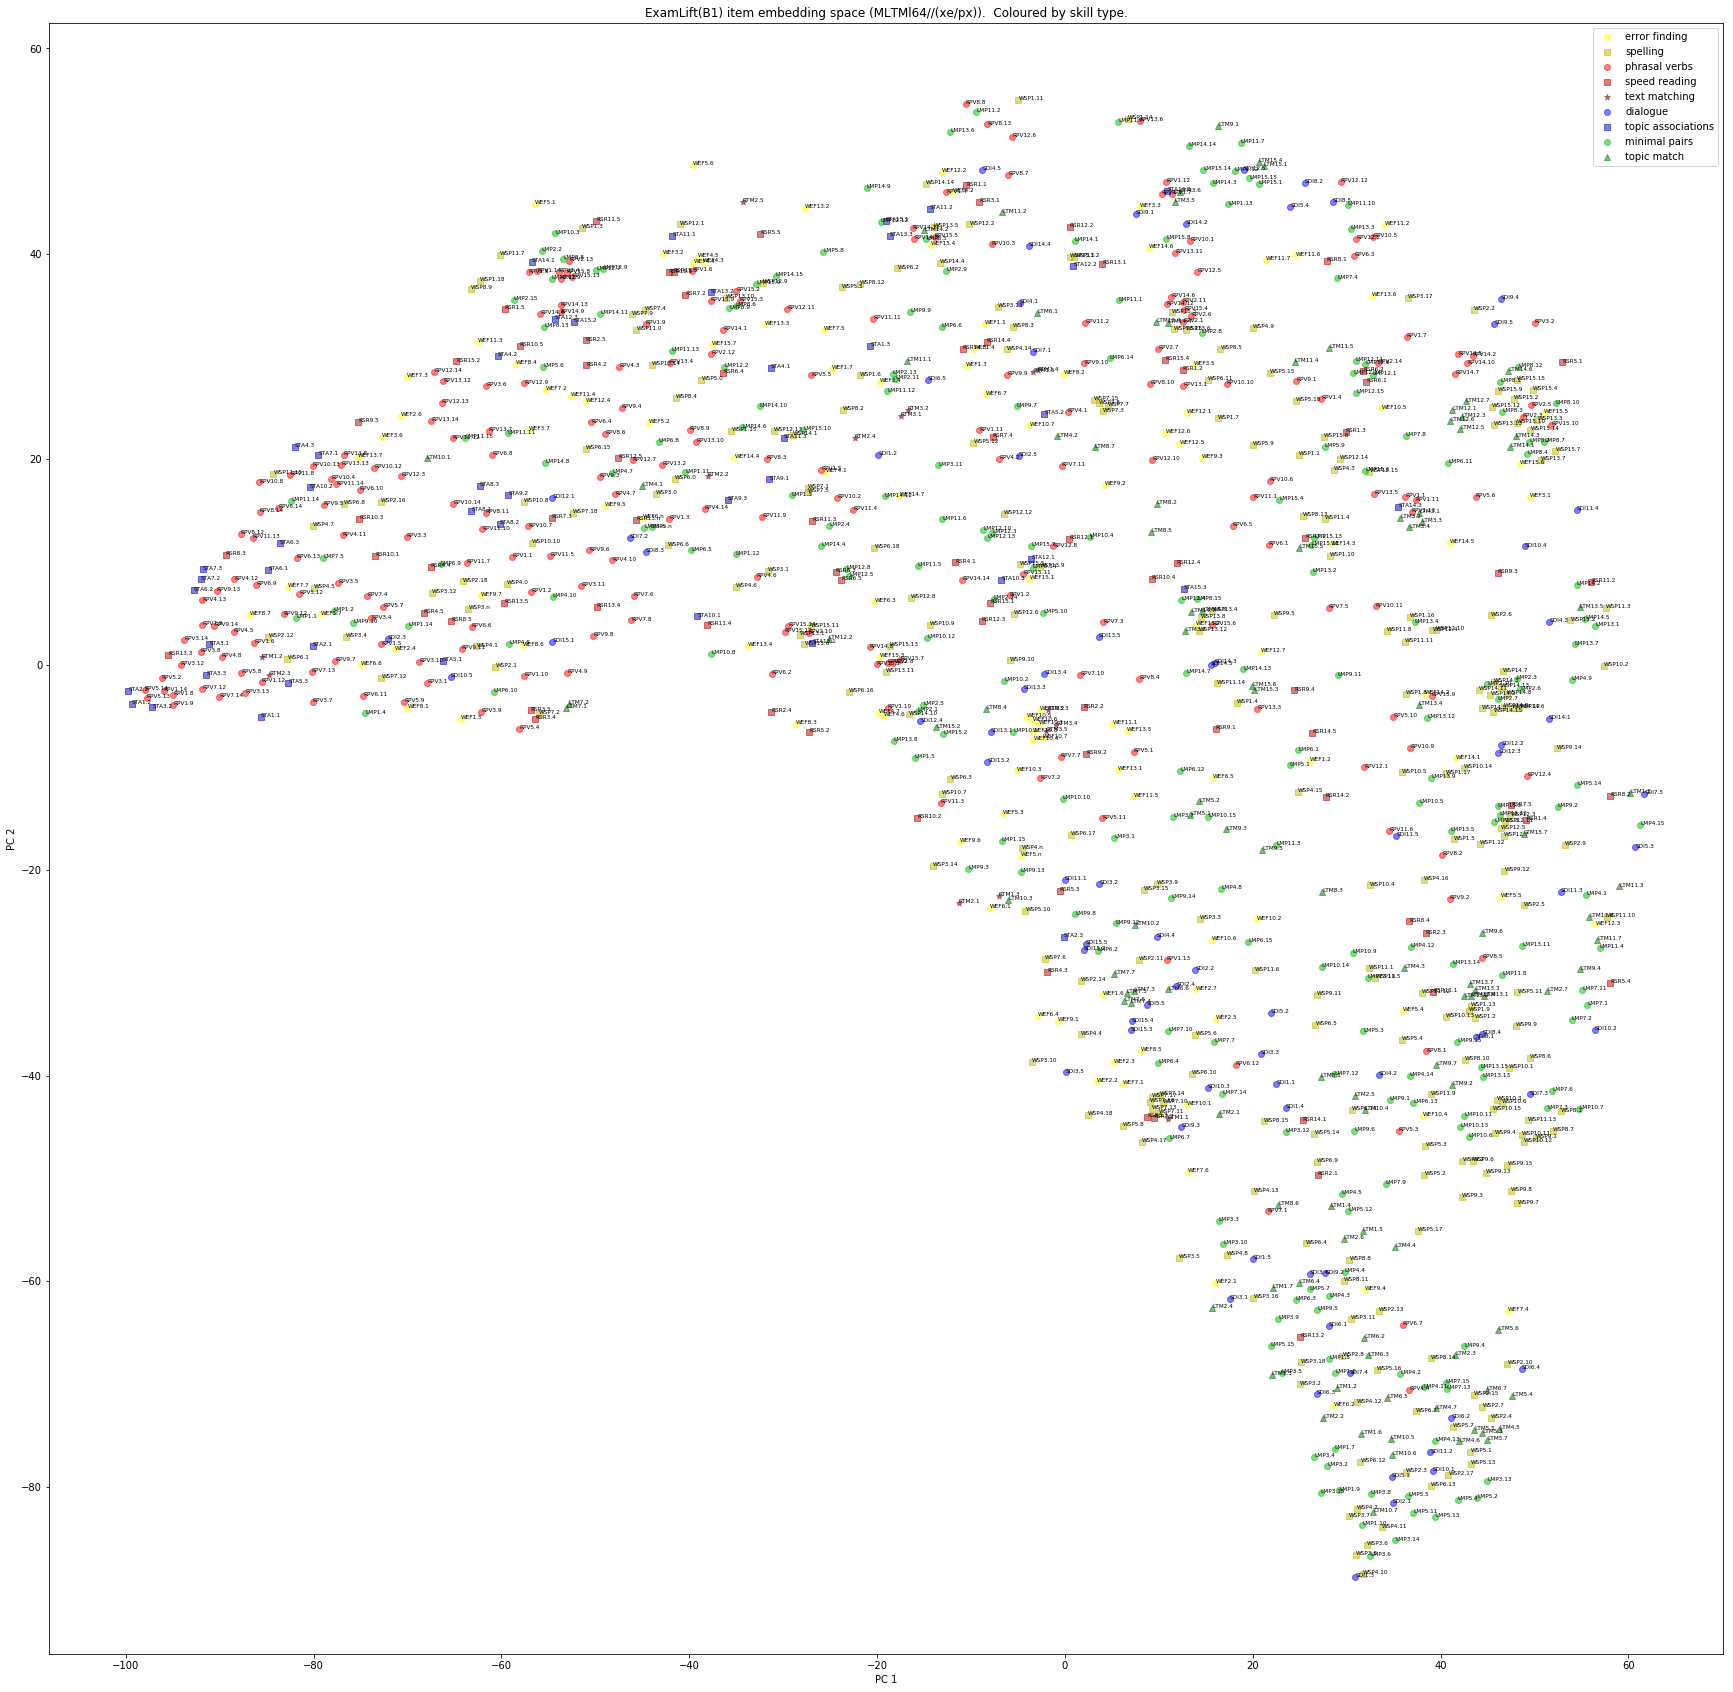

scatter group error finding
len hards heads
prac vec shape (1134, 64)
scatter group speed reading
len hards heads
prac vec shape (1134, 64)
scatter group dialogue
len hards heads
prac vec shape (1134, 64)
scatter group minimal pairs
len hards heads
prac vec shape (1134, 64)
scatter group spelling
len hards heads
prac vec shape (1134, 64)
scatter group topic associations
len hards heads
prac vec shape (1134, 64)
scatter group phrasal verbs
len hards heads
prac vec shape (1134, 64)
scatter group topic match
len hards heads
prac vec shape (1134, 64)
scatter group text matching
len hards heads
prac vec shape (1134, 64)


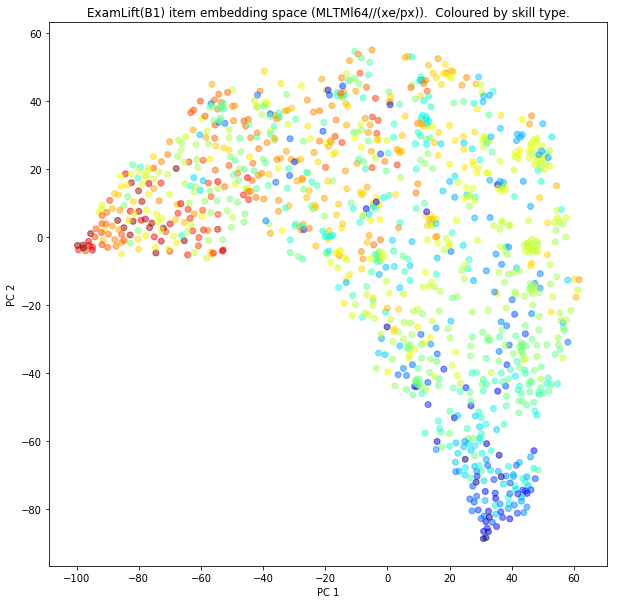

In [295]:
sprinkles_data = (o_qixs, v_qixs, t_qixs)
sprinkles_data = (sprinkles_data,(10,10,10))
plot_practice(qs, practice_loadings, plot_qgroups=True, sprinkles=sprinkles_data, plot_arrows=False, entity_type="item", graph_title="ExamLift(B1) item embedding space ({}).  Coloured by skill type.")#"\nArrows show effect of practice for each question.")

gammas tempt shap (610, 128)
zeroed shapes
(610, 128)
(610, 128)
TXD and Prac TXD shape
(610, 2) (610, 2)
scatter group 0
len hards heads
prac vec shape (610, 128)


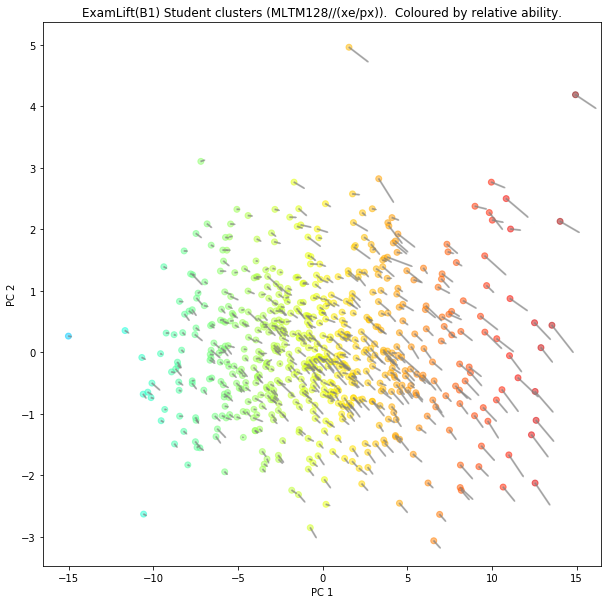

In [205]:
print("gammas tempt shap", gammas.shape)
sprinkles_data = (o_sixs, v_sixs, t_sixs)
sprinkles_data = (sprinkles_data,(len(o_sixs),len(v_sixs),len(t_sixs)))

# plot_practice(alphas, gammas, plot_qgroups=False, plot_arrows=False, graph_title="ExamLift(B1) Student clusters ({}).  Coloured by relative ability.")
plot_practice(alphas,gammas, plot_qgroups=False, sprinkles=sprinkles_data, entity_type="student", plot_arrows=True, graph_title="ExamLift(B1) Student clusters ({}).  Coloured by relative ability.")

In [ ]:
# numpy.power(-0.01760579, 0.40941048)

In [ ]:
plot_arrows = True
for cluster_handle, cluster_m in [(this_handle, this_m), ]:

    s_indices = range(len(alphas))
    
    if plot_arrows:
#         scaler = StandardScaler()
        print("gammas shape", gammas.shape)
        post_prac = alphas+ gammas
#         alphas =  scaler.transform(alphas)
#         post_prac = scaler.transform(post_prac)
        pca = PCA(n_components=2)
        txd = pca.fit_transform(alphas)
        practice_txd = (pca.transform(post_prac) - txd)
    else:
#         scaler = StandardScaler()
#         alphas =  scaler.transform(alphas)
#         dimr = TSNE(n_components=2)
        #dimr = MDS(n_components=2, metric=True, n_jobs=-1)
        txd = pca.transform(alphas)
        
    cmap = plt.cm.jet
    plt.figure(figsize=(10,10))
    print(numpy.min(alphas))
    loc = alphas - numpy.min(alphas)
#     print(numpy.min(f2))
    
    opt = dict(color=None, 
#             arrowstyle = 'simple,head_width=5,head_length=7.5',
#             arrowstyle = '->',
#             arrowstyle='simple',
    width=1,
    headwidth=1,
    headlength=1,
#     mutation_scale=.2,
    alpha=.5,
    connectionstyle = 'arc3,rad=0')
    
    for c in [0]:

#         q_indices = scatter_groups[c]
#         abz = [numpy.sqrt(numpy.sum(numpy.square(numpy.clip(loc[six,:],0,math.inf)))) for six in s_indices]
#         abz2 = [numpy.median(f2[qix,:]) for qix in s_indices]
        abz = [numpy.sqrt(numpy.sum(numpy.square(loc[six,:]))) for six in s_indices]
        
#         for inner in ohg_txd:
#             for row,x,y in zip(inner,xs,ys):
# #                 print(row)
#                 dx,dy = row
#         cmap.set_over(max(abz))
#         cmap.set_under(min(abz))
#         plt.clim(min(abz),max(abz))
#         mn = numpy.sqrt( numpy.min(xs_end)**2 + numpy.min(ys_end)**2)
#         mx = numpy.sqrt( numpy.max(xs_end)**2 + numpy.max(ys_end)**2)
        xs = txd[s_indices,0]
        ys = txd[s_indices,1]
        
        if plot_arrows:
            hdg = gammas# - numpy.min(gammas) 
            print(hdg.shape)
            hdg_abz = [numpy.sqrt(numpy.sum(numpy.square(hdg[six,:]))) for six in s_indices]
            norm = plt.Normalize(min(hdg_abz),max(hdg_abz))
            xs_end = practice_txd[s_indices,0]
            ys_end = practice_txd[s_indices,1]
            for x,y,dx,dy,c in zip(xs,ys,xs_end,ys_end,hdg_abz):
                opt["color"]= 'gray' #cmap(norm(c))
                plt.annotate('', xycoords='data', xy=(x+dx,y+dy), xytext=(x,y), arrowprops=opt)
        
        plt.scatter(x=xs, y=ys, c=abz, cmap=cmap, alpha=0.5)
        
#     plt.clim(numpy.min(hardz), numpy.max(hardz))
    plt.colorbar(ticks=[numpy.min(abz), 0, numpy.max(abz)])
    plt.title("ExamLift(B1) Students in skill-space ({}).  Coloured by relative starting ability.\nArrows show the per-student change in skill from attempting 'average item' from item bank.".format(cluster_handle))

#     plt.title("ExamLift(B1) Question embedding space ({}).  Coloured by skill type.\nArrows show effect of practice for each question.".format(cluster_handle))
    plt.savefig(home+"/images/"+dataset_name+"_student_prac_vecs.pdf", format="pdf")

    plt.show()


In [ ]:
# # history_results = step_through_cog_models(sixs, qixs, hout, cog_models= ["SLFA"]*10 )
# from sklearn.metrics import f1_score

# # adj_mcs = defaultdict(list)
# avg_stats = []
# cos_avg_stats = []
# handlez = []
# numpy.set_printoptions(precision=4, suppress=True)
# m_all_list = []
# mcnt = 0
# best_nvarz = math.inf
# best_cor = -1
# best_var_handle = None
# best_cor_handle = None
# best_var_m = None
# best_cor_m = None
# var_df = {}
# cor_df = {}

# for handle in model_lookup:
#     adj_mcs = []
#     qss = []
#     handles_unravelled = []
#     m_list = model_lookup[handle]
#     print("Got", len(m_list),"models for handle",handle)
    
# #     cos_adj_mcs = []
#     for m_ix, m in enumerate(m_list):
# #         handles_unravelled.append(handle)
#         qs = m.get_layer("qn_embedding").get_weights()[0]
#         try:
#             skill_diffs = m.get_layer("skills_diffs").get_weights()[0]
#             qs = numpy.multiply(qs,skill_diffs)
#         except:
#             print("skill difs not found")
#         amx = build_adjacency_matrix(qs)
# #         if adj_mcs==[]:
# #             sel_jxs = numpy.random.choice(range(len(amx)), replace=False, size=10000)
#         qss.append(qs)
# #         adj_mcs.append([amx[j] for j in sel_jxs])
#         adj_mcs.append(amx)
        
#     print(handle, m_ix, hopkins(qs))
# #     qs = StandardScaler().fit_transform(qs)
# #     print(handle, m_ix, hopkins(qs))
#     for qs in qss:
#         proj = PCA(n_components=2).fit_transform(qs)
#         plt.scatter(proj[:,0], proj[:,1], alpha=0.1)
#     plt.show()
#     varz, nvarz, _, _ = compare_adj_matrices(adj_mcs, handle=handle)
#     print("||||| ||  |")
            
# #         adj_mcs.append(numpy.random.choice(amx, size=100))
# # #         cos_amx = build_adjacency_matrix(qs, cosine=True)
# # #         cos_adj_mcs.append(cos_amx)

# #     kde_df = {}
# #     for ix,(h,amx) in enumerate(zip(handles_unravelled, adj_mcs)):
# #         #print(h, amx[0:10])
# #         kde_df[str(ix)+"_"+h] = amx
# #     pandas.DataFrame(kde_df).plot(kind="kde")
    

In [ ]:
# from sklearn.metrics import f1_score

# all_sixs = o_sixs
# all_qixs = o_qixs
# all_hits = o_hits
# #best_var_m

# def calculate_interaction_values(qixs, sixs, hists, m_list):
#     valz = []
#     pr_cache = {}
#     for ix,m1 in enumerate(m_list):
#         prs1 = m1.predict([qixs, sixs, hists]).ravel()
# #         pr_cache[ix] = prs1
#         for ix2, m2 in enumerate(m_list):
#             if m1 != m2:
# #                 if ix2 in pr_cache:
# #                     prs2 = pr_cache[ix2]
# #                 else:
#                 prs2 = m2.predict([qixs, sixs, hists]).ravel()
# #                     pr_cache[ix2]=prs2
#                 difs = numpy.abs(prs1 - prs2)
#                 valz.append(difs)
#     return valz

# best_sd = math.inf
# for_report = {}
# best_var_handle = None
# for handle in model_lookup:
#     m_list = model_lookup[handle]
#     print("Got", len(m_list),"models for handle",handle)
#     print("num of t_qixs", len(t_qixs))
#     list_o_prs = calculate_interaction_values(t_qixs, t_sixs, t_hits, m_list)   
#     print(list_o_prs)
#     df = numpy.array(list_o_prs)
#     print(df.shape)
#     stds = numpy.std(df, axis=0)
#     print(stds)
#     mu_sd = numpy.mean(stds)
#     print(mu_sd)
#     for_report[handle] = [mu_sd]
#     if mu_sd < best_sd:
#         best_sd = mu_sd
#         best_var_handle = handle
#         best_var_metric = 0
#         for m_ in m_list:
#             p_hats = numpy.round( m_.predict( [t_qixs, t_sixs, t_hits] ) )
#             t_f1 = f1_score(t_out, p_hats, average="macro")
#             if t_f1 > best_var_metric:
#                 print("new best", handle,"f1=",t_f1)
#                 best_var_metric = t_f1
#                 best_var_m = m_

In [ ]:
# df = pandas.DataFrame.from_dict(for_report, orient="index")
# print(best_var_handle, best_sd)

# print(df.sort_values(0))

In [ ]:
print(df.index)

In [ ]:
y_true = np.array([0, 1, 1])
y_pred = np.array([0.1, 0.2, 0.9])
ll = -log_loss(y_true, y_pred)
print(ll)

In [ ]:
# from sklearn.metrics import f1_score
# inxz = None

# score_list = []

# var_df = {}

# best_score = -1
# for handle in model_lookup:
#     adj_mcs = []
#     handles_unravelled = []
#     m_list = model_lookup[handle]
#     print("Got", len(m_list),"models for handle",handle)
    
# #     cos_adj_mcs = []
#     for m in m_list:
#         handles_unravelled.append(handle)
#         qs = m.get_layer("qn_embedding").get_weights()[0]
#         try:
#             skill_diffs = m.get_layer("skills_diffs").get_weights()[0]
#             qs = numpy.multiply(qs,skill_diffs)
#         except:
#             print("skill difs not found")
#         amx = build_adjacency_matrix(qs)
# #         adj_mcs.append(amx)
#         if adj_mcs==[]:
#             inxs = numpy.random.choice(range(len(amx)), size=10000)
#         temp_amx = [amx[x] for x in inxs]
# #         print(temp_amx[0:10])
#         adj_mcs.append(temp_amx)
# #         cos_amx = build_adjacency_matrix(qs, cosine=True)
# #         cos_adj_mcs.append(cos_amx)
    
#     print("calling compare adj mxs")
#     sc, _, _,_ = compare_adj_matrices(adj_mcs, handle=handle)
# #     cos_varz, cos_nvarz, cos_cor, cos_ncor = compare_adj_matrices(cos_adj_mcs, handle=handle)

# #     score_list.append(sc)
# #     cor_list.append(cor)

#     if sc > best_score:
#         print("found better variance", sc, "was:", best_score)
#         best_score = sc
#         best_handle = handle
#         best_metric = 0
#         print("Running models from m_list")
#         for m_ in m_list:
#             p_probs = m_.predict( [t_qixs, t_sixs, t_hits] )
#             p_hats = numpy.round( p_probs )
#             t_f1 = f1_score(t_out, p_hats, average="macro")
#             if t_f1 > best_metric:
#                 print("new best", handle,"f1=",t_f1)
#                 best_metric = t_f1
#                 best_m = m_

#     #     handlez.append(handle)
#     #     avg_stats.append( (nvarz, varz, ncor, cor) )
#     var_df[handle] = [sc, 0]
# #     cor_df[handle] = [ncor, cor]
#     #     cos_avg_stats.append( (cos_nvarz, cos_varz, cos_ncor, cos_cor) )

# # for v,c in zip(var_list, cor_list):
# # plt.scatter(x=var_list, y=cor_list)
# # plt.show()

# print("* * * * * ")

# print("best var h", best_handle)
# # print("best cor h", best_cor_handle)

In [ ]:
# avg_mcs = {}
# for h in adj_mcs:
#     these_mcs = adj_mcs[h]
# #     summa = numpy.zeros_like(these_mcs[0])
# #     avg_mx = numpy.mean(these_mcs)
# #     print(len(these_mcs), these_mcs[0].shape)
# #     these_mcs = numpy.array(these_mcs)
# #     print("shape", these_mcs.shape)
# #     avg_mcs[h]=avg_mx
#     if len(these_mcs)==1:
#         avg_mx = these_mcs[0]
#     avg_mcs[h]=avg_mx
    
# for h in avg_mcs:
#     compare_adj_matrices(avg_mcs[h], normalise=False)
# print("* * * * * ")
# # compare_adj_matrices(adj_mcs, normalise=True)

In [ ]:
robert_rankin = []
for qix, qemb in enumerate(qs):
    qn_name = qix_qid_lookup[qix]
    difficulty = numpy.sqrt(numpy.sum(numpy.square(qemb)))
    robert_rankin.append( (difficulty, qn_name) )
robert_rankin = list(reversed(sorted(robert_rankin)))

print("Hardest 10 Qns")
for pair in robert_rankin[0:10]:
    print(pair)

print("Easiest 10 Qns")
for pair in robert_rankin[-10:]:
    print(pair)

# plt.figure(figsize=(10,10))
# for c in scatter_groups:
#     q_indices = scatter_groups[c]
#     speedz = [numpy.sqrt(numpy.sum(numpy.square(qk_loadings[qix,:]))) for qix in q_indices]
#     plt.scatter(x=txd[q_indices,0], y=txd[q_indices,1], c=speedz, cmap=cmap, alpha=0.6)
# plt.colorbar()
# plt.show()


# #CLUSTER BY TRANSPOSED VPT
# results = m.predict([_qixs, _sixs, _hits])

In [ ]:
alphas = m.get_layer("alphas").get_weights()[0]
gammas = m.get_layer("gammas").get_weights()[0]
from sklearn.decomposition import PCA

for six in range(n_students):
# #   print(alphas[six])
  print(numpy.round(gammas[six],2))

# print(alphas.shape)
print(gammas.shape)

# fombo = numpy.concatenate([alphas, gammas], axis=1)
fombo = alphas
speed = numpy.mean(gammas, axis=1)
pca = PCA(n_components=2)
txd = pca.fit_transform(fombo)
plt.scatter(x=txd[:,0], y=txd[:,1], c=speed)
plt.colorbar()
plt.show()

In [ ]:
alphas = m.get_layer("alphas").get_weights()[0]
print(alphas.shape)
for six in range(n_students):
  print(numpy.round(alphas[six],2), sum(alphas[six]))

In [ ]:
from keras.regularizers import l1
from keras.layers import Dropout, multiply, subtract, GaussianNoise, GaussianDropout, Input, Lambda, Dense
from keras import backend as K
from keras import Model
def generate_multilabel_model(n_factors, optimiser):
    outw = 9
    qn_emb = Input(shape=(n_factors,), name="q_embedding")
  
    h = qn_emb
#     h = Dense( n_factors, activation="relu")(h)
#     h = Dense( (n_factors + outw)//2, activation="relu")(h)
#     h = Dense( 5, activation="relu")(h)
#     h = Dense( 5, activation="relu")(h)
    h = Dense(30, activation="relu")(h)
    kc_pred = Dense(outw, activation="softmax")(h)
    
    model = Model(inputs=qn_emb, outputs=kc_pred)
    model.compile(optimizer=optimiser, loss="categorical_crossentropy", metrics=["accuracy"])
#     model.compile(optimizer=optimiser, loss="mse", metrics=["accuracy"])

    print(model.summary())

    return model

In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=10)
qws = m.get_layer("qn_embedding").get_weights()[0]
ww = qws.shape[1]
qn_embs = []
kc_list = []
KCs = [ 'error finding', 
        'spelling', 
        'phrasal verbs', 
        'speed reading', 
        'text matching',
        'dialogue', 
        'topic associations', 
        'minimal pairs', 
        'topic match', 
    ]

    
ixs = [ix for ix in range(len(qws))]
numpy.random.seed(666)
tr_ixs = numpy.random.choice(ixs, size=int(0.9*len(ixs)), replace=False)
print(len(tr_ixs))


tt_ixs = set(ixs) - set(tr_ixs)

tr_outs = []
w_outs = []
for qix in tr_ixs:
    qn_id = qix_qid_lookup[qix]
    print(qn_id)
    c = qn_id.split("~")[0][0:-2]
    c = c.lower().strip()
    c = "minimal pairs" if c=="miminal pairs" else c
    kc_ohe = [0 for _ in KCs]
    kcix = KCs.index(c)
    print(kcix)
    kc_ohe[kcix] = 1
    tr_outs.append(kc_ohe)
    w_outs.append(kcix)
tr_outs = numpy.array(tr_outs).reshape(-1,len(KCs))
print(len(tr_outs))
    
tt_outs = []
for qix in tt_ixs:
    qn_id = qix_qid_lookup[qix]
    print(qn_id)
    c = qn_id.split("~")[0][0:-2]
    c = c.lower().strip()
    c = "minimal pairs" if c=="miminal pairs" else c
    kc_ohe = [0 for _ in KCs]
    kcix = KCs.index(c)
    kc_ohe[kcix] = 1
    tt_outs.append(kc_ohe)
tt_outs = numpy.array(tt_outs).reshape(-1,len(KCs))
    
from sklearn.utils.class_weight import compute_class_weight
print(w_outs)
# class_wgts = compute_class_weight("balanced", range(len(KCs)), w_outs)
class_wgts = compute_class_weight("balanced", [0,1], tt_outs.flatten())
print(class_wgts)
class_wgts = [cw/min(class_wgts) for cw in class_wgts]
del w_outs

# qn_embs = numpy.array(qn_embs)
# kc_list = numpy.array(kc_list)

# kc_sums = numpy.sum(kc_list, axis=0)
# kc_max = numpy.max(kc_sums)
# print(kc_max)
# kc_sums = kc_max / kc_sums

# print("KC sums", kc_sums)
# class_wgts = {}
# for ix,kcs in enumerate(kc_sums):
#     class_wgts[ix] = kcs

print(class_wgts)
print(ww)

In [ ]:
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
qn_embs = qws
ww = qws.shape[1]
print("QN embs\n", qn_embs)
# print("KC list\n",kc_list)
print("#samples:", 0.9*len(tr_ixs), 0.1*len(tr_ixs), len(tt_ixs))
# from sklearn.metrics import multilabel_confusion_matrix

print(len(tr_outs))

f1_list = []
n_reps = 10
tr_embs = [qws[i,:] for i in tr_ixs]
tr_embs = numpy.array(tr_embs).reshape((-1, ww))

tt_embs = [qws[i,:] for i in tt_ixs]
tt_embs = numpy.array(tt_embs).reshape((-1, ww))


for _ in range(n_reps):
#     qn_embs = numpy.reshape(qn_embs, (-1, ww))
#     kc_list = numpy.reshape(kc_list, (-1, 9))

    emb_mod = generate_multilabel_model(ww, Adam())
    emb_mod.fit(tr_embs, tr_outs, batch_size=32, epochs = 1000000, validation_split=0.1, class_weight=class_wgts, callbacks=[es])

    # print("test:", emb_mod.evaluate(qn_embs, kc_list))
    predz = emb_mod.predict(tt_embs)
    print((predz>=0.5).astype(int))

    # print("test:", f1_score(kc_list, preds>=0.5))

    print(confusion_matrix(tt_outs.flatten(), (predz.flatten() >= 0.5 )))
    this_f1 = f1_score(tt_outs.flatten(), (predz.flatten() >= 0.5 ))#, average="macro")
    print(this_f1)
    f1_list.append( this_f1)

print(f1_list)
print(numpy.mean(f1_list), numpy.std(f1_list))
    # print(multilabel_confusion_matrix(kc_list, (predz >= 0.5 )))

In [ ]:
qws = this_m.get_layer("qn_embedding").get_weights()[0]
for qix in range(len(qws)):
    qid = qix_qid_lookup[qix]
    print(qix, qid)

In [ ]:
mag_list = []
for qix,qw in enumerate(qws):
    qid = qix_qid_lookup[qix]
    mag = numpy.linalg.norm(qw, ord=2)
    mag_list.append((mag, qix))
sorted_list = sorted(mag_list)

for pr,sr in zip(mag_list, sorted_list):
    print(pr[1], sr[1], sr[0])
    
for sr in sorted_list:
    print(qix_qid_lookup[sr[1]])

In [ ]:
df = pandas.read_csv("~/Downloads/Worksheet_1041.csv")#, nrows=10000)
# print(df[0:100])


maBgebliche_reihen = df[(~df["question_order"].isnull()) & (df["event_type"]=="answer_submitted")]
maBgebliche_reihen = maBgebliche_reihen[["user_id","timestamp","activity_name","question_order"]]
maBgebliche_reihen["qid"] = maBgebliche_reihen["activity_name"].map(str) + "~" + maBgebliche_reihen["question_order"].map(str)
maBgebliche_reihen = maBgebliche_reihen.drop_duplicates()
print(maBgebliche_reihen)
# raise Exception("Twat")

print(len(df["user_id"]))
user_ids = list(df["user_id"].drop_duplicates())
print("--------")

del df

user_zahl = defaultdict(int)
id_orderlist_dict = defaultdict(list)
# for uid in user_ids:
#     print("counting", uid)
#     diese_reihen = maBgebliche_reihen[maBgebliche_reihen["user_id"]==uid]
#     ix = 0
diese_reihen = maBgebliche_reihen
print("counting")
for _,reihe in diese_reihen.iterrows():
    user_id = reihe["user_id"]
    frage_name = reihe["qid"] 
    ix = user_zahl[user_id]
    id_orderlist_dict[frage_name].append(ix)
    user_zahl[user_id] += 1

del diese_reihen
del maBgebliche_reihen

# print(id_orderlist_dict)
neue_ordnung_liste = []
print("averaging")
for k in id_orderlist_dict:
#     print("averaging", k)
    anzahlen = id_orderlist_dict[k]
#     print(k, anzahlen)
    durchschnittlicher_stand = numpy.median(anzahlen)
#     neue_ordnung_dict[k] = durchschnittlicher_stand
    neue_ordnung_liste.append((durchschnittlicher_stand, k, len(anzahlen)))

del id_orderlist_dict    
for k,stand,wieviel in sorted(neue_ordnung_liste):
    print(k, stand, "({})".format(wieviel))